## Align to Chinook

In [1]:
import pysam
import os.path
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("white")
%matplotlib inline

In [2]:
chin_ex = pd.read_excel(os.path.join('data','ref','chinook','Supplemental Table 1.xlsx'))
chin_ex.head()

,Locus,Chromosome,Duplicate,Arm,Position (cM),Region of population divergence,Paired-end annotation,Locus name from Larson et al. 2014,Outlier from Larson et al. 2014,Consensus Sequence
0,44207_x1,Ots01,1,p,0.00,0,NaN,NaN,NaN,TGCAGGTGTCTGCAAAAAAACACTCCCCTCCCTAGTTCTCCATATG...
1,28051_x1,Ots01,1,p,0.55,0,NaN,NaN,NaN,TGCAGGCACCTGGACAGCCACAAGGAGTCGCTAGATTGTGATGAGC...
2,6689_x1,Ots01,1,p,0.55,0,NaN,NaN,NaN,TGCAGGGAGAAACTTTGTAGTGGGGTGAAAAGAGGGAGAAGCATCG...
3,59778_x1,Ots01,1,p,0.55,0,NaN,NaN,NaN,TGCAGGATATTAATGCAGGTAAGAAGAAATGGCTTTTAAATGTTTT...
4,38781_x1,Ots01,1,p,0.55,0,PRTG,NaN,NaN,TGCAGGAAGGGTCCTCTGGTGGACAACAGAACTCCAGGGACTGGAC...


In [3]:
chin_ex = chin_ex[['Locus', 'Consensus Sequence', 'Chromosome', 'Position (cM)']]
chin_ex['Locus_basename'] = [xx.split('_')[0] for xx in chin_ex['Locus'] ]
chin_ex.head()

,Locus,Consensus Sequence,Chromosome,Position (cM),Locus_basename
0,44207_x1,TGCAGGTGTCTGCAAAAAAACACTCCCCTCCCTAGTTCTCCATATG...,Ots01,0.00,44207
1,28051_x1,TGCAGGCACCTGGACAGCCACAAGGAGTCGCTAGATTGTGATGAGC...,Ots01,0.55,28051
2,6689_x1,TGCAGGGAGAAACTTTGTAGTGGGGTGAAAAGAGGGAGAAGCATCG...,Ots01,0.55,6689
3,59778_x1,TGCAGGATATTAATGCAGGTAAGAAGAAATGGCTTTTAAATGTTTT...,Ots01,0.55,59778
4,38781_x1,TGCAGGAAGGGTCCTCTGGTGGACAACAGAACTCCAGGGACTGGAC...,Ots01,0.55,38781


drop duplicates, checking with locus basename and sequence

In [4]:
chin_ex.drop_duplicates(subset = ['Locus_basename', 'Consensus Sequence'], inplace = True)

check that each locus is now present only once

In [5]:
len(set(chin_ex['Locus_basename'])) == len(chin_ex['Locus_basename'])

True

In [6]:
with open(os.path.join('data','ref','chinook','chin_ref.fasta'), 'w') as OUTFILE:
    count = 0
    for index,  locus_row in chin_ex.iterrows():
        
        OUTFILE.write('>{}\n{}\n'.format(locus_row['Locus_basename'], locus_row['Consensus Sequence']))

### Align chum loci to chinook loci using bowtie 2 

In [7]:
chin_FASTA = 'chin_ref.fasta'

In [8]:
print('bowtie2-build {} chinook'.format(chin_FASTA))

bowtie2-build chin_ref.fasta chinook


chum ref

In [9]:
chum_ref = '/media/Shared/Data/chum/populations/ref/paper_1/chum_paper_1_ref.CURATED.fasta'

align

In [10]:
SAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_chinook.SAM'
filtered_SAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_chinook.filtered.SAM'

run bowtie 2

check directories here

In [11]:
print('bowtie2 -f --local --very-sensitive -p 4 -x /home/ipseg/Desktop/waples/chum_populations/data/ref/chinook/chinook -U {} -S {}'.format(chum_ref, SAM_output))

bowtie2 -f --local --very-sensitive -p 4 -x /home/ipseg/Desktop/waples/chum_populations/data/ref/chinook/chinook -U /media/Shared/Data/chum/populations/ref/paper_1/chum_paper_1_ref.CURATED.fasta -S /home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_chinook.SAM


#### Examine reference

In [12]:
def get_aligns():
    return(pysam.AlignmentFile(SAM_output, "r").fetch())

### Mapping quality

In [13]:
mpqs = [read.mapping_quality for read in get_aligns()]

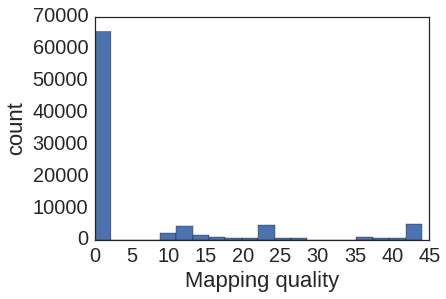

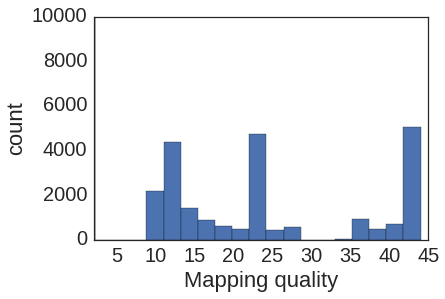

In [14]:
plt.hist(mpqs, bins = 20)
plt.xlabel('Mapping quality')
plt.ylabel('count')
plt.title('')
plt.show()

plt.hist(mpqs, bins = 20)
plt.xlabel('Mapping quality')
plt.ylabel('count')
plt.title('')
plt.xlim(2)
plt.ylim(0, 10000)
plt.show()

### As expected, there is strand bias

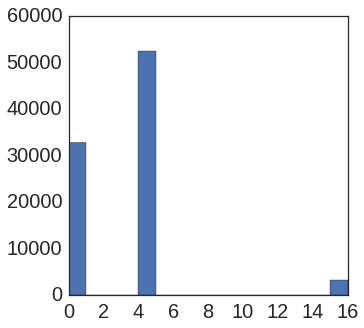

In [15]:
flags  = [read.flag for read in get_aligns()]
figsize(5,5)
plt.hist(flags, bins = 16)
plt.show()

### Alignment lengths

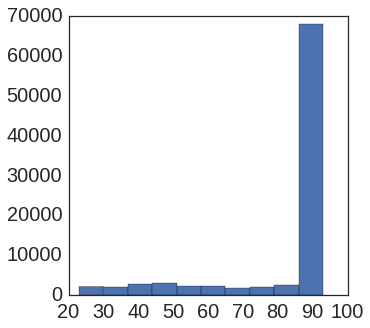

In [16]:
qal =  [read.query_alignment_length for read in get_aligns()]
plt.hist(qal)
plt.show()

### Edit distances

In [17]:
edit_distances = list()
mq = list()
for read in get_aligns():
    try:
        edit_distances.append(np.int(read.get_tag('XM')))
        mq.append(np.int(read.mapping_quality))
    except KeyError:
        pass

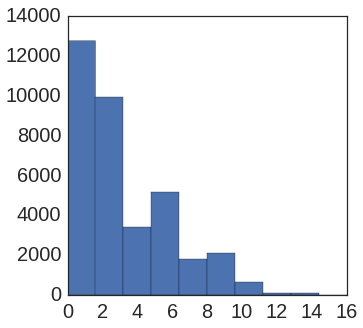

In [18]:
plt.hist(edit_distances)
plt.show()

### Edit distance vs Mapping quality

In [19]:
rr = pd.DataFrame({'ed' : edit_distances, 'mq' : mq })

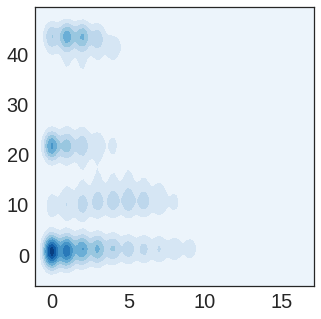

In [20]:
sns.kdeplot(rr, cmap="Blues", shade = True, legend = True)
plt.show()

#### Lets keep only the alignments with:
(query_alignment_length >= 93) AND (mapping_quality >= 30)

In [21]:
with pysam.AlignmentFile(SAM_output, "r") as INFILE:
    with pysam.AlignmentFile(filtered_SAM_output, "wh", template=INFILE) as OUTFILE:
        for aln in INFILE:
            if (aln.query_alignment_length >= 93) and (aln.mapping_quality >= 30):
                OUTFILE.write(aln)

In [22]:
filtered_SAM = pd.read_csv(filtered_SAM_output, sep = '\t', comment='@', engine='python', 
            names = ['QNAME','FLAG','RNAME','POS','MAPQ','CIGAR','RNEXT','PNEXT','ISIZE','SEQ','QUAL',
                     'TAG1', 'TAG2', 'TAG3' 'TAG4', 'TAG5', 'TAG6', 'TAG7','TAG8', 'TAG9','TAG10'])
filtered_SAM.head()

,QNAME,FLAG,RNAME,POS,MAPQ,CIGAR,RNEXT,PNEXT,ISIZE,SEQ,QUAL,TAG1,TAG2,TAG3TAG4,TAG5,TAG6,TAG7,TAG8,TAG9,TAG10
0,c6,0,66281,1,44,93M,*,0,0,TGCAGGTACTGCCTCTGCTTGGGCAGCCGCGGGGTCATCAGAGGGC...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:178,XN:i:0,XM:i:1,XO:i:0,XG:i:0,NM:i:1,MD:Z:41C51,YT:Z:UU,None
1,c5,0,16028,1,42,93M,*,0,0,TGCAGGCTGTGTCAGTTCATGAAGAACTACCTGCCCCGGGACTTCA...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:146,XN:i:0,XM:i:5,XO:i:0,XG:i:0,NM:i:5,MD:Z:6A17T41A1T8A15,YT:Z:UU,None
2,c14,0,7663,1,44,93M,*,0,0,TGCAGGAATATGAGAGGTTGTTCCAAATACAACTGTCTTTTCTGTT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:186,XN:i:0,XM:i:0,XO:i:0,XG:i:0,NM:i:0,MD:Z:93,YT:Z:UU,None
3,c15,0,2732,1,44,93M,*,0,0,TGCAGGTTGTCCACCCTGGAGATGCAGTTCCCTGCCAGGTTCAACA...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:162,XN:i:0,XM:i:3,XO:i:0,XG:i:0,NM:i:3,MD:Z:37A9A20G24,YT:Z:UU,None
4,c16,0,86922,1,41,25M4I64M,*,0,0,TGCAGGTAACCACTAAAACCATGACCACACACACACACACAACCAA...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:137,XN:i:0,XM:i:3,XO:i:1,XG:i:4,NM:i:7,MD:Z:50C5G12C19,YT:Z:UU,None


In [23]:
filtered_SAM.drop(['POS', 'RNEXT', 'PNEXT', 'ISIZE', 'SEQ','QUAL'], axis=1, inplace=True)
filtered_SAM['RNAME'] = [str(xx) for xx in filtered_SAM['RNAME'] ]
filtered_SAM.head()

,QNAME,FLAG,RNAME,MAPQ,CIGAR,TAG1,TAG2,TAG3TAG4,TAG5,TAG6,TAG7,TAG8,TAG9,TAG10
0,c6,0,66281,44,93M,AS:i:178,XN:i:0,XM:i:1,XO:i:0,XG:i:0,NM:i:1,MD:Z:41C51,YT:Z:UU,None
1,c5,0,16028,42,93M,AS:i:146,XN:i:0,XM:i:5,XO:i:0,XG:i:0,NM:i:5,MD:Z:6A17T41A1T8A15,YT:Z:UU,None
2,c14,0,7663,44,93M,AS:i:186,XN:i:0,XM:i:0,XO:i:0,XG:i:0,NM:i:0,MD:Z:93,YT:Z:UU,None
3,c15,0,2732,44,93M,AS:i:162,XN:i:0,XM:i:3,XO:i:0,XG:i:0,NM:i:3,MD:Z:37A9A20G24,YT:Z:UU,None
4,c16,0,86922,41,25M4I64M,AS:i:137,XN:i:0,XM:i:3,XO:i:1,XG:i:4,NM:i:7,MD:Z:50C5G12C19,YT:Z:UU,None


### Now merge with chum and chinook maps

In [26]:
chum_map = pd.read_csv(os.path.join('linkage_map', 'LEPmap', 'with_paralogs', 'final', 'PS_chum_map_2015.txt'), 
                       sep = '\t', header = 0)
chum_map.head()

,contig,resolved_locus,stacks_CatID,stacks_SNP,LEPname,LEP_LG,cM_OLD,paper1_LG,cM
0,c4311,4311,28282,28282_88,4584,1,0,1,0
1,c4311,4311,28282,28282_91,4584,1,0,1,0
2,c56875,56875,39970,39970_17,7377,1,0,1,0
3,c56875,56875,39970,39970_33,7377,1,0,1,0
4,c56875,56875,39970,39970_49,7377,1,0,1,0


In [39]:
chin_ex.head()

,Locus,Consensus Sequence,Chromosome,Position (cM),Locus_basename
0,44207_x1,TGCAGGTGTCTGCAAAAAAACACTCCCCTCCCTAGTTCTCCATATG...,Ots01,0.00,44207
1,28051_x1,TGCAGGCACCTGGACAGCCACAAGGAGTCGCTAGATTGTGATGAGC...,Ots01,0.55,28051
2,6689_x1,TGCAGGGAGAAACTTTGTAGTGGGGTGAAAAGAGGGAGAAGCATCG...,Ots01,0.55,6689
3,59778_x1,TGCAGGATATTAATGCAGGTAAGAAGAAATGGCTTTTAAATGTTTT...,Ots01,0.55,59778
4,38781_x1,TGCAGGAAGGGTCCTCTGGTGGACAACAGAACTCCAGGGACTGGAC...,Ots01,0.55,38781


In [38]:
chin_lgs = pd.merge(filtered_SAM, chin_ex, left_on = 'RNAME' , right_on = 'Locus_basename')
chin_lgs.head()

,QNAME,FLAG,RNAME,MAPQ,CIGAR,TAG1,TAG2,TAG3TAG4,TAG5,TAG6,TAG7,TAG8,TAG9,TAG10,Locus,Consensus Sequence,Chromosome,Position (cM),Locus_basename
0,c6,0,66281,44,93M,AS:i:178,XN:i:0,XM:i:1,XO:i:0,XG:i:0,NM:i:1,MD:Z:41C51,YT:Z:UU,None,66281_x1,TGCAGGTACTGCCTCTGCTTGGGCAGCCGCGGGGTCATCAGCGGGC...,Ots26,54.09,66281
1,c5,0,16028,42,93M,AS:i:146,XN:i:0,XM:i:5,XO:i:0,XG:i:0,NM:i:5,MD:Z:6A17T41A1T8A15,YT:Z:UU,None,16028_x1,TGCAGGATGTGTCAGTTCATGAAGTACTACCTGCCCCGGGACTTCA...,Ots03,33.01,16028
2,c14,0,7663,44,93M,AS:i:186,XN:i:0,XM:i:0,XO:i:0,XG:i:0,NM:i:0,MD:Z:93,YT:Z:UU,None,7663_x1,TGCAGGAATATGAGAGGTTGTTCCAAATACAACTGTCTTTTCTGTT...,Ots15,25.62,7663
3,c15,0,2732,44,93M,AS:i:162,XN:i:0,XM:i:3,XO:i:0,XG:i:0,NM:i:3,MD:Z:37A9A20G24,YT:Z:UU,None,2732_x1,TGCAGGTTGTCCACCCTGGAGATGCAGTTCCCTGCCAAGTTCAACA...,Ots04,113.34,2732
4,c16,0,86922,41,25M4I64M,AS:i:137,XN:i:0,XM:i:3,XO:i:1,XG:i:4,NM:i:7,MD:Z:50C5G12C19,YT:Z:UU,None,86922_x1,TGCAGGTAACCACTAAAACCATGACCACACACACACAACCAACCAA...,Ots14,86.21,86922


In [40]:
synteny = pd.merge(chum_map, chin_lgs, left_on = 'contig' , right_on = 'QNAME')
synteny.drop_duplicates(subset=['contig'], inplace=True)
synteny.head()

,contig,resolved_locus,stacks_CatID,stacks_SNP,LEPname,LEP_LG,cM_OLD,paper1_LG,cM,QNAME,...,TAG6,TAG7,TAG8,TAG9,TAG10,Locus,Consensus Sequence,Chromosome,Position (cM),Locus_basename
0,c44430,44430_A,29403,29403_58,4865,1,0.00,1,0.00,c44430,...,XO:i:0,XG:i:0,NM:i:3,MD:Z:16T41T21T12,YT:Z:UU,42094_x1,TGCAGGGCGCTGCGTTTGCCACACCTGGACAGTTCACATCAGGTAT...,Ots14,123.18,42094
1,c37517,37517,23631,23631_32,3764,1,2.95,1,2.95,c37517,...,XG:i:0,NM:i:0,MD:Z:93,YT:Z:UU,None,68945_x1,TGCAGGTATGAAAACAATATAGTTAAATACTAGTCGTGACCAGGTA...,Ots14,109.71,68945
2,c20050,20050,8866,8866_57,1701,1,4.84,1,4.84,c20050,...,XO:i:0,XG:i:0,NM:i:1,MD:Z:87C5,YT:Z:UU,60182_x1,TGCAGGACTTTTTGGAGTGTGGTGTCAAAAAAGCAGAGCATCTCTT...,Ots14,102.97,60182
4,c25287,25287,13325,13325_69,2352,1,4.84,1,4.84,c25287,...,XG:i:0,NM:i:2,MD:Z:74A9A8,YT:Z:UU,None,31266_x1,TGCAGGTTCGCAGGCATCCATCAATTAAGCAAACAGTTCAGAGGTT...,Ots14,109.71,31266
5,c33192,33192,20020,20020_28,3307,1,19.73,1,19.73,c33192,...,XG:i:0,NM:i:3,MD:Z:23T4G3G60,YT:Z:UU,None,34742_x1,TGCAGGTCAGTGCTAACCCCAACTAAGGGACAGAAGCTGTCATAAA...,Ots14,90.52,34742


In [139]:
synteny_summary = synteny[['contig', 'paper1_LG', 'cM', 'RNAME', 'Chromosome', 'Position (cM)']].copy()
synteny_summary.rename(columns = {'paper1_LG':'chum_LG', 'cM':'chum_cM', 'Chromosome':'Ots_LG', 'Position (cM)':'Ots_cM' }, inplace=True)
synteny_summary['Ots_LG'] = [int(xx.split('s')[1]) for xx in synteny_summary['Ots_LG']]
synteny_summary.head()

,contig,chum_LG,chum_cM,RNAME,Ots_LG,Ots_cM
0,c44430,1,0.00,42094,14,123.18
1,c37517,1,2.95,68945,14,109.71
2,c20050,1,4.84,60182,14,102.97
4,c25287,1,4.84,31266,14,109.71
5,c33192,1,19.73,34742,14,90.52


In [143]:
xx = synteny_summary.sort(columns = ['chum_LG', 'chum_cM'])
xx['chum_pos'] = [ee for ee in range(len(xx))]
xx = xx.sort(columns = ['Ots_LG', 'Ots_cM'])
xx['Ots_pos'] = [ee for ee in range(len(yy))]

In [159]:
xx_breaks = np.where(np.diff(xx.sort(columns = ['chum_LG', 'chum_cM'])['chum_LG'])==1)
yy_breaks = np.where(np.diff(xx.sort(columns = ['Ots_LG', 'Ots_cM'])['Ots_LG'])==1)

In [172]:
[x for x in xx_breaks[0]]

[20,
 56,
 67,
 92,
 121,
 137,
 152,
 165,
 181,
 209,
 227,
 243,
 271,
 302,
 308,
 319,
 335,
 348,
 371,
 394,
 410,
 433,
 448,
 456,
 478,
 500,
 510,
 528,
 557,
 591,
 608,
 651,
 669,
 708,
 724,
 739]

### Oxford Grid

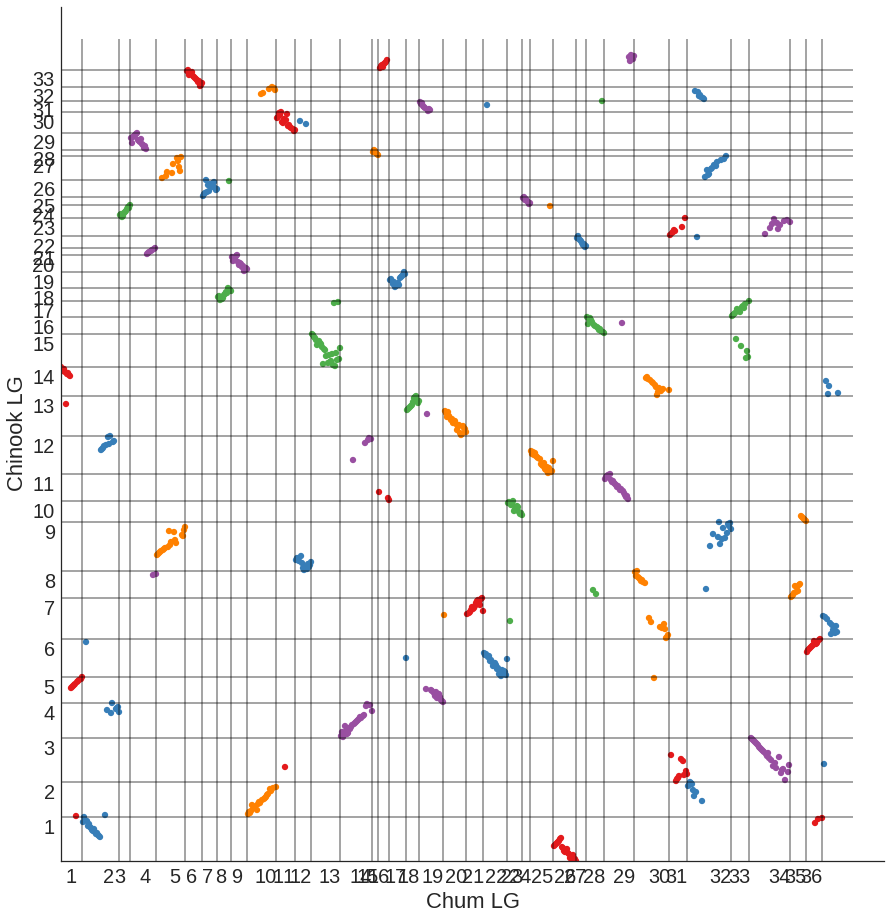

In [193]:
sns.lmplot('chum_pos', 'Ots_pos', data = xx, fit_reg = False, hue = 'chum_LG', legend = False,
           palette=sns.color_palette("Set1", 5), size = 13, scatter_kws = {'alpha':1, 's':40})
plt.xlim(0); plt.ylim(0)
np.diff(xx.sort(columns = ['chum_LG', 'chum_cM'])['chum_LG'])
plt.vlines(xx_breaks, ymin = 0, ymax = 770, alpha = .4)
plt.hlines(yy_breaks, xmin = 0, xmax = 770, alpha = .4)
plt.xticks([x-10 for x in xx_breaks[0]], range(1,38), horizontalalignment = 'center')
plt.yticks([x-10 for x in yy_breaks[0]], range(1,38))
plt.xlabel('Chum LG')
plt.ylabel('Chinook LG')
plt.show()

In [43]:
LG_vs_CHR = pd.crosstab(synteny['paper1_LG'], columns = synteny['Chromosome'])data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA3sAAAOYCAYAAABsHerPAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzs3X18VOWd9/HPBKiGBEhcUGESq9ZyKait2moqVgm1olVL7PpQVkTvVrEvH9ut264PJQa1d3er27oV3abW22ZVttotwceGWoJWuig+tLZBr/oABSbqihIwIQghc/9xzuAwzEMyc2bOmZnv+/XiNTLnOtf5nWM4k99c17l+oWg0ioiIiIiIiJSWCr8DEBEREREREe8p2RMRERERESlBSvZERERERERKkJI9ERERERGREqRkT0REREREpASN9DuAQjPGjATqgA3W2gG/4xEREREREcmHchzZqwPWuK8iIiIiIiIlqRyTPRERERERkZKnZE9ERERERKQEKdkTEREREREpQUr2RERERERESpCSPRERERERkRKkZE9ERERERKQEKdkTEREREREpQUr2RERERERESpCSPRERERERkRKkZE9ERERERKQEKdkTEREREREpQUr2RERERERESpCSPRERERERkRKkZE9ERERERKQEKdkTEREREREpQUr2RERERERESpCSPRERERERkRKkZE9ERERERKQEKdkTEREREREpQUr2RERERERESpCSPRERERERkRKkZE9ERERERKQEKdkTEREREREpQUr2RERERERESpCSPRERERERkRKkZE9ERERERKQEKdkTEREREREpQUr2RERERERESpCSPRERERERkRKkZE9ERERERKQEKdkTEREREREpQUr2PBAKhWaHQqHZfscRbzgxFSp+P66TF8fMpY9s98017mK91l71Vezn7+XxC30vyKaPfF+7fPbv9z0m3/1n2jfo1zbXvr2Kwa/7g9/3pXjFfi2zVU7n7fdndzFcIz8o2RMRERERESlBSvZERERERERKkJI9ERERERGREqRkT0REREREpAQp2RMRERERESlBSvZERERERERKkJI9ERERERGREqRkT0REREREpAQp2RMRERERESlBSvZERERERERKkJI9ERERERGREqRkT0RERKREtDa1hVub2sJ+xyEiwTDS7wBEREREJDetTW2TgPuB6e7fOw+bMPW3Pds2bfY1MBHxlZI9ERERkeL3EHB83N8bjz/g840ArU1tZwNz5rXP7fYlMhHxjZI9ERERkSLljuglJnqJGoH7gBkFCUpEAkPP7ImIiIgUr/tJn+jFNOpZPpHyo5E9EZEyFwnX6xdAkSLkJm/T/Y5DRIJLI3siImUqEq6fFAnXdwIbgA03j6u5/pCRI2v8jktE8qJzXvvciN9BiEhhKdkTESlfu1buA6gJVUy9qKr6cv/CEZHhcJO35UNsfk0eQxGRgFKyJyJShiLh+qNJMv2rJlQxVdM6RYrK+UDPENq9k+9ARCR4lOyJiJSZSLh+EkMfDRCRYAsBmaZfawqnSJlSsiciUkbcEb1XgTHJtm+JDtpwZL1+KRQpEVu393UBc/yOQ0T8oWRPRKQMuIuxrABeIEWiB/BEf/8vCheViOQqzXN7Kx7/68OXL/rzf96iYuoi5UvJnohIiXNX2OwiQy2uLdFB+/vtH64tSFAi4qXzgc64v3cC5771Qfcmn+IRkYBQnT0RkRL3tarqb5L5mZ7N9/T13l6IeETEW+7I3YxY0fTY83mXhi70NS4R8Z+SPRGREvb5j+114NhQxeQMzXqAqa8PDJxUiJhEJD+0CIuIJNI0TikbkXB9WEvKS7k5rbLyoiE0+0I4sl7P9IiIiJQYJXtS8g4ZObLGXZhiA7AhEq5f5i49L1LSIuH68BBG9UD1t0REREqSkj0paYeMHFlzZfWYH7L7whSNwH0a6RMBoFOlFkREREpT2T6zF4lEzgyFQhs96u54gFAo5FF3nhhOTIWKv+DX6SuVld97afv2qhHsccxGnJE+empqu+7t6134+sBAT4pucok7231zvVZ+/Ex6ecxyP3/Pjt9UWbmhJlRRl2yHnuhg1719vQ+9HgrNTteHF3HkYZ+g9O/XNStU/5n2Dfq1zbVvr2Lw6/7g930pXrFfy2yV03n7/dnt6zWKRqOLfDlwBmWb7Enp++TIkbVjQxUTM7WrCVVMvaiq+vIbNvfcUoi4RAqpc9u2pY17730KUAdOgtfR33//24M7N782MKBl2UVEREpY2SZ74XD4EWvtWi/6in2DEKSMfjgxFSr+Ql+nSLg+3L5160KAptGjMzWfelFV9dPJprPlEne2++Z6rfz4mfTymOV+/l4ePxQK0d7f/+QdtX/3NEA4sj5y/TD78CIOr/fJd0yF7DvI559p36Bf21z79ioGv+4Pft+X4hX7tcxWOZ2335/dxXCN/BCoZM8YcwTwHeAEYCKwBfgD8H1r7XNx7Q50230R59vqfuB54DZrbUeBw5aACkfWR3pqalfXhCqm+B2LiN/0XJ6IiEj5CcwCLcaYzwErgenAT4GvAz/Debbq9+52jDGfBJ4FzgMWARcDtwFHAk8YY84uePASWPf29d7REx3sGkLTD4BovuMRERERESmUII3s/QfOL9vTrLXrYm8aY54DFgPfBZqAW4HxQIO1dlVcu0eBl4AbgF8VMG4JsNcHBnp+0dd750VV1QszNB0DrI6E66eo3piIiIiIlIJAjOwZY0LAvcDV8Yme60n3td59fRj4p/hED8Ba+yfgvbh2IsM1DnhFNfhEREREpBQEYmTPWhsFfpRi86Hu68tu258na2SM2R/nl/UVngcoRc1dcXA5zhThTMbiJHyHaYRPRERERIpZIJK9RMaYGqAaZ6GWW4E3gRuTtBsLVAHHAD8ANgHXFCxQKSbnA/fhPAMKzuI/Y1O0jSV8jeHI+hcLEZyIiIiIiNcCMY0zifeBdcD9wG9xns/7W5J2LwMRnKmda4DjrLUvFCxKKRrhyPrucGT9DJzVW+uAw4DNaXYZC7wQCdcvO2TkyJpCxCgiIiIi4qWgJnvTgdOB+cApwCpjzDFJ2p0HnAp8G5jstptZqCCl+IQj6yPun25gCs4IXzqNX6uqvvqTI0fWFiA8ERERERHPBDLZs9Y+ba19wlp7C3A8zijLImNMRUK7Z621S621PwIagB7gAWPMuMJHLcXGTfgOI0PCNzZUYa6uHrswEq5fpsVbRERERKRYBDLZi+dO31wGHAIcnKbdJqAdqAU+W5jopNgNNeFzNeI89yciIiIiEniBSPaMMYcZY9YbY5KutAnU4NTgG22MWWOM+W2adgAjPA9SSpab8DVmbOhojITrw/mMR0RERETEC4FI9oC/AnsB5xhjDozfYIz5BDANeBf4C86Km9ONMccmtKsFzgA+BHarwSeSibvq5nK/4ygqCyrCLKhQ4isiIiISUIEovWCt3WmMuRJn9c1njTELcVbXPAi4AicRvMZaO2iMuQpYCjzptnsF2B/4BrAv0Gytfd+P85Cil1ieIZkV4cj6SIHiCaYFFZNw/q1Od/++ArjKx4hEREREJImgjOxhrf0lTl29P+AkeD/H+QVyFXCKtfY+t90zwGdwyi3MBe4GrgP+BnzVWntz4aOXUuBO57wgQ7PyTmqckbyH2L1A/TTghTtO5/pDx6MyFSIiIiIBEYiRvRhr7UrgrCG0Ww3MyeVYkUjkzFAotDGXPuIcDxAKhTzqzhPDialQ8ftxnYZ1zE+OHFl7dfXutdaf3/4hAFuig/a6zT2GUMjk6/ge7OfV/rs5dDw1VxzHFftUMiVVm1ffZerRE7kuFAr1eHDIQJ1/gI85lOMX+l6QTR/5vnb57N+va1ao/jPtG/Rrm2vfXsXg1/3B7/tSvGK/ltkqp/P2+7Pb12sUjUYX+XLgDAIzsicSBK8NDGzqiQ6uTnx/gOiH9/T13u5HTEGQKdGL2aeSupMP5sAChCQiIrKHyvEH1FaOP0C1cUVcgRrZK6RwOPyItXatF33FvkEIUkY/nJgKFb8f1ymbY0bC9U8R9+zeluigvaev9/bXduy4qxDHz2U/r/bfjTN1M2Oi5yyYCz85PXQ68wdPyOWQgTr/AB9zKMcv9L0gmz7yfe3y2b9f16xQ/WfaN+jXNte+vYrBr/uD3/elePm+lg3NHbs/Tw6dwDXAOytbZvr2rH2x/wwNh9+f3cVwjfwQqGTPGHME8B2cZ/cm4tQ++wPwfWvtc3HtqoHv4iyoEQb6cJ7t+xdr7bJCxy2lxX12b0asxMJ1m3tO9Dmkwoutsjl/MJsPyGksqAhnua+IiEg24hM9cL6wfQGgobmjE5izsmVmtw9xifgqMNM4jTGfA1bi/EP9KfB14Gc4/1h/727HGFMJPIOT7C0FLgZ+CHwKWGqMOa3gwUtJCkfWR8pu5c0FFUe7q2tuADawoGIZzpDd8iSt/1jI0ERERJJpaO4Is3uil6gRZ8aOSNkJ0sjef+D8UjnNWrsu9qYx5jlgMU5y1wR8CzgS+Edr7Y/j2j2G88vnjcAThQtbpAQkllP4SOwDMrEsRSfOIknJ9unUqJ6IiARMY0NzR9jPKZ0ifgjEyJ4xJgTcC1wdn+i5nnRf693XzcCvcEoz7GKtfRl4Czgif5GKlKxkSVtMIxBi/uAMoA6oY/7gDOYPduMkgZ2xhu/300WOK+WKiIgMh5vALR9C01+6z/aJlI1AjOxZa6PAj1JsPtR9fdltuxBYmNjIGDMCqMJ5zk9Ehsp5Pm/6kNomjtg5Cd8MFlSEb36KWavfZdPljw7qmQgRESm0xBkoyUxz28woSEQiARCIkb1ExpgaY0ydMearwBLgTZzpmenMBsbijFCIiHcyT8ucPxhZ/S6bChSPiIjIbla2zOxe2TIzNgPlGJyZYMk0NjR3zCxcZCL+CmSyB7wPrMNJ3H4LNFhr/5aqsTHmaJzRvrXATYUIUKRkOInc8hRbY8/miYiIBJ47pfMdYFyaZr9paO54RlM6pRwENdmbDpwOzAdOAVYZY45J1tAY80WcX1S3Aqdba3sKFKNIKdnt2TtgBXBM3LN5IiIipWQa8BclfFLqAvHMXiJr7dPufz5hjLkPeBFYZIw51Fo7GGtnjPkaTpmGtcCp1to3Ch6sSCmIe/bO/btWKxMRydGsxWeE/Y6hHK1smRlpaO5YTubn0WuBB3HqO4uUpKCO7O3iTt9cBhwCHBx73xjzLeBu4FmcaZ5K9ERyNX8wokRP/DBxzKTa1qY2/WIsJWHW4jMmzVp8RiduzdIjLpl6fXW4usbvuMpM4oyVVKa5dfpESlIgkj1jzGHGmPXGmJ+naBK7QY5w288FbsWpp3eytfa9AoQpIiIea21qmzT7yAtu+NLkLy8ENrQ2tT3T2tR2tN9xieRot3I2o6pHTT3oSx+/3L9wyk/cgi3H4DyaIFKWgjKN86/AXsA5xpibrLVrYxuMMZ/AmVf9v8BfjTGH4kzdfBb4irX2w2wOGIlEzgyFQhtzjtxxPEAoFPKoO08MJ6ZCxe/HdfLimLn0ke2+ucZdrNfaq76K/fy9PH6h7wXD6mP2kRfc8NYH3VPi3poGvLD8yCe7Otc8ufDt3re8eA47n/9v/L7H5Lv/TPsG/drm2vewY6iuq66dfM4h0+Pfe//VTQBTx9SPuax3Q28hVy72+74Uz6tYsuln4diDjnpswqdOvoGKitHxG3b293atfWLhiaEFuYaVkp/nXWh+f3b7eo2i0egiXw6cQSCSPWvtTmPMlTjfhD1rjFkIrAEOAq7ASQSvsdZGjTG3uH//DXCmMSZZl8uttV4lciIikgcTx0yqHT2qakqybaM/VjW18aCTL1/05/+8pdBx+a1y/AG1AP0b16mciYhHtqx5ae32DzZes/+xs64esXeVASfRe3vVw3vUbhYpJYFI9gCstb80xvwN+C5OgleDUyD9WeDfrLW/c5seDURJXXcvilNQ8+kU2wEIh8OPxI8g5iL2DUKQMvrhxFSo+P24Tl4cM5c+st0317iL9Vp71Vexn7+Xxy/0vWA4fbjP6O36RevYus8lNpk6/eCTn57XPjen50jz+f/Gy2t23PzfPMXu0/86gTkrW2bmtCJuPu9hQb+2ufadbQyzFp9xDgmLg+zo3dG15vG1dw6nn1z5fV+K51UsHvRzV+wZPadMwx25hJNRgM477/z+7C6Ga+SHwCR7rj6g130dCwwCO4APYg2stQcBGGMqgG8DNwPdsfdFRKQ4zGufG2ltavsD7tSbFPYDymXRoN2e88L54vI+YIYv0Uguzsf5f9cIsUTvbxpBCgi3Fp9IWQjEAi0AxpjPAStxPuh+Cnwd+BnOjfL37vZY23rgSWABTkIYLXS8IiLiiSszbF/W2tRW8nWw3Kmb05NsatRKgcVnyVmPdi8569EZQB1Q9+efdd3SG+lVHWARKbggjez9B07SNs1auy72pjHmOWAxzvTOJvft54H3gOOAhwscp4iIeGRe+9wXl3/qydWpnt0DxgFdrU1tU4GQu4++lZeisOSsRyMAIQK9qIaIlLBAjOwZY0LAvcDV8Yme60n3tT7uvf8GjrHWvlyA8EREJI8633zyjv4dW22aJjXAatyaZW55hpIa7XMXY1meZFOnppyJiEi2ApHsWWuj1tofWWuT1dk71H19Oa79Zdba/sJEJyIi+fR271s9D7zc1oIzayOVcXH/PQ34S6klfOxZBLoTmONTLCIiUgKCNI1zF2NMDVANnIBTPP1NUq++KSIBFQnXhwHCkfUamZChmIUzgjcuU0OgFngQ53OiJLirbs7YfaVAERGR7AViZC+J94F1OCuT/RZosNb+zd+QRGSoIuH6oyPh+hW40+4i4fplkXB9qY3CiMfmtc/tBqYAm4e4yzS3fENJWdkyM6JET0REvBDUZG86cDowHzgFWGWMOcbXiEQko0NGjqyJhOs7gRfYfTn92BLygDPiFxv1E4kXl/Ct8DsWERGRYhfIaZzW2lhB9CeMMfcBLwKLjDGHWmsHvThGJBI5MxQKbfSiL9xfamPFHANiODEVKn4/rpMXx8ylj2z3zTVuX6714aNGNbVv3VqXYnvjL/fa+9qZlZVzakIVUwB6amq77u3rXfj6wEDikuRFef4+HHMoxy/0vSCbPpLts/CwCVMfP/6Az9+Saqet2/u6Fv35P0+8NHRhPmIaKr/vMfnuP9O+Qb+2ufbtVQx+3R/8vi/FK/Zrma1yOm+/P7t9vUZBLeYe1JG9Xdzpm8uAQ4CDfQ5HRFKoCYWqakIVqRI9AE6rrLwolug5+1RMvaiq+vL8RyfF6JV3u9Zs3dG3Otm2rdv7ujrXPKki1SIiImkEYmTPGHMYsBRYaq39epImNe7rCK+OGQ6HH7HWrvWir9g3CEHK6IcTU6Hi9+M6eXHMXPrIdt9c4/bjWk8eNar2Mx/b6/80jR6dqskKnFUUE029qKr66fhFXIrx/P2+D6Q6fqHvBdn0kW6f1qa2p3CmADe6b60ArprXPvfFfMZUyL7z/bOTz3tY0K9trn17FYNf9we/70vxiv1aZqucztvvz+5iuEZ+CESyB/wV2As4xxhzU3wSZoz5BM4viP/rthORAIpCdCfRfqAyRZObgN8UMCQpAe4zfDNiC7GooLqIiMjQBSLZs9buNMZcibP65ivGmG1AFbAdGIUT5zXW2qi7UMtsoAHnIf5aIGqMWQ38HtgE/NRau8aHUxEpS5Fw/aQrq8f8cAShVIkewEbgD+y+cAtAp0ozSCZK8kRERIYvEMmeax2wA4jiJHgVcX92Am+47Q4Hvh23X9R9Pcz9Mwg8DijZEymch0YQqkqzvYePCmZv5qM6aioaLSIiIpInQVqg5T9wkrpDrbXV1tqR1trRwNk4Sel33XbbcRK8f7HWhqy1FdbaCuBonESvPW41TxHJM7eEQuJoXbzNfPTcLXyU6K0A5oQj67uHcpyG5o5wrNi0iIiIiGQWiGTPGBMC7gWuttauS9j8pPta777OxUn2/j2+kbX2JZwpYmcYY8YhIkHwJz5K7hJNI672XioNzR2TGpo7OnELtDc0dyxraO5QgXYRERGRDAKR7Flro9baH1lrf55k86Hu68vu67HAemttstGA53CmgB6dhzBFJAn3ebvlSTZtxhmJT6dxCMXV7wemx+/DEJJEERERkXIXiGQvkTGmxhhTZ4z5KrAEeBO40RgzBmdBlg0pdo2NCh5UgDBF5CPn90QHu+L+vgLoAj6bS6futM3pSTY1xqZ0anqniIiISHKBTPaA93ESt/txpnE2uMXVx7jbt6bYr899HZNiu4jkQTiyvvuGzT233N675XKgDjiP9M/xxazI4bD7aXqniIiISGpBTfamA6cD84EvAqvckgsiEmCvDQxsGkYZhc04z+1tiITrl0XC9XskaitbZqaaItoJ3Iamd4qIiIikFMhkz1r7tLX2CWvtLTijA2OBRUCv2yTVEu/V7uuWPIcoImm4Cd8f0jTZwu4Lt6RL1M7HSe5iOoFryDC9U0RERKTcBTLZi+dO31wGfALYD6cwc12K5h93X18rQGgikt45OPX1Em3G+QInUWMkXL/H4korW2Z2r2yZOQPn332d+9/veBqpiIiISAkKRLJnjDnMGLPeGJNsNU74qEbXCJxnfOqNMfVJ2n0e53m+F/MQpogMg1s/byq7P5e3gtSlGAA6kyV84EzpdKd1pp3eGWsjIiIiUu4CkewBfwX2As4xxhwYv8EY8wmc53reBSwQSwi/ldDuJJySC/9lrU21gIuIFFA4sr47HFl/Au6oHM7CLemMBV74/ria5s9/bK8DM7RNNr1zTraxioiIiJSakX4HAGCt3WmMuRJn9c1njTELgTU4JRSuwEkEr7HWRoFHjTG/Br5pjBmL8wvex3Ge4VkPXOfHOYhIavGLtkTC9ctJ/rzdLmNDFea80VXfj4TrvwjMcUcJd7OyZWY3MCP2jJ5G9ERERER2F4hkD8Ba+0tjzN+A7+IkeDU4izg8C/ybtfZ3cc1nA/+M8y3+BTilGh4GrrfW/m9BAxeR4TofZzGWxiG0jS3cMiNVAyV5IiIiIskFJtkDsNauBM4aQrsdwE3uH8mj1qa2MMC89rn6hVo84Y7SzXCfzVtG+mf4wFm4JTyMkg4iIiIiQnCe2ZOAaW1qm9Ta1LYCt2B1a1PbstamNhWsFs+EI+tfBKaQW2F1EREREUlByZ7swU3qXsGpcRijgtXiubgFXE5N02yFRvVEREREhi9Q0zgLKRKJnBkKhTZ61N3xAKFQyKPuPDGcmHa13b96Ys1pk8+8rSJUUZmkXeONY6+97K0PujcVICaveHHMXPrIdt9c4y66a33zuJrVNaGKKQDPb/8QgAGifXf0fnD/66HQ7ELGkiW/7wOpjp/VvSAPceT7uH717/c9Jt/9Z9o36Nc21769isGv+4Pf96V4xX4ts1VO5+337y6+XqNoNLrIlwNnoJE92SVDoieSV/f29d7REx3siv19S3Sw+47eD/7p9YGBZIXZRURERCSDsh3ZC4fDj1hr13rRV+wbhCBl9MOJKRQKcdiEqQd+8/jv/AuQLtFbcffzd91ZiJi84sUxc+kj231zjbtYrzVwVyRcH769d8us1wYGNpXh+Xt+/OHeC4ba1ss+8n3t8tm/3/eYfPefad+gX9tc+/YqBr/uD37fl+IV+7XMVjmdt9+/uxTDNfJDoJI9Y8wEYD7Oipz7Aj3AM8BN1tqXEtpOBL4HnA7sB2wElgDfs9a+X8i4i1lrU9uk2UdecMPoUVVTMjTdDJyr1Tkl38KR9ZHXQqFspwqLiIiIiCsw0ziNMfsCLwJfAxa5rz8FvgA8Y4z5dFzbicAqYB7wGHCJu8+lwFPGmKrCRl/U7h9CotcLnItT9F6rc4qIiIiIFIEgjezdDISBr1hr22NvGmNWAe3AtcB57tvNwCTgamvtT+Lavg7cBfwjqsGXkTtKNz1DswGgGuhIeD9jsWsREREREfFPYEb2gAjwQHyi54olGUfEvfclYDtOYhfvbuBt4IK8RFh+Bkj/hUBjbFqniIiIiIgES2CSPWtti7V2TpJNY9zXLXHvTQS6rbUDCX3sBFYDhxhjxuUn0tLhPne3PMXmVQRr5FdERERERIYhMMleGt9wX++Pe28zMD5F+3739eN5i6i0nN+/Y6tNeG8VH133dDq1UIuIiIiISDAFOtkzxpyGszrn8+w+ZXMFUG2MOSWh/UTgRCCK85yZZDCvfW53lOjOhLc/C9wK/CHD7rVapEVEREREJJgCm+wZY+bilFJ4EzgzYcrmv+IkdPcaY75kjNnfTfx+A7wHhIAPCx1zMWptagunWI2zEbgSZxQ1lU8Dq1ub2o7OS3AiIiIiIpK1QCZ7xpjvAfcCLwEnWGvfid9urV0BzMZ5puxRoBt4CPglToIIoFp7uXsHmEL6hG8c8IJKMYiIiIiIBEvgkj1jzI+BFpyk7SRr7cZk7ay1D+KUXzgKOAbYz1r7fWAy0G+tXVOgkIvavPa5ka07+lYn2dQ5r31uZF773G6chG9Vhq5ipRhERERERCQAApXsuSN6VwH34NTb25auvbV2wFr7J2vtS9babW4x9ROBZQUIt2R0vvnkHVu393XFvwXsWhl1Xvvc7nntc4/FeXYyHZViEBEREREJiMAsrW+MacQZ0fu1tfbiDG2/hVNY/Wxr7ZNxm64DqoCFeQu0BL3d+1bPoj//5y3TDz75adhVkiGZWUAXUJOmu/1waiaKiB8WVDhfuMwf1L9DERGRMheYZA9n9cco8DtjzNkp2jxmre0H2nFW6fwvY8xtwHpgJnA+cI+19jeFCLjUZCqjMK99bndrU9sXgBfSNLsVmOFpYCKS0aHjqbniOK7AmXYNCypWAOf6GpSIiIj4KkjTOI9yXxcCDyb580tgAoD7PN50nBIM3wJ+BhwBXJFpVFBy9k6G7ZrKKeKDK47jin0qiV9Zdxrwl0PHpx2JFxERkRIWmJE9a+2wEk9r7Z9wphVmJRKJnBkKhZIu/pKF4wFCoZBH3XliODENK/7ZR16wOkW5BgAe/+vDsy4NXbgp1+N4xItj5tJHtvvmGnexXmuv+irPCOc7AAAgAElEQVT28x+Wkw/mwEPHxxK9aPym2mMmccOrG/l1Pu4FHvaR72uXz/79vsfku/9M+wb92ubat1cx+HV/CNLvJ8V+LbNVTuft92e3r9coGo0u8uXAGQRpZE+KRJIFXXbZur2v660PupMleiKSJ1+ZwkWpttXuzaSPj2N8AcMRERGRgAjMyF6hhcPhR6y1a73oK/YNQpAy+uHElGX8d7nF1P8dZ7oYuKt4PvByW7eHx8mJF8fMpY9s98017mK91l71VeznPyzOgiyTF/3ZGdGbfUTiN5pRjq1j1gWfCn2b+YNJ/23G+PXvJd/XLp/9+32PyXf/mfYN+rXNtW+vYvDr/hCk30+K/Vpmq5zO2+/P7mK4Rn4IVLJnjJmAs/DKWcC+QA/wDHCTtfalhLb1wA3AqcBEoBdn4ZDbrbWPFjLucjWvfe6LwAmxZ/QyLfAiIv4YWUEl0MWCiqmZEj4REclOQ3NHGGBly0z9PiSBEZhkzxizL06ytg9wJ/AnwODU3ZtpjJlmrf2j27YOp+bbGLftH3GSw0uAh40xl1tr7yr8WZSnQCV5WnZeys38wQgLKpbjLFqVTg3OYlcn5DskEZFy0tDcMQm4H/c+3NDc0QnMWdkyU1+uie8Ck+wBNwNhnGLq7bE3jTGrcEotXAuc5779LZyVOedZa++Oa/sL4E1gAaBkrxzEkjtnVYpdN1oWVOxWGF6kxJ3/fj9L96lkaoZ201hQEdaXISIinvro9w9HI3AfKkUlARCkZC8CPBCf6Lk63Ncj4t77hPv6+/iG1tr3jDGvAp8xxoyx1n6Q8mBajTPbtrnw7DixmmKxpeYHBukbWUFVXJPG9/tZivMcoVbjLAytxln4Y8br3KeS5+55Mfra3E9zw8gKRgP8YV1ss/NM381PMWt1cyjVIkpajdOfvoN8/lqN05sYtBpn8V/LpCrHH1A76cTZ05Nsahw9Yd5lwGFQeuedgt+f3VqNM4nArMZprW2x1iYbiRnjvm6Jey+2EqSJb2iMGQHUARvSJXpS/BJriiUkegDsU8nUfSr3fF+kVL3fT9+Tb7L2+09zzcAgW5Ns71r9LlotV0QkR5XjD6gde9BRB+537Jev9jsWkXSCNLKXyjfc1/vj3rsd+AfgdmPMdpxn/WqBf8R5du+CTJ1qNc7s2hYqprScqZsp6/zFu/mp6PPv97NJq3Hmn1bj9Pc+sMfxF1QsAR6E6DSA2UeEOoE5lz+aeoEWrcbpT99BPn+txlncKyn6fV+KV+zXMibx+bw0Ol//7x/cGQqFZkPxn/dQ+P3ZXQzXyA+BTvaMMafhrM75PHHP4Flr/9cYcxzwS+DxuF02AeckmQoq5alToxhStpxVN0+4ed/QZQCzHxq80+eIRESKVmylTZxn8aZnaL4CrRsgARGoZC+h9ML+wAickgrXWmsH4tqtx5muCbEHURz7AIuNMVFgurX26YIELoU1tNUHYwu0nFSIkESCSl94iIhkbxgjefHO00qcEhSBSfYSSi+8BEwCunGe2Xs4vvQC8FeclTuvBV6L6yYE/AKoAv2CU5I+Wn3z2zg/L8l8hvmDzrbmQD/ILCIiIsE23ESvU3X2JEgCk+zxUemFx4DTgSXAbOAU9iy9cDjQba39l/gOjDHHAJU4o311wJ8LErnk34KKxG/WVqRp/Xbe4xEREZGS1tDccQzDTPTQ9E0JmCAlexHgZZxE7x7gEmtt1BiTrPRCFbAtfmd3Jc5WYDNO8eDKvEcshZT4zdo0oAfn/3W8TtUQExERkWwNc+pmJ3AN8I5G9CSIgpTsPQ00A7+21l4c936y0gsrgC8aY06x1i5137sUOApnVGcAeDbP8UqhOFM3pyfZUoPzszDN/bseiBYREZFcZUr0OnFXfleCJ0EXpGTvVpzpl78zxpwd9/7fu69dxphKa20/cB3OL/i/NsbcCbwK3AL04Szs8n+ttfrHVx6uAn6CU0hzGnAfCyrmuCsRioiIiAyZu+rm9DRNNgFztACLFIvAFFXHGZUDWAg8GPfnqzgLr1wETACw1r4AfAZYjFNvrxVnlOcN4B+stdcXMnDJM2da5vIkWzqB23ASvZhGnGWRRURERIbMnb6ZqXxXLc7vpSJFITAje9ba3RJPY8xc4G7gTeAka+07Ce1fBS5wn9VbC2y01h6FlKrzcZK4RvfvsTnyyVbkbGRBRVjP7omIiEg6cfXzokAXe64FIFLUApPsxTPGfA9oAVYBp1trN6ZpfirOKp63FSI28YkzLXPGrtILTq29cPqdRERERPaUZBGWzcC4Ieyq0gpSVII0jRMAY8yPcRK9JTgjeukSPYBz3NfFeQ1MCmtBRThpMjd/MLJrxC719M5NON/QiYiIiCSTuAjLkBI9tBCcFJlAjey5I3pXEVd6YQi7zQTWWGv/ltfgpDAS6+ktqHBurPMHu3cb1fvI+ew57aIWZ8rnjPwHLCIiIsVkCIuwxFuBW+dZI3pSjAKT7BljGnFG9BJLL6TbZxKwH/BIPmOTgkr8pq0ReJAFFTtIlgA6D0knm1/fqGmeIiIikoNNwLlaeVOKWWCSPVKXXoj3mFt6IWay+7o2n4FJgaSupzct4e+xFTc1ciciIiLDsrJlZqShuWM56Uf3VqBET0pAkJK9o3CSvYUptkeBg4B1ce/Vuq8f5DEuCaaPVtxcULGcPW/YncwfjNCs1ZFFRERkD+fjlPhK/EIZYMXKlpknFDgekbwITLKXWHphiPssJoCLzEjWokAPw1/2OFlZBj1ALSIiIqmEgL1SbJvW0NwR1jN6UgoCk+xJGfvo2br72DPR2wS8wu6F0yE2cgfJyzKIiIiIJEhSckGkpCnZE/8krryZXC1wJc4znelH7pTkiYiISHpDSfRWaFRPSoWSPfHTUL9Ze4f5g4EZuXOXbNYSzCIiIkVkiCUXNgHn5j8akcJQsif+SL3yZqLOhCLqvkmc+tHQ3NEJzPFypa5Zi89QuQgRERF/aAVOKTla3ESCLGgLrSSrAXhfYqOG5o5wbPRvqGYtPmPSrMVndAIbgA1HXDL1+upw9XAXqhEREZEU3Bk5y5NsWgHUrWyZeYISPSk1ZTuyF4lEzgyFQhs96u54gFAoUMv8DyemQsW/23HuOJ3V+1QyJb7B+/103fkcdwKsfpdNwEk5lk/w4tyOH7H3mKqNf+mcnmRb4+gJ8y7r37hu097j62v2P3bWN0fsXTUZ4KAvPdI1Yu/qZ3du692a6fhHXDL1hlHVo3Zdiw829E4dd/DY60KhUE+2MUPBfya9PGaufRX7+Xt5/ELfC7LpI9/XLp/9+3XNCtV/pn2Dfm1z7durGPy6P/h9X4oXiGu59/j6B/f/7JcnjKisngqws7+36+1VD9+/beP6E0MLcg0tqUCcd4H4/dnt6zWKRqOLfDlwBmWb7In/7niWO644jsv3qWQqOIneHc+y8NWNZJvg+GLU2PE1o8b83bgJnzr5eioqqmLvj6isnlpzyGfHvfeXzvZ0+1fXVdfGJ3q7+q0eVVddV13bu6F3Uz7iFhERKTfbNq7vWfvEwlsqxx9QC9C/cZ0+Y6WklW2yFw6HH7HWrvWir9g3CEHK6IcTU6HiT3Gcu+IXXrm8MMccdh87t33A+MMbD2LP5ww3jz+88ZY0u9dtffuNV7a++7eUx3ef01uYbNuRlxy+ZMlZjw77WUU/fia9PGaufRX7+Xt5/ELfC7LpI9/XLp/9+3XNCtV/pn2Dfm1z7durGPy6P/h9X4pX7NcyW+V03n5/dhfDNfJDoJI9Y8wEYD5wFrAvToHtZ4CbrLUvJWl/HHAj0ACMALqAW621/12omMUDxVMyIbF4O8C4XDtdctajkVmLz1hOQiK5o3dHVzaJnoiIiIgIBGiBFmPMvsCLwNeARe7rT4EvAM8YYz6d0P4UnERwP+C7wDVAFfCQMeb8AoYuZWJly8zulS0zZwB/GOo+O7f12SFOETkfZ0EawEn01jz+t6SjfSIiIiIiQxGkkb2bgTDwFWvtrmecjDGrgHbgWuA8971K4OfAK8DnrLUfuu//EvgjcBrOyokinnJX2Tx+iM03v/3cktuH0nDJWY92AzNipRf+/LOuE7MMUUREREQECFayFwEeiE/0XB3u6xFx730ZJzH8TizRA7DWbgYOymuUIkM3bv9jZ139/isrfjHUHWLTNkMEerUtERERESkCgZnGaa1tsdYmq6k2xn3dEvfeF93XDgBjTMgYs3c+4xOBtDV6khqxd5WZcNQp329o7ljmFmUXERERESmIwCR7aXzDfY2flnkosAmoMcY8AvQDW40xbxhjrih0gFJ2dnu+boiSFmAXEREREcmXQCd7xpjTcFbnfB64K27TPu7rb4E1wNnAJcA24N+NMfkpiymCs1ALzoJAzw9z10b3mT8RERERkbwL0jN7uzHGzAXuBt4EzrTWDsRt/hhQC/zQWvuDuH0eAl4H/skY82Nr7fuFjFlKX0Nzx9HATxj6Ii0iIiIiIr4I5MieMeZ7wL3AS8AJ1tp3Epr0AlHg/8W/aa3dAvwK2Av4XP4jlXKx9/j6mobmjhXAC6RP9NKV/VjhPvMnIiIiIpJ3gUv2jDE/BlqAJcBJ1tqNSZqtBUI4hdQTveu+jkmyTWTY9h5fXxM+4as/ZGijeU+RfAGXTcC5XsYlIiIiIpJOoJI9d0TvKuAenHp721I0jRW1PirJto+7rxs8Dk/K1P7HzvomFRVVQ2ja6Y7c7baAy85tfRY43H3WT0RERESkIALzzJ4xphFnRO/X1tqLMzR/wG17nTFmqbV2h9vHRODvgf8Fns1nvFIeGpo7jh6xd9XkITTtBObArgVcZjQ0d4S7n140q3/juk1rHvuJEj0RKVqtTW1hgHntczUVXUSkiAQm2QNuxXkO73fGmLNTtHnMWttvrd1gjLkOuA1YZoz5OTAeuBKoBObFEkCRHP0kw/YVwFUrW2a+mLhhZcvMSGjBuk35CUtEJP/2r55YM+PgU74JTAZobWrrBObMa5+rL7BERIpAkJK9o3CSvYUptkeBg4B1ANbaHxlj1gP/CNwBDOIshf91a+2T+Q9XSp1bJiHVc3pbgMZkSZ6ISClobWqbdNrkM39YEdptGnsj8CBwgk9hiYjIMAQm2bPWDvv5QWvtr3BW3xy2SCRyZigUSrb4SzaOBwiFQh5154nhxFSo+P24Tlkfs3L8AbWTTpzNB+tX77Ht3ZeW/mDLmpdMaAEmT8fP9VoV1bXOQ1/Ffv5eHr/Q94Js+sj3tctn/35ds7z3/w9HXnhj9wcbkj2vPO2pT/3u1WVv/vZ2YEo2fQ9REP6/eRWDX/cHv+9L8Yr9WmarnM7b789uX69RNBpd5MuBMwjUAi0iQdK/cd2mnf29e2R6O/t7u7aseWmtDyGJiBTExDGTaitHVaZ8Xrly1GjTeNDJlxcyJhERGb7AjOwVWjgcfsRau9aLvmLfIAQpox9OTIWK34/rlOsxG5o7nnpn1SNLR1RWTx1/eCO4C7GsefyOIT2vku3xc427GK+1l30V+/l7efxC3wuy6SPf1y6f/ft1zfLdv7sgy67HKo6tS1q6duof337x/lfe7Vob1Guba99exeDX/cHv+1K8Yr+W2Sqn8/b7s7sYrpEfApXsGWMmAPOBs4B9gR7gGeAma+1Lce1udNulcru19lt5DFXKxMqWmd2h0Km3VI4/oHb84Y1LVBRdRMrBvPa5kdamtuXA9HTtGuqnfQ+4qRAxiYjI8AUm2TPG7Au8AOwD3An8CTA4dfdmGmOmWWv/mLBbM9CVpLvX8hmrlJ/+jes2KdETkTJzfv+OrcsqR41O+WxyRaii8vgDPv/91qa2L6JVOkVEAicwyR5wMxDGKabeHnvTGLMKaAeuBc5L2Ocpa+3ThQuxNFXXVdf6HYOIiATLvPa53ZeGLmz5hyMvvBG39EIajcB9wIy8ByYiIkMWpAVaIsAD8Ymeq8N9PaLA8ZS8WYvPmDRr8Rmdk885ZOHkcw5ZOGvxGctmLT5jkt9xiYhIcCx7c+mPcZ5XzqQxVnw9awsqwiyoyK0PERHZJTDJnrW2xVo7J8mmMe7rllT7GmM+Zoz5WH4iK2kPsfvzGLFvZkVERAB4u/etnnntc2cAx5DmszgnCyomsaCiE9gAbGBBxbJDx1OTl2OJiJSRIE3jTOUb7uv9SbadZ4y5CzgMwBjzF+BfrbUZE5ZyrrNXHa6uOfj0A785smrkZID3X90Uv7lxzFVjLuvd0Ltpjx3zGFMe+V0DS3X2/Omr2M/fy+Orzl4w6rXlu4989b/bvodNmPqD4w/4/PdjG994/6NH5Pt3bLUPvNx24qWhC4d9kDtO54Z9Kp2afa7GoyfyyVc30q46e0V53GSK/Vpmq5zO2+/PbtXZSyIwI3vJGGNOw1l183ngrrhNUff1VJzFXE4FrgbGAW3GmO8UMs5ic9CXPn5FLNETEREZqlfe7Vq7dUffHvVHB6ODfW6R9WGbMoHahEQPgH0qqdunkmRF3UVEZIgCO7JnjJkL3A28CZxprR2I23wf8D/A/1hrP3DfW2qM+S/gVaDZGPNTa+3mVP2Xa529WYvPOBr2/FAFqPt8GKDzhX976c5CxpRPftfAUp09f/oq9vP38viqsxeMem357iNf/Sfbt7Wp7Smcz+FGcEb0GuqnzbjnhZ9mtxKn84zewj03RFm2huff26o6e8V23GSK/Vpmq5zO2+/P7mK4Rn4IZLJnjPke0AKsAk631u423dJa+wbwRuJ+1tp3jTG/Ai4BpgGPFyDcYvOTDNuvKUgUIiJSlNzyCjNam9rCj//14VlvfdC96f4//SL7kgvzByMsqFhOQk2/9/vpWv0u+XikQESkbAQm2YsrqH4RUA1sB94C6oG0z9YZY76GMwr4FE4RdvhoYRdxuaN6x2do9k4hYhERkeI2r31u5NLQhV4lY+cTN1oIdN7xLA951LeISNkKxDN7bkH1F4FLcRK95cC/4tz0nzHGfDqu7UhjzLnGmPPcv+8H3OpujuIUYgdYV5joi4NbUmF5hmadS856VIXDRUSksOYPdjN/cAZQB9Qxf3DGqxvp8TssEZFiF5SRvVhBdYD/ttaeDckLqltrB4wxC4ADjTF/Am4EtgIfAqOBJmA98FwhTyCoZi0+IwzsBywjzWjnjt4dXUCy0hciIiKFMX9QXziKiHgoKMleBNgE1AC/M8ac7b4fi+94973HrLX9wGXAb4BncRKYVpxk8BhgB3CJtXZnAeMPnFh5BSDjqptvP/fOD7pXvPXyy61/yf6ZCxERERERCZRATOO01rYAte5fFwIPun8eAEI40zp+CUxw2y/DeZB7JDAAfA0n6XsfaLDWLi1g+IEza/EZkz7595/44RDLK6zoXvHWy3kPSkRERERECiooI3tYa/dIPI0xNwALgKuttYmrSJ6H+4yetXaNMWYt8Ka1VokLPBQaERpKbaLNwLnASXmOR0RERERECiwwyV6iNAXVMcYcC1wOXGutXeNDeIHlPqOXacVNgB5g6pKzHu0OEcpzVCIiIiLZi4Trw5lbiUiiQEzjTOQWVF9CkoLqxphROGUWXgZu8yfCkvCFJWc9qmf0REREJLAi4fpJkXB9J7AB2HDzuJrrDxk5ssbvuEpRa1NbuLWpTUl1iQlcsucWVL8XeAk4wVqbWPftO8ChwMXW2sEChxd4bumE5UNoqnp6IiIiEnT346zTAEBNqGLqRVXVl/sXTulpbWqb1NrUtiuhbm1qW9ba1DZpiPsqQQy4QE3jNMb8GLgKZ1RvtrV2W8L2TwI3AL8A3jHG1MVtHgHsbYwJA9utte+mO1YkEjkzFAqlLdY+DMcDhELBmA5ZHa5+cNwnxk4eVTUq6T/UHX0D9s+tfzkxbvpmoeL34zp5ccxc+sh231zjLtZr7VVfxX7+Xh5/OHH59e8l39cun/37fY/Jd/+Z9g36tc21b69i8Ov+4Pd9Kd6wY/nkyJG1V1ePnR7/3vPbPwSYOnnUqMteGxjY5GWAeRL4n6HZR15ww+hRVVPi3mrcur1v6aWhC29J1n7imEm1NXvXjvv0xKPnxPZbfuSTXaNHjX52646tW3387Pb15z0ajS7y5cAZBCbZc0f0rgLuwSmdEE3SbBqwF/B190+iME6NveXAjPxEGny9kd6e3kjvr+tODP89MDF+W3RntG/NY2tv9yk0EREREQmIiWMm1SYkegCM/ljV1IljJtW+9UH3roR6/+qJNY0Hn3xFqvZH7Pep2j+/83LH1h19+Q5bhiEQyZ4xphFoAX5trb04TdPfAmckeT8E/BxnauK1wHuZjhkOhx+x1q4dfrRJDu5+gxCkjD4UCtHzxubVR3/z0+cAje7bK4BzX7z9j92JbSH/8ftxnbw4Zi59ZLtvrnEX67X2qq9iP38vjz+cuPz695Lva5fP/v2+x+S7/0z7Bv3a5tq3VzH4dX/w+74UL9tYIuH6c4ibxgnQEx3s+n99vXd6FlweBf1nyJ2CuTDZtmPrPvfsvPa5L8S17QT2SPTiTDp8v0/9n2PrPncgMGde+9xhrQ1RjJ/9xSAQyR5wK04ZhfiC6okes9ZGcAqw78EYsw14z1r7eJ5iLDq9kd6eJWc9OsNdoTP2PJ+IiIhIsTgfuA/3i+ue6GDXvX29C6/3N6aSMa99bqS1qe0PJF/J/Xk3wZuDM7AyfYjdNuL8PyvbWXZBEpRk7yicZG8hJK0DMAgcBKyLvWGMORBnsZYv4hRd/xgwxhgz01rbke+Ai4mSPBERESlG4cj6bmBGrPTCDZt7TvQ5pJLhLsJyP+lLdjUCDwJXD7P7xtamtvC89rn6HdRngViN0y2oPhFn1G4rzkjfBcDNwBZgG7BPrL27UMuzOIXVFwEX49Tk2wE8kWZ0UERERESKTDiyPhKOrFfi4K3dVjpNYxpO3euevEYjeRGUkT1wErsw8BVrbXvsTWPMKqAd51m889y3bwXGAw3W2lVxbR/FKdlwA/CrAsUtIiIiIh6LjeYpyfOe+6ze9GHuVgNsAmrdv3cC1wA/Yc/RwU6N6gVDIEb2XBHggfhEzxWbknlE3HsPA/8Un+gBWGv/hLM4S33eohQRERGRvEkspB4J1y+LhOuHVPdN8q4W+AxQN6997ox57XNfBM7BSfxiYs/5SQAEZmTPWtuSYtMY93VLXNufJ2tojNkfGIez6qSIiIiIFJ/E6YVa8MND7rN696XYvALYzkcruSfzdvyonbvq5owbx157GcDdz99VFCullovAJHtpfMN9vT/ZRmPMWKAKOAb4Ac7w8jWFCU1EREREspFsmqb73vQkzRtj7SVnqZ7Vix+Re4jkC7eknJ4ZX5NPgiNI0zj3YIw5DWfhleeBu1I0exlnCujDwBrgOGvtCynaioiIiIiPkkzTfEbTNAsjw7N6F7ijdKlW6NT0zCIU2GTPGDMXWAK8CZxprR1I0fQ84FTg28BkYJUxZmZhohQRERGRYUocWZoG/CUSrp/kjvItT7JPpxZqyb8hJoNSRAKZ7Bljvgfci7Oy5gnW2ndStbXWPmutXWqt/RHQgLMs7APGmHEFCVZEREREhiQSrj+a5MlELU49N3AKqWvBjzxwp2AuT7JJq2eWqMAle8aYHwMtOKN6J1lrNw51X2vtJpwyDbXAZ/MToYiIiIgM1yEjR9YAy9I0mRYJ14fDkfXd4cj6GUAdUBeOrJ/hFleXLLU2tYXdUTtIk0wrGSw9gVqgxR3Ruwq4B7jEWhtN0mYc8EfgdWvtF5N0U+O+jshboCIiIiIyLBdXVV+Ds2r6kGjaZu7clTd3TZttbWrrBObMa587I5b8JUnizsdZrTO2IqdGVotYYJI9Y0wjzojer621F6dqZ63dbIzZBEw3xhxrrX0uro9a4AzgQ2BVqj5EREREGpo7wgArW2YqqcijSLh+0vfH1dxYHao4OENTPZfnvZRlLFKN1MVKKaRJBqWIBCbZA24FosDvjDFnp2jzmLW2H2f0bynwpDFmIfAKsD9OmYZ9gWZr7fsFiFlERESKzN7j62v2/+yXrwCmADQ0d3QCc1a2zNRUwfy4f2yoYnKGNp6OHimRT7vYSmNrU1s4UxKnJK80BCnZOwon2VuYYnsUOAhYZ619xhjzGeA6YC4wAdiKs6DLd621DxUgXhERESlC+3/2y1eMqKyeEveWinbnSZq6eTE9wBfCkfUvenG8huaO3aYtKpGXcheYZM9aO6zFYqy1q8nhG6BIJHJmKBQa8uIvGRwPEAqFPOrOE8OJqVDx+3GdvDhmLn1ku2+ucRfrtfaqr2I/fy+PX+h7QTZ95Pva5bN/v+8x+e4/075Bv7Z7GHvQUQfuPb5uSpJNjaMnzLusf+O6+MLQXsXg1/3B7/sSnxw5svbq6rE8v/3DPbb1RgffuLuv97bXBwYMoZAZYpdpz+nA0y6/ITGR39nfuzQUOvWW4cbuEV9/hmYfecHq0aOqdvt537q9r2vRn//zxEtDF+YaUyK/P7t9/XmPRqOLfDlwBoFbjVNEREQkX/Y5bNpFqbaNGvN3KtvksdcGBjb1RAdXJ76/JTpo/3lzz/deHxjo8epYleMPqE1I9AAYUVk9tXL8AbVeHaeYdL755B1bt/d1xf6+dXtfV+eaJ1PNopMSFJiRvUILh8OPWGvXetFX7BuEIGX0w4mpUPH7cZ28OGYufWS7b65xF+u19qqvYj9/L49f6HtBNn3k+9rls3+/7zH57j/TvkG/tonc57gmb/yLs+r8+MMbd9s+/vDG7wJTYlP+vIrBr/uD3/elmEi4/ql7+3qX1oQqpjaNHg3u83nX9mwa9tTKdOfk/v9NmsiMP7xxiR/P7wXkZ+iuQiy24vdnd1B+3oNGI3siIiIijnFAl/vcl3gkHFnffcPmnltu791yOXmsm+cmc8uTbOos54VawEnytOBKeQrUyJ4xZgIwHzgLZ1XNHuAZ4CZr7UsJbauB7+LUArFj4G0AACAASURBVAkDfTjlFv7FWpuuYKeIiIiUoZUtMyMNzR3LSb9gSA3wIHBCIWIqJ68NDGwqQGkF1YgTiROYZM8Ysy/wArAPcCfwJ8DglFmYaYyZZq39o9u2EicJnIJTgH0FUAdcDSw1xpxprX2i8GchIiIiAXf+zv7epSMqq6emaTOtobljZsEiEs+4U3BnqPSCiCMwyR5wM84I3Veste2xN40xq4B24FrgPPftbwFHAv9orf1xXNvHgD8CNwJK9kRERGQ3K1tmdodCp94y9qCjDhx/eOM/A2NTNP3Ngadd3vX2qoe1mEURUpIn4gjSM3sR4IH4RM/V4b4eEffeZuBXwM/jG1prXwbeSmgrIiIispsta15aCxwGbEnVZkRl9dT9j511dcGCEhHxWGBG9qy1LSk2jXFft8S1XUiS1ZaMMSOAKtLcuEVERETAGeVraO5oxHmMJKkRe1eZhuaOZ4BzVZhbRIpNkEb2UvmG+3r/ENrOxpmOMZS2UkCtTW3hiWMmlWWNGxERCa6VLTNfBP6Qodk0nEU/RESKSqCTPWPMaTircz4P3JWh7dE4o31rgZvyHpwMSWtT26TWprYVwIYvTf7ywtlHXHB9a1OblrQWEZEguXIIbRpji36IiBSLwCZ7xpi5wBLgTeBMa+1AmrZfxKmrshU43VrbU5AgJa3WprajgVeA42Pvjf5Y1VT07aiIiASIO7q33O84RES8Fphn9uIZY74HtODUzTvdWrsxTduvAT/FGdE71Vr7xlCOEYlEzgyFQin7HabjAUKhkEfdeWI4MXka//7VE2tmHHzKNytHVU6Of/+N91+L/WfjjWOvveytD7o3eXLA9Lw4t1z6yHbfXOP242fSy2OW+/l7efxC3wuy6SPf1y6f/ft9j8l3/5n2Dfq1HXLfe4+vf3D/Y2dNHLF3lYm998H61bu279zWZ9c+fseJoQXeHK9A/L4vxfMqliCd01CU03n7/dnt6zWKRqOLfDlwBoEb2TPG/Bgn0VsCnJQh0fsWcDfwLNAw1ERP8uewCVMPPG3ymbclJnoiIiJBtm3j+p61j9/RsnNb318Tt0UHd/a9/dyS2/2IS0QkF4Ea2XNH9K7CKZR+ibU2mqbtXOBWnHp6f2+t3TacY4XD4UestWtzCHeX2DcIQcrohxOTF/G7z+E9RNyUzVSOrfvcirufv+vObI81HF6cWy59ZLtvrnH78TPp5THL/fy9PH6h7wXZ9JHva5fP/v2+x+S7/0z7Bv3aZtN3Q3PHUziPGzSCM6I34ciTZ7yx+IdZr8Tp1/3B7/tSPK9iCdI5DUU5nbffn93FcI38EJhkzxjTiDOi92tr7cUZ2h6KM3XzWZwi7B8WIERJwU30XiF1YdpdBqODfcC5eQ9KREQkC255hRkNzR3h7qcXzerfuG7Tmsd+opILIlKUApPs4YzSRYG/M8a8h5M4bMVJIn6F80zeY9bafuAWYC+cgus/M8bMBt4HLo/rb3m6KaDiDTfRW80QEr3+HVvtsjd/e/s9L/xUH5pZam1qCwPMa58b8TsWEZFStrJlZiS0YF0hni0XEcmbICV7RwEhYLr79yhOAnGc+2cQOAhYBxztbr8xbv99gQfj9m0Ens5zzOJM3RyXoU0P8IUHXm4zGdpJConTZFub2jqBOfPa5ypxFhEREZGkgpTs3Q1cjDMtsz32pjHmy0A78Ctr7ToAa+1Bxph3gPeArwIPA4PW2oMLH3b5ckeZMj2jtwI4d1773O5LQxcq2RuGiWMm1brXOAp0ATVxmxtxnimZ4UdsIiIiIhJ8QUr2IsAD8Ymeq8N9PSLh/f8Gvm2t7Tdm+DmESi9k3XaXiWMm1X5p8peTbhuMDvavXL/iplfe7VoLnHRp6MKsj5Mjv5dFH/a++1dPrDm2ruG60aOq6p7b8D8LB6ODWytCFaOTNE1XwqJYr7VXfRX7+Xt5fJVeCH55gCCff9mUXshzDCq9UPzXMlvldN5+f3ar9EISgUn2rLUtKTaNcV+3JLS/LL8RSSZvfdC9aeuOvtWjR1VNiX9/MDrY98RfH/mnt3vfUnH7LDQefPIVb33QXRf7e4pET0REREQkrcAke2l8w32938tOVXohu7aJWpvadluiGnfaZrJFWIp1OfxCll5wp21OeW7D/wBwbN3n0jVPWcKiWK+1V30V+/l7eXyVXgh+eYAgn///Z+/e4+SoyvyPf3pCwMAEkhhu6QlX4VEC7BIuRiZAJkaDMDgJN2UToytL3BW8/pRdBBMzK4ir7iJLwB1vGI0oQScjwyWKmUQNIldFEjmgJJJ0FBNIgAlBAtO/P6o6dCZ976qu6unv+/XKa6arT516uhiq++lz6jyNWHohjBhUeqH+z2WlGul1R/3eXQ/nKAqxTvbM7F3APOBB4KaIw5Ec/AVCpmqVyJrbgkpYiIiIiEgBsUn2zGx/vMRuJt7Kmi8DzcCfgXOcc69mtR0BXIG3OMshwHBgu5kd5Zx7staxi5K8oMxdOifVNWPRCl5flTafi7QSp4iIiIgU0hR1AABmdgDwMPBB4Ba81TVH4pVbOAA4OKttAugBrgRWAv8MPA+8Afi1mWlFTql3swbSAy8VaXN314xFv+qasWhiTSISERERkboTi2QP+DyQBGbhjdKdi1du4T1AZhQv473ANOBLzrlLnHO34C3e8ldgNPClGsYtEoZEiYuytAIP+UnfuLCDEhEREZH6EpdkLwV8H6+8wkeBb+ElfL3+89llF+bg1R27flAfrwD3Au1mVqzIt8hQ0go8poRPRERERLLFItnzyy58E1gA/Ng59y/OuTS5yy6cAqx3zuW6X+l+vJFBTW2TujV36ZzUSzu2rSlzt9F4o+EiIiIiIkCMFmgBvow3YvdzMzvf33ae/3O1v20l3ofap83s2qx9R/v7/gOQAD5lZuucc2trE7pIsPqeuueGtsOnXQpM8DetwvvbPrXAbid3zVj0K7RKp4iIiIgQk5E93wn+z4XArf6/9+J9wP1n4IfAoX6bPYDLs/41440CTvWffxcwviZRi4Tgr/1/2XrL7797NdACtMxdOmcy8JESdm0Fbj145LjRoQYoIiIiIrEXm5E959zOxNPM5gDfAJ4CznDOPeNvz9yT9Bfn3HGD+zCzfwG6gE84534RftQi4RpU0uKZEndrPevod7du3/GS65qxaKVKNIiIiIg0pjiN7AFgZp8FbgYeASZnEj1f5t69ffLs3jyonciQ4Sd+K0ptP2L43oYWbhERERFpWLFK9szsOrxFWnrwRvQ2Zz/vnOsHNuNNbcslM81ThdVlqJoF9JXRfjTelGgRERERaTCxSfb8Eb2dZReccy/naboKGG9mue7JOw14Ca9Au8iQM3fpnI1zl86ZiveFx70l7tbaNWNRMsSwRJg0f1ly0vxl+jsTERGJkVgke2bWxu5lF/L5pv/zE4P6OAOv5MIPnHMvhROpSDz4UzovoLxRPpHATZq/bNyk+cv6gA3AhsPedemVbxg7flTUcYmIiEh8FmjJVXZhsDucc9udc71m9mPg42a2L96H3UOBTwHrgc/UJGKRiM1dOmdj14xF78P7kF1I36CFXkSCtBiYknkwbETzhINOfvelwE2RRSQiIiJAfJK9E/CSvYV5nk8DhwNP+48vAv4DmA28D3gO+AlwpXPub6UcMJVKnZNIJDYXb1mSUwESiURA3QWinJhqFX8U5ymIY1bTR6X7lrTfwSPHjT7r6Hfvtv1Pz3m3rb70yrbVfWvvWfKhxPsvKjeACgT537favur1by2M44d2LRgx9pDR406/aEr2thfXrwGYsN8RE694Ye0j60rqKPxzF2b/UV9jwu6/2L5xP7fV9h1UDFFdH6K+LmWr93NZqUZ63VG/d0d6jtLp9C2RHLiIWCR72WUXSmy/A/hP/59Iw/rLixu3vLRj25q9h+9zTPb2gfTA31c/8/vuFdt//pOoYpOhb/jIN+6X77kxb2l9/wtrH1lQy3hERERkV7FI9qKQTCZvd86tC6KvzDcIccroy4mpVvFHcZ6COGY1fVS6bzn7dc1YtBL4HtDmb1p1h+tZ/Oz2zVvr7VwH1Ve9/q2FcfywrgWT5i8bB3wt3/Njj22zA09q/8V9C6YXnUIc9rkLs/+orzFh919s37if22r7DiqGqK4PUV+XstX7uaxUI73uqN+76+EcRSEWC7SISOUGrdDZMnfpnMl/7f/L1qjjkqHLT/QeB/aNOhYRERHJL3Yje2a2J3AN8ElgpXOuLUebg4HPAmcDB+LV3usBPuuce66G4YrEhhZhkaBkSijkGpXzE701wMgi3fSVMqonIiIi4YnVyJ6ZTQDuBy72N+1WgsFP9B4A5gJ3AJcAtwAfAlaa2T61iVZEZGh5w9jxow4767LP4ZdRmDR/2XI/ucu2BMh7rx7Aa9v7V+MtoCUiIiIRis3InpmNAR4EHsFbnfOpPE3nA+OAjznn/jdr/z/iLfX9SbRwi4hIWSbNXzYuOfm9X6KpKfsLsza8+0Gn+m2S+Kud5fHCpkd+eu0Lax9Zt/bOGzaGGK6IiIiUIE4je8OA64DJRRZOOQt4hd1rOH0D+CteKQYRESnPkkGJXkbbpPnLppew/wvAW8ootyAiIiIhi02y55zb5Jy7wjk3UKTpwcBG59yrg/Z/De8+kjeZWcEpRiIi8roSRuzunjR/2XK8qfX35nh+K/CW+xZM12ieiIhIjMQm2SvD88DYPM9t938eWqNYREQaRRuwmt2TwlXABCV6IiIi8VOPyd4qoNnM3pm90V+45XS8b56bowhMRKQe+atmriih6ahBj1fdt2D6ZCV6IiIi8VSPyd5/4SV0N5vZWWZ2kJ/43Q08CySAv0cZoIhIHZrlr6JZjtZJ85dNDCUaERERqVrdJXvOuVXARXgrifYCG/GWAv8hXq09ANXaExEpw30Lpm9cd9fCq7e4X19b5q7XhxKQiIiIVK3ukj0A59yteOUXTgBOBA50zl0DHA1sd86tjTI+kUp0dLcnO7rbk1HHIY1t+zPr1pe5S2umCLuIiIjES2zq7JXLX43zd5nHfjH104HlkQUlUoGO7vZxwGJgiv+4rznZvKQ/1b810sCkIW3f/PQWvPv3pkQbiYiIiFSr7kb2zOwTZrbVzKYNeuozwD7AwgjCEqnGzkTP13b42Yd9LKJYRABm4S2GVYo+f4EXERERiZnYjOz5ydvgBO5IM8u+f+RaYCkwD/iBmX0FWA9Mx/tw8i3n3N2lHC+VSp2TSCQ2Vx854C9FnkgkAuouEOXEVKv4ozhPQRyzmj4K7tvc0jz66AveNGXw9hfXv2gtZyT/Z2TLyFEVjvDV67kOqq96f/1BHr/sa8FvOs9kxNhDvj/u9ItaCzV+bXv/6r8+8JMlic71F1V4vGr2iUv/UV9jwu6/2L5xP7fV9h1UDFFdH6K+LmWr93NZqUZ63VG/d0d6jtLp9C2RHLiI2CR7QCtwedbjNNCStS0N3OicW2tmU4BO4BPASMABlznnbqxduCLh2mPvPQ486rwjv/Tkj/70aU3plFrbvvnpLa9t718zbETzMdnb0wOvbdv8u59fvePFZ5/3p3yKiIhITMUm2XPOLQAWlNj2d0BHNcdLJpO3O+fWVdNHRuYbhDhl9OXEVKv4ozhPQRyzmj4K7Zt1r15eLacl9xk/pWVWz8zeyUEdNyxBHrPavur99Qd5/GquBZPmL1sJfA+voDp4Uzsv/FP3l/LW1avkPIR97sLsP+prTNj9F9s37ue22r6DiiGq60PU16Vs9X4uK9VIrzvq9+56OEdRiE2yJ9KABt+rl09rR3d7smdmr+6Lkpryi6VPzay2qXvzRERE6kvskj0z2xO4BvgksNI515ajzXjgKuBM4GCgH3gI+KpzrreG4YpUpKO7fSJa7VDqhJI8ERGR+hSr1TjNbAJwP3Cxvymdo00L8CDwPrxi6h8EPo93f99PzOzfahOtSOmya+j50zfLKRHSp1E9ERERESlXbEb2zGwMXhL3CF6x9KfyNP0EsD8w1zn3jaz9v+Pv0wncFG60IqVpTjaPOuLswz4OHA1eDT28RYX2K7GLPmB2SOGJiIiIyBAWm2QPGAZcB1zpnBsws3ztjvR//jJ7o3PuWTN7HDjJzEY6514ML1SR4jq628cddd6RX0oMS+yTtXm3ack59D2x5I+3ATz0349ohVkRERERqUhskj3n3CbgihKargbeDRheyQUAzGwY3lTODUr0JCaWDEr0StEHzO7f0H9GGAGJiIiISOOITbJXhq8C/wR81cxewVuYZTTegi4H4N3LJxIp//68U8vYZSvw9p6ZvQ8DJIh10VQRERERqQN1l+w55/5mZm8FfgjcmfXUFuAC59zSaCITqcrORE9EREQkW3NL8+ioY5D6VHfJnpkdBPQChwOfAX4L7Av8G/ADM7vYOVewULVI2Hpm9qY6uttXUHp5hWfCi0bClFllVUREJGj+Ct6Lj77gTVP8x+cDs3tm9m6MNDCpG3WX7AFfAiYCb3PO/SZr+61m9hDwNTNb5pzbHE14IjvN2rHt1eXD99kj72pDvlUqrVA/spK7NLAYP6E/7pIJq9fe+eeFUcUlIiJD0s73GV8b8D1gaiTRSN2px2TvncDGQYlext14ZRtOBu4q1EkqlTonkUgElRCeCpBIxOo+q3JiqlX8UZynII5ZcR/Dm4ffmzxtXN5kL/1aetuTP/rT4sS5iYuCOmZA+0d9zNi9/uZk86jDzzr0suHNw48B779d9gI8L27on7DfEft+JpFIbA3soOXJ95prfS2opI+w/17D7D/Sa0wN+i+2b9zPbbV9BxVDVJ8T4vT5pN7PZaUqire5pXn0iDe+YdT4qS1TAJ57fEv2020jPzryw/0b+rfk3Dk6Ub93R/q3kU6nb4nkwEXUY7K3D/Bynufe4P8cUaNYRAra0b9j247+HRvwVord9bltr7q1d6z7an+qP6rkQMqQnegB5FppdXjz8JbmlubRMXwDFhGROjD4i0WRatVjsrcKeIeZvdM599PMRjPbE+gAXgVyjfrtIplM3u6cWxdEQJlvEOKU0ZcTU63ij+I8BXHMavpIJBI8/9QLa078xAkX8HqNvVXARwstyFJt3PV6roPqK+jX70/dLOmN9/hLju2JYlpuvtdc62tBJX2E/fcaZv9RX2PC7r/YvnE/t9X2HVQMUX1OiNPnk3o/l5UqN96O7vZVFHi/aTktCdAXxzq8Ub9319vfRq3EJtkzs2nAtEGbjzSza/3f08AX8RZlaQV+bGY3Ao8BewMfAo4AvuCc0/1PEhv9qf6tPTN7p2bu9dL9eUPXjv4dq/XfV0REyuUvxNIDnFSkaR8wO/yIZKiITbKHl8Bd7v+emWx7SNa2NHAT8CO85C4BfHpQH2ngCn+Bll+EG65IeZQE1K8Cq6tuwavzyY7+HVqgRUREyuYnequBUfnarF++4crtz768NY4jehJvsUn2nHMLzOw2vFWHDgX2A1Y453ZZbcjM/hUv2RssgVdY/R+Bp0IOV0Qazyy8FdAy03Ez364mAH7/9dWnRxSXiIjUmUGzfZZQINED+jb9bvPamgQmQ05skj0zGwM8CDyCt6JmzoTNOXd3nv1PBE4BOp1zG8KKU0Qak1/TKO903MTOCQkiIiK5Zerm4c8U6ehufwBvFfl8nsf7YvGM0IOTISk2yR4wDLgOuNI5N2BWrDTZ68xsGNCFlyBeW6S5iEjFNB1XRESqMLhuXqFED7yZbvo2USoWm2TPObcJuKLC3T+ENxp4lnNuR3BRiYiIiIhUz58ZMiXqOKSxNEUdQLXMbC+8FTr78k3xFBERERGpQ32aUSLViM3IXhUuAcbhLZ4gIiIiIhIr/r16t5bQ9AVgX/93lVmQqtV1suffq/fvwO+ccyujjkdEREREJFtzsnkU8AdeT+IK2Rev1t5fNaInQaj3aZxnAkngO1EHIiIiIiKSrTnZPOqo84/8CqUlehlK9CQw9Z7sXeD/7I40ChERERmSmluaR2dKroiUo6O7fdxR5x355URTYkQZu+kePQlUXU/jBKYDa51zf446EBERERk6Orrbxx13yYSrhjcPPwZY2NHd3gd8CnhGH8alREsSwxJ7F3j+t8A2oNV/rHv0JHB1m+yZ2TjgQOD2qGMRERGRIWexn+hltAEPAfiJ3+yemb0bI4lMYs8fDT61QJPngbN7ZvZuzIwc60sECUNskj0zmwZMG7T5SDPLLpJ+rXNuq//70f7PdZUcL5VKnZNIJDZXsm8OpwIkErGqeVlOTLWKP4rzFMQxq+mj0n2rjbtez3VQfdX76w/y+LW+FlTSR9jnLsz+o77GhN1/sX3jfm4r6ru5pXn00Re8acpzj2/Jt3/bjv4dP02cm7g6iOOFKOrrUragYonTa8rL/xsi199QeiC9/cnb/nRFf6r/jERWvfRE4drp9fC6o37vjvQcpdPpWyI5cBGxSfbwhrAvz3qcBlqytqWBG4FMsjfa//liTaITERER8Q1vHj5h7PFjD9v86OZ1Ucci8dO/oX/Ljv4da4Ds0WHSr6W3PfmjP326P9W/Nc+uIoGKTbLnnFsALCijfTdVLDCTTCZvd86tq3T/bJlvEOKU0ZcTU63ij+I8BXHMavqodN9q467Xcx1UX/X++oM8fq2vBZX0Efa5C7P/qK8xYfdfbN+4n9tq+u7obr8AmALQclru9VlaTkue3TOzd3IQxwtD1NelbEHFEqfXVExHd/vKtXet++nw5uET/L+hVcCFD3/1t2VP/62H1x31e3c9nKMoxCbZExEREYmRWTu2vbp8+D57WIE2rR3d7RN7ZvY+XIuAumYsSgLMXTpH93bVgZ6ZvRsT5yaubm5pHt1yWrJH9+RJFGKX7JnZnsA1wCeBlc65tjzt3gp8DpgEDANWA192zv2oRqGKiIjIEOV/UF9w/NxjP8fr6wTkcj1QdHSvGl0zFo0DFuOPNHbNWNQHzJ67dI4WiKkD/Rv6tyjRk6jEqs6emU0A7gcu9jel87R7J/ArvNU4/x1vKeR9gCVmNqsGoYqIiMgQ15xsHlVCs9Ya1OHbmej52oDvhXxMERkCYpPsmdkY4EHgJeCEAu1GAN8E/gC8zTnX5ZzrAk4D/gy8qwbhioiIyBB3+FmHXrbHPnsUGtXL6O7obh8XRgz+1M0pOZ5qy0zrFBHJJzbJHt5UzOuAyUUWTnk3kAS+4Jz7e2ajc+5559zhzjkVoxQREZGqdHS3JwfV2SvkZGBNR3f7xDBjEhEpV2ySPefcJufcFc65gSJN3+H/XAZgZgkze0O40YmIiIgUtB/wUEd3+6+CHOXzF2NZkeOpPi3UIiLFxCbZK8ObgS3AKDO7HdgOvGRmfzKzy6INTURERIaCnpm9Kb9O2mCriuzaSvCjfLOAvqzHfYBmMolIUbFbjbMEY/yfPwPuAM7HW6jlk8D1ZnaAc25eVMGJiIjI0LD2zj/fcPhZh14KTPA3ZZKsJcCpBXbNjPIFkpT5q25OVekFESlXPSZ7ewKjgS85567NbDSzJcAfgU+b2XXOueeiClBERETqX3+qf+vvv7766sPfddgvwBvtg50F11cDxVbrzKya+fUg4lGSJyLlqsdpnP14JRm+nb3ROfcCcBuwF/C2COISERGRIahnZm8qu05az8zejXijfcWmdAK0jWs9+PjQghMRKaAek711QAJv9c7BNvk/R9YsGhEREWk4PTN7N/bM7J0MnAi8UKjtQacc+B/HzT12fljlGURE8qnHZO9e/2euWnyH+j831CgWEYmp5pbm0TUodCwiDa5nZu/DeNM1Cxq+zx4GPKaET0RqqR6Tve8Dfwc+Y2bDMxvN7GDgPOBvwG8iik1EItbR3T7uuEsmXHX0BW9aCGwIehl0EZHB/IRvRQlNRwO3hhuNiMjrYrNAi5lNA6YN2nykmV2b9fha59wGM/sM8BVguZl9ExgLfAQYAcx1zu2oSdAiEkeLBxVCbsX7Nv1Y/z4bEZEwzMJbjKXYKF9rR3d7MvseQBGRsMQm2cP7QHZ51uM00JK1LQ3cCGx1zv2Pma3HK7dwAzAAPAhc7Jy7p5SDpVKpcxKJxOaAYj8VIJFIBNRdIMqJqVbxR3GegjhmNX1Uum+1cdfrua6qr+aW5tFHX/CmKc89vmXwU6N3bHt1eeLcxIIggssj6utAvuPX+lpQSR9hn7sw+4/6GhN2/8X2jfu5rbbvcmP4+tjjx/7s4EkHvd+ftgnA4GvSE0v+2JE4N7HbhSoEUV+XsgUVS5xeUyka6XVH/dkl0nOUTqdvieTARcQm2XPOLQBK/iDmnLsNb/VNEZGihu+zh409fuxhmx/dvC7qWERk6Nr86OZ1mx/dvGDs8WMPGz8leVViWGLv7Od39O9Y3b+hvxaJnohIfJK9Wksmk7c759YF0VfmG4Q4ZfTlxFSr+KM4T0Ecs5o+Kt232rjr9VwH0VdHd/ss/G/3Wk7bdX2WltOSlwMTwpjOGfV1IN/xa30tqKSPsM9dmP1HfY0Ju/9i+8b93Fbbd7UxdHS3fwfvHr1WgJbTkn3A7Ee7HqvJlPKor0vZgoolTq+pFLnizSweVs5U3np43VF/dqmHcxSFhk32RGTIuiD9WvrJwd+m+0bhffCaXOOYRKQB+V8sTR750ZEfBnjovx+5MeKQJEL+YmGLgSn+4z5gtu4nlzDFLtkzsz2Ba/Dux1vpnGsb9PzngHkFuviqc+4T4UUoInHWM7N34/6f2//zh7y95Zo8TVo7utunA49pgQQRqQVN2xTfzkTP14a3qM/USKKRhhCrZM/MJuD9j5Cpl5cu0Hw+sDrH9ieDjktE6svmRzevGzfpoCeAo/M0uRv0raqIiNSGP3VzSo6n2rQ6q4QpNsmemY3BW1HzEbyC6U8V2WWlc+4XoQcmInXpqTvWXXfYmYd+AdivQDN9qyoiIiJDVpyKqg8DrgMmB7Vwiog0hQelegAAIABJREFUrv5U/1ZKS+LaOrrbJ4Ydj4iINC5/5G5Fjqf6NKonYYpNsuec2+Scu8I5N1DOfma2p3+fn4jILnpm9j5M7jfXwX7u3zgvIiISlllAX9bjPmB2RLFIg4hNsleB95jZauBl4GUze9TM9D+MiAw2C3igSJvMKp0iIiKh6JnZu7FnZu9UoAVo6ZnZOzVzz3hHd3syU5JBJEj1mOxlFm05E7jR//kxvPtyFpnZ5VEFJiLx47+RbiuhaaveaEVEJGw9M3tTmambHd3t4/zFwjYAGzq625drpokEKTYLtJThe8CvgV875170t/3UzH4APA7MN7P/c849H1mEIhIbBVZAy+VAoKJ7J5pbmkdXsp+IiDQ0lWOQUNVdsuec+xPwpxzbN5nZbcAlQCtwZ61jE5G6dz1lFlzPFMk9+oI3TfEfn4/KOYiISBEqxyC1UI/TOAv5m/9zZKRRiEhsFFgBLZfWju72+8ucQpPvW1kRERGRSNVVsmdme5jZhWb2nnxN/J9P1yomEakLg1dAW1Wg7cnAY6UkfMW+lS0rQhERaSillGPQwi1SrbpK9pxzrwKdwHfM7M3Zz5nZMcAMYD1wfwThiUhM5VgBbTKFR/tGo9U5RUQkfDnLMQxeuOW4SyZc2ZxsHhVJhFLXYnPPnplNA6YN2nykmV3r/54Gvgh8GLgb+KWZ3QA8BRwNfAR4FbjEOfdabaIWkXoy6P6HWXgJXWue5q2F7pnI+qZ1BbuP7qlIroiIFOXf3z01856SNaLXR9Z7y/Dm4RMOP+vQS4GboohT6ldskj28D1zZZRPSeN/CX571+Cbn3HIzeytwFXAZXsmFzcBdwBecc4/WLmQRqVf+G+zkju72B4CTirXPSu7S7Hqf3ir/XyZpVJFcEREpS/YXhPluERjePHyCFm6RcsUm2XPOLQAWlNj2EeC8cCMSkQbRAazGK6yerQ+go7t9IvAVXn/j3TqobSvQ98SSP14K8NB/P3JjmMGKiIiIlKqu7tkTEQmaP8I3gV0XbXkA2AvvXomH2PUb1lz3TLQB9G/o3xJOlCIi0ijyLdyyo3/Hao3qSbmU7IlIw/MTvguBe/1NJwOnRheRiIg0uF0Wbtmx7VW39s4/L4wwHqlTSvZERDyLqTzB69OonoiIBMX/EvJTwIMAw/fZww4/69BLy6wDKxKfe/ZERKJSoF5ePlvwyjOA983rp5pbmicp4RMRkWr5CV32QmCAt0AL8D1gagRhSZ3SyJ6ISHn6gGPxVgs+E+/evoeOvuBNC4+7ZMKV+tZVRESqtFuil6VNRdalHEr2RKTh5bsZPssqvMSuxS/ODt63q3eTNfUz61tXERGRslUw00SkICV7IiKeXW6G93+fjne/RCteYvfdfNNrsuhbVxERCUufVuSUcijZExHBuxneH7Vr8f99CljCrgXX24Bb0beuIiISgkIzTXb071gNzK5pQFL3tECLiDS8zEic/yabpvDIXWuR7vStq4iIVGMW3i0Bbf7jVU//fMMdmx/dvO7Rrsc2RhiX1CEleyLSsAZPyezobu/DW3ClWAmGe3O10beuIiJSLb/swtTsLyIT5yYuijgsqVNK9kSkkQ0ewWvL026w4cADeMXXQd+6iohIwDRLRIKge/ZEpCFVueLZyf6/VcCJPTN7J29+dPO6gEITERERCUTDJnvf3rb9+6nkeNXDEpFqtAJfjjoIERERkVwaNtnbC94G3JpKjtcS6SINqMCKZ6vYtQTDA0W6UqkFERERiaWGvWfvp9u3s+/AQCuwYeuo0atv3ta/8I+vvrq1wu5OBUgkEsEFWL1yYqpV/FGcpyCOWU0fle5bbdz1eq6D6quk/ZuTzbceftah+/vF0NnRv2P12jv/vLg/1b+1uaX5NoD+Df1bjrtkwlXDm4cfk6+fJ5b8sQN4S5UxVyvfa671taCSPsL+ew2z/6ivMWH3X2zfuJ/bavsOKoaoPifE6fNJvZ/LSjXS6476s0uk5yidTt8SyYGLaNhkL9uoRNOED+zTfOlVz2+9OupYRKR2+lP9W3//9dVXN7c0jwYvsdv5XNbva+/88w2Hn3XopZmkMNuO/h2rs9uKiIiIxEXDJnvvHDGCg9Lp7E0TPrBP8y+SqfVlr3yU+QYhThl9OTHVKv4ozlMQx6ymj0r3rTbuej3XQfUV0uu/qaO7fSJwPa/X2usDZj/a9djGqK8D+Y5f62tBJX2Efe7C7D/qa0zY/RfbN+7nttq+g4ohqutD1NelbPV+LivVSK876vfuejhHUWjYZC+PY1PJ8VSS8InI0Nczs/dhYPKgIuwiIiIisRS7ZM/M9gSuAT4JrHTOFa17ZWYfBL5RavsC7gZIJcf3AbOTqfWqlyUiu1GSJyIiIvUgVqtxmtkE4H7gYn9TukDzzD4H8vrS50Xbl6gN+F5AfYmIiIiIiNRcbJI9MxsDPAi8BJxQxq5f9fd5JuCQ2lLJ8RMD7lNERERERKQmYpPsAcOA64DJzrl1pexgZmcDFwJXAC+HENPPVXhdREREGkZnU5LOJtUOFRkiYpPsOec2OeeucM4NlNLezJqBG4F7nHPfBcoqqvHrPYa1U7xY8ijg1nL6FREREak7nU3j6GxaBWwANtDZtJzOJn3hLVLnYpPsVeBq4I3AhyrZ+X/32nN1MrX+FODeIk1bU8nx+oZLREREhiYvqVuNX5Tap/ULRIaAukz2zOwU4FJggXNubZXdXYBXK0tERESkES3Bm800WBudTdNrHYyIBKei0gtmNgzINdq11Tn3QnUhFT32cLwyC48CX6m2P7+8wlR/MZblwH6DmvSp7p6IiIgMSd79eacWaHE3nU19wGzmDagkldSNSfOXJQHuWzC9oT/HlzSyZ2bv9csiZIwH1gFr/Z+Zf783s/0DjXB3lwNvBv6l1Pv7SpFMrX8YOAZYlbXZu7iJiIiINK42tIaB1IlJ85eNmzR/WR/+/aeT5i9bPmn+soa9/7ToyJ6ZfRZYAPwH3nzubGuAZ/3fx+IlSzcA7wkwxuxYjgKuAr4DPGNmLVlPDwPeYGZJ4BXn3KZy+/dH+SZn7tHTiJ6IiIgMafMGUnQ2rQCmFGnZSmfT/cAMjfBJzC1m17/nzP2nUyOJJmIFR/b80bz5wGbgvhxNrnLOTXHOTQEmAr8Czjez44IO1NcK7IVXdH098HTWvyQwyd/+w2oOkkytTynRExERkQYxi9LWLzgZeEyrdEpcjRh7yGhyf3HRlpnW2WiKjexdgpcQvsc594scz6czvzjnXjGzS4Hf4S168vvAonzdz4D2HNsTwDfxCqtfweujjSIiIiJSiDdSN5XOponA9XhfruczGlgKnFKL0ESkOsWSvdOB3zrnSlqt0jn3ezN7EJgGzCsnEDOb5u+X7Ugzuzbr8bXOuTvz7P8y8Gy+50VERESkgHkDDwOT/aTva3gjebmcTGfTr4ALNaVT4mT75qe3ACvYfXRv1W6NG0SxBVoOB3KN6BXya+CQCmJpxVt8JfMvDbRkPf40sG+B/dMFnhMRERGRUswbeJh5A6cADxZo1Yrq8Ek8DZ6WvBXv77UhF2spNrLXjDc1crBngHOB+/M8V/aKnM65BXgLwVTEOXd4pfuKiIiIyG468Bbny1WDD16vw/cY8wa01oHEwn0Lpm8Epvr36N3KrqVFGm6xlmLJXj/whsEbnXPb8eZr5zIS2FZlXCIiIiISpXkDG+lsmoD3mS/flM67AXbW4vPWUUDJn8RErhqSbZPmL0s2Sv29YtM4/4JXTqEcJ+OtiCkiIiIi9WzewMYSpnSCN2KyGr+2GZ1Ny7NX7Txmf0Yfsz+jQ4xURHIoluz9AphuZmNL6cwv1XAGsLzawEREREQkNj5UQpvs6Z7edLnOpnF0NvVddQYLrzqDhYOTQJGw+CN3K3I81dcoo3pQPNm7Ge++vW+Z2bBCDc3sjcAP8IbvvxFIdCIiIiISPW+lzhVl7tUGLCF3gWuRWhi8WEtmunHDKJjsOefuw0vg2oH7zOxdZrbLfX5mtq+ZXQI8CkwArnfOrQ4rYBERERGJRKnF17PlvGeKzqaGLHAttXXfgukb71swfSreCv8t9y2YPtVfwGU3k+YvSw7FwuvFFmgB+Be8YfkzgTuAl81sLd4iLKPwyjNkRv2+CXwqhDhFREREJEqvF19fRe4kbrBVFC7QLhK6TAKXb+qmX4phMf4I9KT5y/qA2fmSwnpTbBonzrmX8Eb2Pgg8AuwFvAU4CXgTXn27PuBs59wlzrmB8MIVERERkch4I3KlJnoXkueeKa3WKWGbNH/ZOD9x20DhGns7Ez3fkJpqXDTZA3DODTjnbnbOnQi8ETgBOA04HtjPOfd259xdIcYpIiJDSEd3e7Kju33ITZcRaQAHltBmFfMGJvsjgQ1/z5REpmgS54/6ZbfZ2XaoTOksZRrnLpxzW/Eq0YuIiJSlo7t9HN6CDaf6j/uak81L+lP9el8RqQ9fKfL8rsmcP/Xz8wckPgxw0ZKBG8MLTcRTLInTapxVMLNbzOy5oPsVEZH65id6f2DXKWBth5916KURhSQi5fCmcE7J8+yZQAvzBqb6Cd4u1mxiy5pNbAkzPJFyNUJ5hrJH9kowkl3rrMRSKpU6J5FIbA6ou1MBEolEQN0FopyYahV/FOcpiGNW00el+1Ybd72e66D6qvfXH+Txa30tyNlHc7J51FHnHfnlxLDE3oN3eHFD/4ThzcPfEeK5C/O/TdTXmLD7L7Zv3M9ttX0HFUNU14dAj3vM/oy+6ozcz31+JUeu2cQY5of+txL1tbZcjfS6o37v3mX/w9516ZphI5qPyW7w2vb+1evuWnh6ovP1bW8YO/7Wg05+9/7DRjRPyLT56wM/WZLoXH9ROQdPp9O3VBp4mMJI9sBbtEVERASAI84+7OO5Ej0RqR9rNrHlue2sGTOCXT5AP7ed1Rq1k7j56wM/ueGgk9996aAkbuHgdi9vXr913V0Lrx4x9pDRANs3Pz2k/pbDSvZiL5lM3u6cWxdEX5lvEOKU0ZcTU63ij+I8BXHMavqodN9q467Xcx1UX/X++oM8fq2vBbn68BdiOTrfPumB9Pb+1LYnN/1uUyjnLsz/NlFfY8Luv9i+cT+31fYdVAxRXR9COW5n00q8RS7a/C19wOxLe3efuhlGLFFfa8vVSK876vfuPPvftGvphRsq6bquNWyyJyIi8ZBoSow45O0t13R0t78DmN0zs3dI1DYSGZJer7WX9B8PifuaZOgaKvfeVSp2yZ6Z7QlcA3wSWOmca8vR5jDgcuAdQAuwHXgQ+IpzblntohURkRKk8VZxLnY/d2ZZ7KmhRyQi1VGSJ1IXAl+NsxpmNgG4H7jY37TbvX9mdhTwG+A9wC3Av+AtA3w8cJeZnV/ucVPJ8clUcvyQqKUhIhJDiyl94a421d8TEREJRsGRPTObTnmLrSSAsZUEYmZj8EbnHsEr2v5UnqZf9o8xyTn3QNb+vf6+VwG3lXLMVHL8OLIKLqaS4/uA2cnUek0hEhEJgJ+4TYk6DhERkUZUbBrnXRX2W8lqnMOA64ArnXMDZpav3U/wpnc+kL3ROfc7M3sWGF/GMXcmej5NIRIRCdaBZbZf1TOzV9PDREREAlAs2ftFhf2Wnew55zYBV5TQ7pu5tpvZQcB+wKpSjjfjlR0Hkvvb5rZUcnwymVqvDxsiIlXwi6j3lbnbR8OIRUREpBEVTPacc1NqFEdFzGxfYB/gROBaYAvwqUiDEhGRTKL3ODAyT5MHgJMHbevrmdn7cKiBiYiINJBYLdBSgUeBFN7UzrXAW51zD5Wy49I9hz8DrMjxVJ9G9UREKtecbB5F4UQP4F/JGvXb0b9jNTA75NBEREQaSuxKL5TpPXhTNyfgfXB4wMxml1F+YRY5CoMGHqWISINoTjaPOur8I78CjCjQbJU/gje1o7s9+cSSP3b0b+jf8mjXY1ocS0REJEB1new5537j//pTM7sZr2zD983sCOfc88X291fdnJopu6ARPRGRynV0t4876rwjv5xoShRK9J4HLsw86JnZm0qcm9gSfnSgItAiItJo6n0a507OuS3AUmA0u98HUlAytT6lRE9EpGpLEsMSexd4/gXgmJ6ZvTUdwXvzWEbdcDZXARuADXQ2LaezaeLO5E9ERGSIqquRPTPbD/gt8Efn3DtyNMkU7R1Wu6hERMSvp3dqgSYvAG+pdaIHcNlbuWzMCI7J2tQGePd3dzZ50/fnDWgKqYiIDDl1NbLnT83cAkwxs1OynzOz0UA78He8Vd5ERCQeqkr0umYsSnbNWFTZKFxnU3JQojdYpr6qiIjIkFPyyJ6ZJZxzJdXPM7MDnHN/KycQM5sGTBu0+Ugzu9b/PQ18Ea8G00+Be8xsIfAH4CC8BVoOAOY7554r59giIlKdnpm9qY7u9hXsXr90KzChkkSva8aiccDiTJ9dMxb1AbPnLp0T9ChcG51NSd3LJyIiQ005I3uLzaxocmhmZ+KVRChXK3B51r800DJo277OuV8BJ+GVW5gDfAP4DPBn4L3Ouc9XcGwREaneLL+EQsYqKkz0fDsTPV/5o3DzBlJbX+aJCo8vIiJS18q5Z++9wBgzO9c599LgJ81sON7I28cqCcQ5twBYUGLbNahEgohIrPTM7N2YODdxdXNL8+iW05I9PTN7Kx4p86dtTsnxVFvXjEXJuUvnlNz3j9dw8wcnck2BJlvwvmAUEREZUsoZ2bsReCew3MzGZD9hZkcB9wEfB/4KTA8sQhERqSv9G/q3VJPoBe2ep1j33HbWFGgyGt23JyIiQ1DJyZ5z7jLg34FTgF+aWRLAzD4APAycANwOHO+cuyf4UEVEpFH4I3crcjzVV86oXsYNv+EGvPsH82mjs0lfVIqIyJBS1mqczrkvARcBRwL3mtmtwLf8fj7snOtwzj0bfJgiItKAZgF9WY+9MgkVaEqQ4PXyPPnc7dfgG1fJMUREROKm7Dp7zrkfmtlGvALm5wMOONc594eggxMRkcblr7o5NVN2oZIRvQq0AbfS2fQerc4pIiL1rqI6e865X+KtnvlnvHIHrwUZlIiISMbcpXNS1SZ6azaxhdzTQnNpBTZolE9EROpd3pE9M+uj+Opk/cChwAozezz7Cefc1OrDExERCcwsvIVY2kpsnyn1oPczERGpS4WmcZ5RRj8H+f9ERETiad7ARmAqnU1J4Fjg7hL2UsF1ERGpW4WSvSNqFoWIiEiteIlbis6mFeSu5TfYsXQ2oYRPRETqTd5kzzm3roZxiIiI1Nos4Fa8e/QK8UYAO5syq4EmACV/IiISe2WvxglgZicDxwNjgQFgE/CAc251gLGJiIiEZ97ARjqb3gNsKHGPNmA1mRIOnU19bx7Lksc3F6zfJyIiEpmykj0zOx34OnBUjqfTZvYgcLFz7rEgghMREQnVvIFypnPCrrX62i57KwdcdgdXBx6XiIhIAEpO9szsWOAuYATwBHA/3oheE7A/8DbgZLyVOSc6554OPlwREZHAlbtK505jRjBh2hEcFnhEIiIiAShnZO8KYBhwvnPux7kamNls4NvAZ4B/rT48ERGRkO26SueBwPUUv49vpzn/yJV0Nn3H70dERCQ2yimqfgbwo3yJHoBz7ntADzC92sBERERqat5AinkDDwMfLWe3PZrYB2+hFxERkVgpJ9nbH3i8aCt4DBhXWTgiIiKR+0qe7Q8U2KfVHxkUERGJjXKSvZeAg0toN8ZvKyIiUl+8hG1Knmc/C9xbYO8DA49HRESkCuUke48AM83sgHwN/OfO89uKiIgMJXcDw4EX8zz/5RrGIiIiUlQ5C7TciHdPwm/NbCHet5t/wysuewAwGfg3vG82Lws4ThERkfAVL8VwcoG92+hsSqrYuoiIxEXJyZ5z7jYz+wLeqpz/6W9O+z8T/s8BYJ5zrju4EGWwSfOXJQHuWzBdHyhERIJXcSkGERGROCmrqLpz7koz+zHwPuAkvEVb0ngjfPcD33bOrQ48SgFg0vxlE4H/BU71H/cBs+9bMF3LfYuIBOX1UgwnAg+WsWefRvVERCROykr2AJxzDwEPhRCL5DFp/rJxwGJ2n1bUhvft89RaxyQi0euasSgJMHfpHCUYYZg38BCdTffif8FWRB8wO+SIREREylJ2sgdgZvsDxwNj8aZubgIecc49H2BsoUqlUuckEonNAXV3KkAikSjWriKHvevSq4aNaD4mz9Nte+8/98PbNz+9pYqYQo0/guMEfcxq+qh032rjrtdzHVRf9f76Czqo+eBRbUdMu2zv4fscA7DyH37u3jhi7CPPbt+8Ocfxa30tqKSPsM9dxf1PO4LeD07MnextfRl31c+91Tn/6bb0z4AzmF/T60Qt+i+2b5ixx6HvoGKI4poU5XFzqfdzWalGet1Rv3dHeo7S6fQtkRy4iLKSPTN7M940wjZ2X8nzVTPrBj7unPtLQPE1vBFjDxldINETkQaUnegBjBi+tx130D/YS69s2/D0839e89f+v2yNMr6h5J6nWDfjLawZM4JdrsOvvsa26+/jq89tR9dnERGJrZKTPTM7FPgl8Ea8Zad/hzei14R3794/AhcAp5jZSc65Z4MPNzjJZPJ259y6IPrKfIMQRkbvL8aysECTvrHHtvXArgu2lBNTmPFHcZygj1lNH5XuW23c9Xqug+qr3l9/IV0zFk2EvAlGy8Un/dsFc5fO2Tm1u9bXgkr6CPvcVd1/Z9NKdl2wZRVw4ft+PLAxkUhcVFXfQcQXYv/F9g0z9jj0HVQMUVyTojxuLvV+LivVSK876vfuejhHUSinzt5n8AqmfwoY65w73Tl3nnNupnNuMl7CNw84FPiP4ENtTH4CtyLP06uAZmADsGHS/GXL/fv7RGTo+t8iz7dl7uWTgMwb2Mi8galAC9DCvIHJ/iIuIiIisVbONM53AD9xzv13riedc9uBz5tZK/Bu4NOVBGRmewLXAJ8EVjrndlv62syagX/HWx47CWwDHgC+6JxbXslxY27wMuCrgE7gh8CorHZasEVkCOuasehESlssRMKglTZFRKTOlJPsjQO+U0K7B8lfjLYgM5uAt+rkof6mdI42I4Bf4U1j+hZe4tMCfAz4qZmd45y7q5Ljx5VfWmGqP6XzIOCveAXuR+Vo3papwyciQ0PXjEX5VuTNpU+rc4qIiAiUl+y9gjeNs5h9gFfLDcTMxuAlio8AJwBP5Wn6CbyVQD/pnLsua/87gN8CnwOGVLLnJ28HAl+hwkRaROpaSYneS69sW42W/xcRERFfOffsrQbONrO98zXwn2sHHqsglmHAdcDkIgunPA/cBnwze6Nz7lHgL8BxFRw7libNXzZx0vxlq/DuyXuI0hK9VdkLtYhIffPvv5tSoEkfcOKdT/zk0lt+/92r5y6do3vJREREBChvZO/bwNeA+8zsi8C9wN+ABN6oUyvefXpvAv6r3ECcc5uAK0pot5Acq1Oa2TC8UcUXyj123BQool7MFuDCwAMSkbg6ae7SOQ8BfCjxfos6GBEREYmXckb2vgHcAhwLfBf4I15i9TzwBHAzMAH4lnPuG8GGWZKLgH3xkqR6V0mitwo41r+/T0SGCP/+uxU5nurLJHoiIiIiuZQ8suecGwBmmdmPgDnASXjlFtJ4I3z3A99wzt0dRqCFmNlEvNG+dcB/1vr4QZo0f9lESk/0+oD3wa419kRkyBm8Im8fujdPREREiihnGicAzrkfAz8OIZaKmNk7gB/hlV842zm3NeKQKuZP31xRYvM+YLZG8kSGPv8+vKmZ+nlabVNERERKUXayFydm9kHg//BG9M50zv0p2ogq5yd6a4CRBZr14RW1f0YjeSKNR0mexNEx+zOazqak6hCKiMRPWcmemZ2IN3XoKGAE3uIsOTnnQi3sbWafwCtFcC/Q4Zx7Nszj1cASYL8Cz59534Lpy2oVjIiISEGdTeNuOJurxozgGGAhnU2rgI8yb+DhqEMTERFPycmemXXgTZcsZ1GXUJjZHODLePX0znPOvRxxSFXx6+idWqDJKiV6IiISM4v9RC+jFXhISZ+ISHyUM7J3FV6idxPwM7xVONN52ubbXjUzezPe1M3fAOc65/4e1rFi4nlUTkFEROKks6lQ/cdM0uctJDRvQPeWi4hEpJxk71ig2zl3aRiBmNk0YNqgzUea2bX+72ngi8DVwF7A3cA5ZjlLS61wzm0OI84w3LdgemrS/GUr2P2NcyswQYuwiIhIHWrDW0U21Ns6REQkv3KSvZeAMKdktAKXZz1OAy1Z29J4Rd0n+r9/Lk8/abw3mF+EEmV4Bi+tvgq4UImeiIjEzryBFJ1NKyheKqhNi7eIiESnnGTvQeCQsAJxzi0AFpTQ9PCwYoiSn9RN9e/fU908ERGJu/8HPFRCuwMBvaeJiESgnMVW5gHvMbPTwwpGvCRPiZ6IiNSBZ0pst5zOpnGhRiIiIjmVM7K3L/BfwDIzuxPv27y898U557qqjE1ERETiat5A6rn2xJpBK3Lmsh/wBzqb2rRCp4hIbZWT7GUv/T/T/5dPGlCyJyJSQNeMRUlQsXSpXzf8hhsueyuXAhOKNN0XrdApIlJz5SR736X0kgqhlV4QEal3XTMWjQMW4y9u0TVjUR8we+7SOfoALHXl8c1svewOrr70FBxwPd5ia4WUvELnMfszOoAQRUQaWsnJnnPu/WEGIiLSQHYmej4tUS/1zZueOZnOpolAH95IXj6FV+j07u9bfNUZ/v8jnU3no9FAEZGKlLNAi4iIVMmfujklx1NtmWmdInXLS/reAjxfpOVBfmH2XPJ9GSIiImXKO7JnZnOAB5xzf/Afv58ypmc65xZVH56IiIjUlXkDG+lsOga4ldzTOrfilXNit3v4vARwSo59VK9PRKQChaZx3gx8CviD//jbZfSbBpTsiYgMMnfpnFTXjEUr2P0DbZ8WapEhw0veMtM6vwZhX4cWAAAgAElEQVScnPXsqKzfNYVZRCREhZK9TuDXgx6XSgu0iIjkNwvvA26b/9gb3RAZauYNPExn07YirV4ftZs3kKKzaQU5vgzRqJ6ISPnyJnvOuc8VeiwiIpXxV92cqtILMuTln5Y52EFA5v8DfRkiIhKQckoviIhIgJTkiez0IJ1Nq4CP+ou8TP38AYkPA1y0ZODGaEMTEalfZSV7ZtYCnA8cAuwHJPK1dc59sLrQREREpK550zLvBU4toXUrWYXX12xiS7jBiYgMfSUne2b2NuCnwD4l7qJkT0RERC4A1uB9SVyKzKItXw8tIhGRBlHOyN4X8BK9n+ElfVuAgTxttUCLiIiIZJdiKCvhe8eR3POzP7E2xMhERIa8cpK9k4B7nHPTwwpGREREhqDXE76l7FqGIa9/PoGrO97MajqbVu6swyciImVpKqPtALA8rEBERERkCPMStpnl7DJmBBPwpnSKiEgFykn2fgccGFYgIiIiMsR5tfLuLXOvNr+Ew5DTNWNRMlOCRUQkDOUkewuAD5jZW8IKRkRERIa8C4CtUQcRpa4ZiyZ2zVi0CtgAbOiasWh514xF46KOS0SGnrz37JnZ6YM27QD+D/i1mX0LeAjyL4vsnLszkAhFRERk6PDu35tA6ffvrfJHBOuen9AtYfdSFJkVSKfWPCgRGdIKLdCyosBzHy/SbxoYVnY0NZRKpc5JJBKbA+ruVIBEIm/ZwSiUE1Ot4o/iPAVxzGr6qHTfauOu13MdVF/1/vqDPH6trwWV9BH2uQuz/6ivMWH3X2zfivs+Zn9uvuqM/MnevU/Djtf4e+eK9OLH5ycuKvsAhZUad1D/bU7de/jee9+3ftU3mxJNI/K0afvcvld8+C8vbgyyvmDU16VsgZ3LgPqplUZ63VG/d0d6jtLp9C2RHLiIQsneoir6VekFERERyWvNJrY8t501Y0ZwTK7nt7zMxjuf4O4tL9f/lM+9h++990nJt85qSjTtFXUsItJY8iZ7zrkP1DCOmksmk7c759YF0VfmG4Q4ZfTlxFSr+KM4T0Ecs5o+Kt232rjr9VwH1Ve9v/4gj1/ra0ElfYR97sLsP+prTNj9F9u36tg7m1biTV9s87f0AZ8Cnvmn29KnV9V3AaXGHdR/m1n/8IHPjRg+Yq9TWt5WqFnfNx686cZqjjNY1NelbEHFEqfXVIpGet1Rv3fXwzmKQjl19kRERESC45VjmLpztc3se/Pmx3q6Wsm6ZiyaOGL4iKOLNFsFzK5FPCLSWEpajdPM3mZmlxd4vtnMfm5mx1cbkJntaWZfNrMBM+sr0K7JzD5tZn83s7XVHldEREQiMm8gNVQWYcnhfws896r/sxW4tWvGook1iEdEGkjRZM/MZgK/Aj5tZvkWXTkXbwrGvWZW8YXKzCYA9wMX+5ty3vtnZuOBe4BOvGLvukdQREREYsWvoTd45c2MV9l1hlUr8JDKMIhIkAome2Z2MPBtvAvSNfnaOecWAZcAbwCWmlnZNyCb2RjgQeAl4IQizR8EDgLeCjxT7rFEREREIpbvVppMGQYRkaoVG9mbA+wLfMg59z/OudfyNXTOfRP4KNBCZfPOhwHXAZNLWDjlR8CJzrlHKziOiIiISOjmLp2TIncpq1VFdm3TlE4RCUKxZK8D+INz7uYS+/sa4ID3lRuIc26Tc+4K59xACW0/7JzbXu4xRERERGps1kuvbFud9bgPuBC4t8h+fZrOKSLVKpbsHQKsLLUzP1H7OXBcNUGJiIiIDAVzl87ZeMvvv3v1nU/85FKgZe7SOVPnLp2zEfhIkV33Bf6gET4RqUaxZG8ssL7MPjcCIysLR0RERGTo+cuLG7f40zoBmLt0zsPknuKZbV+0aIuIVKFYsvciMKrMPg8Anq8sHBEREZGGMQtvWmcxWrRFRCpSLNn7I3BamX2+099PRERERPKYu3TOxrlL50wFTgReKNK8rWvGouk1CEtEhpBiyd7dwCQzm1pKZ2b2z8CbgbuqDUxERESkEfhTOt9C8YTvbk3pFJFyFEv2bgK2Az80s9ZCDc1slt/+BWBhMOGJiIiIDH3+oi1tJTRtA24NORwRGSLyFfQEwDn3NzP7N+BmYIWZ9QJLgT8A/cBovKkH/wScAqSBWc65Z8MMWkRESnfUHnuMTiXHJ5Op9anirUUkKnOXznm4a8aiFcCUIk1bu2Ys+hVwoZ8kiojkVDDZA3DOLTKzV/BG7Tr8f+Aldomspn8DLnbO3VFJIGY2DZg2aPORZnZt1vG+CBwJXJDVZjSQzmoH8H/OubWVxCEiMlSkkuPHfX6/UVeNSjQdAyxMJcf3AbOTqfX6cCgSX7PwFmMpNsrX6rcr6VYbEWlMRZM9AOfcD8zsDmA28HbgCLzyCi/gFVH/GXCLc+7lKmJpBS7PepwGWrK2pfESzuNytGNQuzsBJXsi0ugW+4leRmZFP304FIkpf6Ruqr8Yy91Fmrd1zVg00b/nT0RkNyUlewDOuRfxkq2bwgjEObcAWFBC05v9fyIikkcqOT5J7qlgbZrSKRJ/c5fOWVbilM7rgcmhByQidanYAi0iIiIiEo1S6vC1qiSDiOSjZE9EZAjyR+5W5HiqT6N6IvUhqw5fC3BmgaYqySAiOSnZExEZumZtTQ+sznrch3fv9W5SyfHJo/bYY3RtwhKRcsxdOic1d+mcZcC9BZpl7skVEdmp5Hv2RESkviRT6zdelUhcfdQee4yesffePblG9FLJ8eOAxcCUjzXvy9b0wOpUcvxKrdgpEksfAR4q8Hxb14xFyblL52j0XkQAjeyJiAx5T7766pYCUzcXk7UAxKhE0wQ0OiASS/6qm4VG9wAOrEUsIlIflOyJiDSoIit2TqxxOFJjHd3tyY7u9mTUcUjZPlLk+S/XJAoRqQtK9kREJJfrow5AgpVJ7jq628d1dLf3ARuADR3d7cs7utu1sEed8Ef3VhRo0tY1Y5GSeBEBlOyJiDQsf2pnvilhrf7In9S55mTzqOPnHvs5/OQOWM2uI7pa2KP+zAJWRR2EiMRfwy7QkkqlzkkkEpsD6u5UgEQiEVB3gSgnplrFH8V5CuKY1fRR6b7Vxl2v5zqovur99Qd5/IJxnbbnXr3v2XufUwEefOXvuzz31f4XOp5MJLYEFEfQ+8Sl/6ivMQU1J5tHvXHCmP95Yf2Le2345c7bNkflaNo28qMjP9y/oX/wf+9iscX93Fbbd1AxhPFaFv7T8e/ff8TwEUdnb3zplW2rb/n9d0//UOL9YR23UnE+l2FqpNcd9Xt3pOconU7fEsmBi9DInohIA/vlK39ftzU9sGbw9q3pgdVPvvpquYmexMwRZx/28cSwxF5RxyHhWP7UT6976ZVtO8urvPTKttV9a+9ZGGVMIhIvDTuyl0wmb3fOrQuir8w3CHHK6MuJqVbxR3GegjhmNX1Uum+1cdfruQ6qr3p//UEev5S4UsnxK/Gm8bUBzNh77z5g9pVbt5RdfqGS8xD2uQuz/6ivMYX4i68cnRnRazmt4KzcvpbTkj0APTN7dw4BFost7ue22r6DiiHkv/GbMvfoDS65EPV1KVudnMvANdLrjvq9ux7OURQaNtkTERGPX1Nv6leHD/8wwKVbnr0x4pCk9prx7uejo7t9FXBhz8xe1VqsE6qrJyL5xC7ZM7M9gWuATwIrnXNtOdqMAK4A3gscArwALAc+65x7sobhiogMGZq2ObT0zOxNdXS3ryB3eY3BTs76vRV4rKO7/dgw4hIRkdqJ1T17ZjYBuB+42N+UztEmAfQAVwIrgX8G/gvvzezXZnZETYIVERGJv1k7+nesLt5sN6OBW4MORkREais2I3tmNgZ4EHgEOAF4Kk/T9wLTgP9yzv1H1v4/9/f/EnBeuNGKiIjEX8/M3o2JcxNXN7c0j245LTkLf7W6LGkg39J1rc0tzd/PsUKniIjUiTiN7A0DrgMmF1k4ZQ7em9MuBX+dc4/g1YtqN7P9wgpSRESk3vgJ2wVAX9bmF8if6ImIyBAQm5E959wmvPvwijkFWO+cy3Xj+P149xpMZNc3NBERkYbmL7gy1V+l81jg7iK79GlUT0SkvsVpZK8oMxuJdx/BhjxNnvZ/Hl6biEREROqLX1phXglNm8ceP/awkMMREZEQ1VWyB4z0f76U5/ltg9qJiIhIFn9kb/C9e7mcfMjbW6457pIJV3Z0t4/7/+zde3xc5X3v+++MRWLZspE4JoDGIiSFPGCTNDGXPUUueFQahQSC2DuQ49o4OWmPm2AHck7SNk0cTaQCZb8aTnPBZFfpJVVwaaAtNjgXJalHXESUGJzuNDKskCaupREQXCSMjLjY0vljrTGj8dykWZdZM5/36+WXPbPWPPPTQizpN8/z/H5exwUAcF/Ykj0AAOCjk5pOWi3prqDjAADMX9iSvcPO30sLHG/KOQ8AAGRxlnEOzvNliavvu3KNB+EAqEe90Zh6o7Ggw6gHoUr2LMuaknRI0soCp7zZ+ZvG6gAAFLZBcwuZpSTtLfGaL5c4DgDF9UZb1RtNya6/Mabe6CPqjbJM3EOhSvYcQ5LajDFteY79tuz9fPv8DQkAgPDYdc3u8V3X7O6Q/eHpSuffHy3xsnZnvx8ALNQOSeuyHrdL2k/C550wJnt/4/z9/2Q/aYy5THbLhX+0LKtQARcAAODYdc3utLOsU7uu2b1P81/eCQDlsZdtrstz5GRJT5y7Qs3+BlQfqqbPnjHmckmX5zz9G8aY27Ie32ZZ1m5jzL9I+oQxZrnspSdvlvQpSaOSPuNLwAAA1J4NsouxJPIcS2USQwBw2fLPXKrbb31Inww6kFpTTTN77ZL+OOvPrOzlJZnHfyRpuXPueklJ2cs2/1bSxyXdL+kSy7J+7W/YAADUhqzlnRfI3jaRkZK0MZioANSE7pm0pEcLHW6IqvEzl+p2lnS6q2pm9izL6pHUU+a5r0n6M+cPAABwkbOkc+2yG5fdIEmP/38/uTPgkICqEE8OxCRpuKeTWe6FuVbSftlLN0/QEFWjpBH1Rlere2bc18hqVDXN7AEAgCoyNTY1MTU2NRF0HEDQ4smB1nhy4HgVyXhyYE88OVB0BiqeHIg1rjizxZ8IQ8JO4FapeJu0Zkn3+BNQ7SPZAwAAAIrLrSKZkL2/9QTx5MCaeHJgSNJY66Xrt591xZbPlkoM64qd8J2n4glfO3343FE1yzj9lk6nr4pEIodcGu4SSYpEIi4N54r5xORX/EFcJzfes5IxFvraSuMO67V2a6ywf/1uvr/f94KFjOH1tfNy/KDvMV6PX+q11X5tKx3brRiCuj8EfV/KFtpr2bjizJbWS9evy3MoseTUzTdMHzo4IUmLV7Q1n37R+7cuamxalTnhxdH9krT62b0PfC8Sec8tFYRRTf8tC5lXjOeu0Kc/c6lud5Zu6tGDmSOzkqSbH9TV+5OR+awsCPQazc7O3h3IG5fAzB4AAABQodxEL9uixqbVLOmc68lDmrz1IX3y6IxOaJn2/LRG9j8nlpC7oG5n9mKx2AOWZR1wY6zMJwjVlNHPJya/4g/iOq1+U6RFkkZ+vfD3rCTuhb620msVxLV28z3r/et38/39vhcsZAyvr52X4wd1zfwav9Rrq/3aVjq2WzEEdX8I+r6ULezXMp4cuFYn9ohL/eKfb7vTOR6TvRctrxXnJ7Ti/MSuhRZ2qab/loUsOMbe6C5J90iz7ZK0/u2RlKSNW3bPr0BLGK5REOo22UONs8v27th2mXNj7o1+QNJGKjsBAIAFyO1BmZK0MVOdswwpKngWYP9utvbmN0VukKT1985Q/ddFoU72jDHnSOqW3Yy9RdK4pH+U9GeWZU0HGRsCV2gjdUcg0QAAgNAa7ukcl9SRldzNau7vGilJj0m6sMAQn/I0wBrAsk1vhHbPnjHmfNn/U/0PSf2S/kDSv0r6tKTdxpiq3sEKD9nVm9blOZKgshMAAFio4Z7OtDNDl+9D5dkiL/0yFTkRhDDP7H1B0jJJV1uW9YDz3F3GmEOS/kTSRknfCCo4uCSTnHXPzGfpw2neBAMAAOqdM7u3Ls+hiyQ9KqcqZI52scIIAQjlzJ4x5o2y/2f5z6xEL+N/SnpN0vW+Bwb39EZb1Rs93rxUvdE9zj48OwEsPkN3e4HnU/NMGgEAAObj45KGChxLzGOPH+CKUCZ7klbInpX8Ve4By7ImJY2q8JpphEO+5RH3FEwAMwov4ZRYLw8AACrkLOMczHMoJelZSTf5GhBQRFiTvcPO36cWOD4t6WRjzHKf4oGbCids7cpfdKVczy48KAAAUC/iyYFYiVm4DbKTu4whSW+U/YH0Y5Im87yGipzwXSiTPcuyXpT075JWGWPOzT5mjHm7Xu9z0uR3bPDd3KIr9jLNR/OcxxJOAABQVDw50BpPDhxfRRRPDuzJV1hluKdzfLins0PSSufPa5q7V69ZmlNdMiW7ngTgqzAXaLlN9lK/ncaYP5D0H7L/J/sLSQclvVnSK8GFhwXrnkmrNzqowssx83N66ylnY/Tz0xoRN1gAAFDavFo3Dfd0posUbGl57t++/9nXDh+azDRfB/wW2mTPsqy7jTGnSrpZ0kPO04dkt164SvanLC8EFB4ql6956Rt1YoWr7Bm73Bu0js7oyB0/0vYtu2mmDgAACiuStM0prDKfpZivHT40OX3oIP3jEJhQLuPMsCzry5LeJLvU7TslnWFZ1t9Kepuk/7As62iQ8aEC3TPj6p55fXmE/e9rNXd9/OtLIgrs82uIaumNcTZKAwCAityjAks7neQv7xYSEj0ELbQzexmWZb0s6fHMY2PMmyWdJ2l7YEHBPdn77LpnxiV1zLf3XvNiGfVGY+zZAwAAhThLMgd14ofHk5q7sigh6a54cuB62b19b1e+lUf2B9KXeRIsUKbQzuwZY243xkwaY0zOoVslHZP0vwIIC37IJG3lFWYBAAAoV74qm815zkvInul7XCcmh0PDPZ0dwz2dbCFB4EKb7Em6V9JiSd8zxnzCGPMhY8xuSesl9ViWNRJsePBEsWbr9jLPE0odPz+tEWb1AABAKXmqbH5wAcO00zwd1SK0yZ5lWcOSOiU9Jelzku6U3Wz99yzLujnI2OCB3mjMmckrVCUrs8xztexP4STZid4dP2JJLwAAKN9wT2c680f5G6gDoRDqPXuWZT0o6cGg44CHXm+nsK7IWYnje/LshG9tZonn1m/pUh+iBAAAtSu3QngpNE9H1QjtzB7qRqlEL+O0OY/sxI8bLQAAqEiepZ3FagTQPB1VJdQze6hxBdopFPAFFWh4CgAA4IJZ2R9C56u8+SlJzzKjh2pDsodqdlrpU45L0F4BAAAsVKaoSpGELd9qoyFn1g+oSizjRDX7StABAACA2hZPDrTGkwPHK33nNk13zim02ojKm6hqzOyhuthLN0+TnejlLpPI2CvpopznUszqAQCABShU6ZsZO4QeM3uoDnb/vCG93qC0UKInSR/V3IanbIYGAADzVmTGLpE9Y1ekBQOVN1HVmNlD8Oz2Ck9IWl7G2Sl1z+yT1JFpr8CMHgAA8EFuCwY+bEbVI9lDsHqja2R/UrasjLOHlH1TJckDAAAVGO7pTMeTA4M6cXbvhBm74Z7OcUkdZRRyAaoGyR6CYc/m3aviyzWzDal7Zq2HEQEAgPo0rxk7kjyECcke/De/ZZsSyyQAAIBHmLFDLSPZg6/OXaFmSU+q9LLNF2RXwXqW5ZoAAMBrJHmoRSR78M25K9T82Ut1u6TGEqdOSlqt7plxH8ICAAAAahKtF+CP3mjrZy7VFxZFSyZ6QyLRQwHx5ECM5rUAAADlYWYPfrm3IaolRY4flpRw2ioAc8STA63KanobTw6kJG109lkAAAAgD5I9eM/uh1es6uZhSecxm4dcWbN4d2luWeyE81yH3zEBAACEBcs4ETQSPZxg8Yq25rOu2LJN0pjzZ12e0xIs6QQAACiMZA/es6tpDuY5MikSPeRx+kXv37qosWlV0HEAAACEGcke/LLh+WmNZD2mEAvyiicH1pSZ6KUokw0AAFAYe/bgj+6Z8a2RyC2rTlXL+rdrF73zUMRXyjgnJWljoYONK85scS8cAACAcCLZg6/2P6cJEj0U4uzBK1bMR5L+TdL1+SpxZqp2tl66fp3z+AOiaicAAKhTLOMEEDbvlDQWTw7scZI7SccTxXuVv2onAABA3SHZA1A1nD14g2WenpB0Vzw50Or03RtT/llBqnYCAIC6RLIHoNpsODY9NVL6NEl2wrdL+VszAAAA1DX27AGoKsM9neORyHtuaVxxZsuK8xPDkr4gO6kr5MISQ1K1EwAA1CVm9gBUpelDByeGezr3Dfd0dkhaKenRBQ71KRfDAgAACA2SPQBVz5mZu1Z2f8b5etblcAAAAEKBZA9AKDjtE16b58uGWMIJAADqFckegFBwKmqum+fLbvQgFAAIn95oTL1RKhMDdYZkD0BNOjY9NTLc07kv6DgAIEiXv1VnqTc6JLs9zZh6o3vUG20t9ToAtYFkD0AoOMsxyyrScuzlI9Yze+/f7nFIAFC9eqOtd7xP2z6yRrdqbg/ShKS7AooKgM/qtvVCOp2+KhKJHHJpuEskKRKJuDScK+YTky/xLzlp6e/68T453PjaKhljoa+tNO4gvifdfM+8Yy1/y7t2n/qud+drnH7csZePWAe+fcf3Ja2KRCLr3QimTEHfBwq9v9/3goWM4fW183L8oO8xXo9f6rXVfm0rHdutGHy/P9zxPm178jmtsh/N5h5O3PymyA37n9OEbwGF+FpWqJ6+7qB/dwn0Gs3Ozt4dyBuXULfJHvxxxrLWlubFLSe/84w1G59+cXyVJJ3R1Hpx6lc/2P7M1NOTQceHcDn8q58cOOXcS/Yvamxale/4sempEWdGL+9xAKgHq05VyymN3AcB1HGyF4vFHrAs64AbY2U+QaimjH4+MXkRf19Xf6ukHcoqqPHjsR9Kki5e+Vur17318ms379zU4db7FeLG11bJGAt9baVxB/E96eZ7Fhsrnhx4UPYSpEyj9ZTsXnrP2ks971BmRi+sX7+b7+/3vWAhY3h97bwcP+h7jNfjl3pttV/bSsd2Kwbf7w92IZbtmRm99W8/YaYjtf7emTt9icUR2mtZoXr6uoP+3SUM1ygIdZvswXNzEr08En1d/bHNOzdRFh/z4rRg6HCqc4rWCgCQo3smrd7ooPL/HN4raaOv8QAITKiTPWPMakmfkdQh6f+QNCm7gMNfWJa1kObLcEFfV/9CSuQD80KSBwBFbTg6o583RLU05/mLJN2j3uh16p4ZDyIwAP4JbTVOY8y7JP1Y0nsk9Un6vyT9paQLJT1ojLkywPBQWopZPQAAPBPJk+hltEvaTwsGoPaFNtmTtE1So6QPWpaVtCxrh2VZfy7pd2R/Xb2BRlfHnCRusMgpKbGEBACAIJ0s6Qn1RtcEHQgA74R5GedvyN55/HD2k5ZlWcaY5yS9OZCokLFBOUU0Hj348PcnX5544a8f+6qvm8IBAKg73TPp56+M7C9RlXO5pMfVG7U/hGVZJ1BzwjyzNyIpIslkP2mMOVlSs6SfBREUbJt3bhp3qm2ulLRy885NHU88N3Lg6RfH/ezpAwBA3brjR7rj+WmNlHEqjdaBGhXmZO9mSc9L6jfGtBtjVhhj3i7p7yQdk/S5QKODJHtJJ3vzAADw35OHNLn1W7pF0gWSDpc4PaHeaKcPYQHwUWiTPcuynpAUl/01PCzp15L+t+wCLb9rWdZDAYYHAABQHbpn9kk6T6UTvu+qN7qHwi3wVG805vSChA9Cm+wZY4ykAdlLNj8huyrnh2TP9u02xvxOgOEBAABUD3s/XqLkeSzphFd6o63qjQ5JGpM0xgcL/ghzgZa/lnSGpPMsy/rPzJPGmHsl/ULS140xb7Es62hQAQIAAFSN7pl9RZqtZ0uoNxpT9wzbMFCZ12fwZmXX22jOOpr5YKHD77DqSShn9owxS2X3iNmXnehJkmVZL0t6UFJM0jkBhAcAAFCtNshugQR4x57FSykziyc9obmJXkaCJZ3eCmWyJ7u/niQtLnB8cc55AAAA6J4ZV/dMh+yiLUMFzkoxq4cK7dDcGeTlAcVR90KZ7FmWdUjSU5J+0xhzXvYxY8wpsqeDD4v2CwAAACfqntmn7pm1OjHps3vu1YF4ciAWTw4wq+Q2e6ZuXZlnD/HBgrfCvGfvk5Luk/SwMeYO2cnfCkk3yf704GOWZb0aYHwAAKBGXX3flTFJ2nXN7nD/ompX6lx7fCldHfziHU8OtCpr5imeHEhJ2jjc00lTeX9NSLou6CBqXShn9iTJsqzdktZKekjSx2T31+uW9HNJV1iW1RdgeAAAoAZdfd+VrVffd+XxvUhX33flnqvvuzL8FQW7Z9L1kOg5cpcYUoHUTfb30WCJs/ZKOt+pEgsPhXlmT5Zl/UjSfw86DgAAUDcKJQpUFAwBZ9nmujyHEvHkQGy4p7NeEl6vbZD9/0W+dh+TkrpI9PwR2pk9AAAAPzlLN9flOZTILOsEoExfx09J+rc8R5vFTKpvSPYAAAAqd3rQAaA0Z+ZuMM+hFLN6Lnm97cLjkt5Z4CxaLviEZA8AAKAMTjGWwQKHH6uZ/Xu1L7fXYN1UIPVJ7lJnBCjUe/YAAAB8VmwvEvv3QsCputmRabvAjJ57Ln+rzlJ5iR69HH3CzB4AAECZdl2ze3zXNbs7JF1Y4BT274XEcE9nmkTPPeeuUPOH3qnPlXEqM6k+YmYPAICApGNtsXMaGlqeOnp0IuhYMG/PBB0AUDV6o62fuVRfWBRVY5GzhiTd6PR2hE9I9gAA8Fk61tYq6V5Jl9zUtFyTszMj6Vjbg7H0KKXIQ2LXNbvTV9935aBOXLKWCn2jdWD+7m2IakmR4+9R98yAb9HgOJZxAgDgk3SsLZaOta2RNCLpkszzzZHoalGKPKxo6CoAACAASURBVIwo9AHYVTUvKXLGEIlecOp2Zi+dTl8ViUQOuTTcJZIUiURcGs4V84nJr/iDuE5uvGclYyz0tZXGHdZr7dZYYf/63Xx/v+8FCxnD62vn5fhljX12Q0PzR5Y2fWJ5JPq23GOPvfpK5p+JL5100g0eLOn08h4W+LX1eOxyzvta08qmf5KkqbGpCUmXRVTR/4duCvq+lM2tWKrpaypHzX/dq05Vy7bLpEcPZp6ZPX7s6IxeuvUh7XgyGVlfxlBh/Nl/3Ozs7N2BvHEJdZvsAQDgh7MbGpo/3rTsLxYpsjToWOANJ8kD6tL+5zTx/LT2S1qV/fzRGR259SH90ZOHNBlQaFAdJ3uxWOwBy7IOuDFW5hOEasro5xOTX/EHcZ3ceM9KxljoayuNO6zX2q2xwv71u/n+ft8LFjKG19fOy/HLGTsdaxuSVDLR61qyZGjLxH/d6V50Ni/vYUFfW6/HdiuGoO4PQd+XsoX9Wi5U3XzdvdEHt/949nunNGr1+rdHJLsYy3XX//NM2fuQw/izPwzqNtkDAMBrzv68YntZJElHNXtE0nXeRwQAHuieGd8aidyy6lS1rH+7dtFDr3qEMtkzxsyUcdpZlmUdLH0aAACe+UqpE6ZmZ/7jr49M3X7TxPNU4gQQavuf0wSJXnUJZbIn6QMFno9I+nNJyyU95184AADMlY61lapQJ0n61vT03/zi6FH2tAAAXBfKZM+yrH/J97wxpkvS2ZI+ZFnWtL9RAQBgcxK988s5t7OxccPDr75yi8chAQDqUCiTvXyMMctkL5d5yLKsbwQdDwCg/jjN0nfoxEbbBTVHoqvPaWho8SwoAEDdqplkT9LnJJ0h6T1BBwIAqFvzSvQAAPBSNOgA3GCMeZOkLZL+3rKskaDjAQDUH2fp5rr5vm5ydmbEg0bqAADUzMzeH0t6oyT2PAAAgnJaGefslTQlKeE8Tg1MT3+fZZwAAC+EfmbPGNMi6WOSHrAs65dBxwMAqFu3l3HOR2Pp0Q5JKyVdICnywSVLb72pafn2dKxtj7PnDwAAV4Q+2ZP0e5IaJf190IEAAOqT0zx9XYnThmLp0X2SFEuPpmUnh9mvSUi6y4v4AAD1qRaSvWslvSzpO0EHAgCoP7/9hjeeJWmwxGkTkq7LPCiyvy/hHAMAoGKhTvaMMU2yG9b+0LKsV4KOBwBQnVadqhb1Rl1NotKxttabT27e9sElS2+VtKzIqUOSzo+lR8fdfH8AAEoJdbIn6R2yi8z8LOhAAABVqDfaesf7tG3bZdouaUy90T3qjbq1L25HcyS6qsQ574mlR9fmJnrOMs7BPOennGMAgHlqXHFmSzw5wOqILGFP9t7m/H0gyCAAAFVrxymNyk7IXNkXV2abhaFYenSgyPENklJZj1OSNlYYGgDUnXhyoPWsK7Zsa710/XZJY/HkwCPx5MCaoOOqBmFvvdAsaVbSi0EHAgCoMvayzXV5jiTUG42pe8bLGbQ5e/TycWb7Or500kk3SNKWif+608N4gPnJLHv29v8TwC07FjU2ZX+w1y7p8XhyICVp43BPZ90uow91smdZ1hclfTHoOAAA9SWWHk2nY22Dyp9MDkm6rtw9ejRUR1WxlznvUOZ7uzdqzzh3z9TtL8uobs6yzXUFDick3SNprW8BVZmwL+MEACA/e0ZiMM+RlEuzFRsmZ2dGsh4PSbog3x49IEReT/RstARB2LU7yzrrso8pyR4AoJZteH5a2QmZa/viYunR8W0vTN7ypanDWyStdJK8fW6M7ZWr77sydvV9V1K8APmVWvoMVKHhns5CH+xla1edfmhBsgcAqF3dM+Nbv6Vbbn5QWyStVPdMh9vL0Z46enSi2itoNsWamq++78qUpDFJY1ffd+Weq++7si4/5QZQkzYcm54aKXFOoh4rdZLsAQBq3v7nNFHPhSbe8t43bxVL81BK4aXPkvQNF9uWAK4a7ukcP/Cd7bc895PvfUbS3iKnnu5XTNWCZA8AgBrWtLKp5aSmk/L1A0ywpBN55LYEySj/A4LeaIxlnwjC4V/95MBwT+fFkh4tcMpj8eTAnnrav0eyBwAAAJu9zPn6AkeL793rjbY61TvHJI2pN7qH2UAE5Frl/9BCer1CZ10IdesFAABQ3NTY1MRrU6/tl5Q7u5fadc3uul3aCk8UquTZEUg0qFtOX72OeHLgAkmP5TmlPZ4ceER2P9SI85qavB8yswcAQI371bf/8w7N/ZTbtaqkqEHzbVtiL9u8QFTyRPV5psixdkkjcmaia3V5J8keAAA1bio9Nbnrmt0dklZKWrnrmt0du67ZTS9AFJO7d+/EDwjmLtvMN3sCBKqMtgzNWf+uycJVJHsAANSJXdfsTrN0E2XpnhlX98zxDwgKtC3JXbaZT/7ZQMA/GyQNlXluzbVnYM8eAAAA8iuUqBVuwJ7rDRRpQZCc/Xtr48mBIUmXBB2P35jZAwAAgFfaVYNL4xBK16r0DF+q1gq1kOwBAABgfoo3YM+VWHWqWjyMBijJmeF7rcgpQ6rBwlUkewAAAFiIQg3Ygarj7MVbV+SUdkl31VpFTpI9AAAAzN/rRVwuUPHlcan9z2nCp6iAStRcRU6SPQAAACxc98w+dc+slV258wKd2LLhUyzjRJCc2bpyk7iaqshJNU4AAABUzt7Hl5bU4VTrPE3S7ZIe33aZ9Py0RtQbfTBPCwfAa+W0CalJzOwBAADAXXbid7uyfsE+pVGrVWNL5FD9ytirl6umKnKS7AEAAMBdvdE1yv8LdsKZ9QOqUUo1VpGTZZwAAABwj91EfU/QYaA+pGNtRT88GO7pTMeTA4M68cOHCen4XtIhSTcO93Tucz3AgJHsAQAAwE33Sjq5wLEhZ4knUJF0rK1V9vfaJZJ088nNI18/MrW9wOkbZC8hTjiPMzN4EclOCL2NNjgkewAAAHCHvUTzkiJn3OhXKKgtmRm8WHo07SR6I5KaM8ebI9HVH17atEXSV3Nf6zRU78hU2azl5C5X3SZ76XT6qkgkcsil4S6RpEgkIklqXHFmiyRNHzoYZE+ZOTG5eG4l/Hoft9+zkjEW+tpK4w7rtXZrrLB//W6+v9/3goWM4fW183L8oO8xXo9f6rXVfm0rHdutGIK6P/j+vqtOVcu2y058/tGD0sTLGv+9f5o1SkZMBW8R9L12vsL+PTQfnvzsPruhofnDS5u2NkeiqyRpsrllpEFqbIpEm7PPe+zVVyRp9dtOOumGp44eLfo7eKR3oSEWNjs7e7f7o1aubpM9Lyxe0dZ8+kXv37qosWmVJB2bnhp5Zu/9218+NDoZdGwAAABe2/+cJp6f1v5TGrUq+/nXjumVb/9c3w0qLoRXdqIn2TN4QcYTNnWb7MVisQcsyzrgxliZTyB+84avbZbm3NxWn3bRVdcO93R2uPE+C4mpnE8Z5nOuXzFV03tWMsZCX1tp3GG91m6NFfav38339/tesJAxvL52Xo4f9D3G6/FLvbbar22lY7sVQ1D3h8DuS73RBzV3f9RQ7+DsjomXNRnWa7lQYf8emg8vfnY7SzdXFXpNrsOzM9bfHZm6cyHvX6toveASZ+nmujyHEpn1wQAAADWve2Zc3TMdklZKWqnumbVPHhKrnOCpo5o98rdHpr4UdBzVJtQze8aYKyR9WtK7JB2V9BNJN1uWlQo0MAAAgHpH1U1UblbSYUnLS5y3946pF//uF0eP8qFCjtDO7BljPiLpW5JmZFd2+rykt0r6rjEmz9ZgbznFWAbzHErVU8UfAAAAoFJOxc0nVDrRk6RrSPTyC+XMnjHmdElflvR9y7I6s55/QNIPJb1X0oMBhFaohwcAAACAMjiJ3pOSlpVx+lAsPZpWdVcqDUwokz1JH5K0RPZs3nGWZf1K0ulBBCTVdw8PAAAAoFLzTPQmJF3nbUThFtZk73clHbYs64eSZIxZJKnBsqxXgg3LRpIHAAAAzM/ZDQ3NmseMnqTrYunRcW+jCrewJnvnSvoPY8waSX8puwnjImPMiOwCLd8MNDoAAAAAZTu7oaH5403LviB79V4hL0jqkPRsLD3K5EoZwlqg5RRJLZJ2S3pY0tWSPi6pWdLdTvEWAAAAACHwkaVNn1ikSLFE77CkVbH06D4SvfKFNdl7g6SzJP2/lmVtsyzr25ZlbZf025JekXSrMSasXxsAoM40rjizhZ6sAOpVOta2Znkk+rYipxyWdB5LNucvrAnRlKRpy7L+MftJy7IOyG5/8CbZSz0BAKha8eRA61lXbNnWeun67ZLG4smBR+LJgTVBxwUAPvtKkWMkehUIa7J3QIVj/7Xzdzk9OQAACNKORY1Nq7Iet0t6PJ4c2BNPDrQGFRQA+CUda4vJrr+RD4lehcKa7D0q6Y3GmNV5jr1Z0qykMX9DAgCgfM6yzXUFDick3cPSTgB1LkGiV5mwJntfd/5OZj9pjHmH7H17P7Usi2QPABBm7bKXdjLLB6BmOcVWBvMcSsXSo/t8DqfmhDLZsyzrx7LX9n7AGHO/MeZ6Y8w2SSlJr0q6KdAAAaBONa44s6VxxZktQccRBk5P1kfLODUh6S6PwwGAIG2YnJ0ZyXqckrQxqGBqSVj77MmyrJuMMfslfVTSX8muwvmIpM9blvV4oMEBQJ1xZp52tF66fp3z+AOSNg73dLL8priPSyrnZ1YinhyIOQnivJB8A6h2sfTo+LZI5JZzGhpaupYs2UVrBfeENtmTJMuy/kp2ogcACNYOzd1/lpmN6ggkmpAY7unc95b3PrA/p0iLK0jAAYTNU0ePTpDouSuUyzgBANWjSKGRBAVGSntm7/13HJueGil9pr4xz717hRJwAECdINkDACBALx8anTzwne23SFqp4nv4yk7WSMABABLJHgCgQs4+ssE8h1IL2WNWr5xrda3swgSFJOLJgU4SNgBAOUj2AABu2KC5SQqV1BbA2U93fYnTvqsSLRlIwAEAUsgLtAAAqoOTpHQsOXXzDZL0i3++7c6AQ6oHpYrgbHCOJ5zHJOAAUGdI9gAArpk+dHAi6BjCbrinMx1PDgwq/567XIl4cmDNcE/nCY2HScABACzjBACg+uQuiy3my8UOTh86OEESDgD1iWQPAIAqM9zTOT7c09kh6QJJh0uc3k7BFgBAPiR7AABUr2clLS/jvG/OswcfAKAOkOwBABB+7ZLuiicHYszyAQAySPYAAKhSRVoo5JOQNCa7LcMj8eTAGs8CAwCEAskeAADVbT7FWjLaJT0eTw48snhFW7MHMQEAQoBkDwCAKpZVrGWlpAvn+fL21rUf/AsSPgCoTyR7AACEwHBPZ3q4p/Nxlb+sU5IUiS5aevrFV9/kTVQAgGpGsgcAQLjMe1nnosVLDYVbAKD+kOwBABAiWcs6H5vnS0/zIh4AQPUi2XPBOQ0NLec0NLQEHQcAoD44s3Tz3b/3BS9iAQBUL5K9CqRjba3pWFvqpqbl229qWr49HWvbk4610dQWAFCNEizlREV6ozH1RvkeAkKEZK8yOySty3qckHRXMKEAAOrFPPvvAZXpjbaqN5qS08dRvdE96o3y4TYQAg1BBxCUdDp9VSQSObTQ179/ceM73r24cZ0kPfbqK9mHEl866aQbnjp6dKLCECt1iSRFIhG3z62EX+/j9ntWMsZCX1tp3GG91m6NFfav38339/tesJAxvL52Xo4f2D1m8Yq2e06/+OozFi1eaoqd9+LofknSsempkQPf2X5ppNfV2Kr92lY6tlsxBHV/cOV973iftp3SqFVZTyWen9b3tkYit/gdi4vj+KWevu6gf3YHeo1mZ2fvDuSNS2Bmb57ObmhovvXk5s+/e3Hjp4OOBQBQv14+NDp54Nt39Bx7+cjPc48de/mIdWx6auT44+mpsWf23r/d3whRC1adqpacRE+SdEqjVq86VdQrAKpc3c7sxWKxByzLOjCf1zj78Z6QtDzf8a4lSyRpaMvEf91ZcYAVynyqUc6nDPM516+Yquk9Kxljoa+tNO6wXmu3xgr71+/m+/t9L1jIGF5fOy/HD/oeI0nx5MCDsrcQJJynUpI2Dvd0jseTA7Hxh+6+evrQwQkv7mHVfm0rHdutGIK6P7jyvvYevbwfFKx/u3apeybtWywujuOXevq6g/7ZHYZrFIS6Tfbmy0n09qtAopflRh/CAQBAkt2KQVJHpviKs58vcywd6T0Y9LYChFn3TFq90UHNrVEgSalyEz0AwQllsmeM+bqkTUVO+YRlWV92+W13STq5xDmpWHp0n8vvCwBASdlJHuCyDcozexxcOADKFcpkL8vHJD2X5/l/c+sNnBm9XSrRz2hydmZE3PgAAECt6Z4Zl9RxvO0CM3pAaIQ92fuOZVkHvRq81B49x+FvvnTktodffeXAZycnxr2KBQAAIFAkeUDoUI2zACfRe1LFE71JSec9/OorB3wJCgAAAADKFPZkLyJJxpjFxhjXZimzEr1lRU7bK2l1LD3KbB4AAACAqhP2ZG+LMeZXkl6S9LIx5ofGmCsqGTCr6mbRRC+WHr2YRA8AvNXX1R/r6+qPBR0HAABhFNZkb9b5+92Sbpb0XkmflXSOpN3GmA9WMPa9Kl518wVJXRWMDwAooa+rv7Wvqz8laUzSWF9X/56+rv5W5xgJIAAAZQhrgZbbJf2DpEHLsl5znvuuMeZ+2ZU4bzfG3GNZ1mzBEfJIx9piki4pcsphSauY0QMAz+3Q3L5eCUn39HX1v5Z5vq+rf0jSdZt3buKeDABAHqFM9izL+pmkn+V5/gljzIOSLpd0nuzlmG45LOk8Ej0A8JYza7cuz6H2PI9/1tfVf76cPdybd26iWiAAAI6wLuMs5lnn72J77vKKpUfTkgbzHJoUiR4AVKMW2S1yTljuCQBAvQtdsmeMWWaM+T1jzHsLnSJ7T9/oAt9ig6RU1uMhUXUTAHzjzM4NzuMl2S1yMss92dMHAKh7YVzG+ZqkOyW9aow537KsX2cOGGMul3ShpB9ZlrWg5MxJ6jqc/XuZ2T4AgL82SLpLdvIm2R/CNUm6qIzXtsue5UtJ2uhNeAAAVL/QzexZlvWypBslrZD0Y2PMnxhjNhljbpe0W/aSyz+s9H1i6dE0iR4ABGPzzk3jm3du6pC0UtJK599dsu/x5UrIThgBAKhLoUv2JMmyrH5JHZIsSZ+W9NeSPiDpG5LWWJb10wDDAwC4ZPPOTelM0RWn6uZqSXvnMUTijGWtLZ4EBwBAlQvjMk5JkmVZg5rfng4AQMg5Cd/FTtuFYq1yjmte3HLy0y+OT3gbGQAA1SeUM3sAgLr38XJPfOfpazZ4GQgAANWKZA8AEEbPlj7FtuQNS1ezlBMAUI9I9gAAoTPf9gzNi1tO9i4aAACqE8keACCsNsjuhVpSvK19G83WAQD1hmQvxOLJgVg8OUDjYAB1yWnPsFbSo6XOjUaiSySNkPABAOoJyV4IxZMDrfHkQErSmKSxeHJgTzw5wC8wQJ3o6+qP9XX180HP666V3XS9lGZJ93gcCwAAVSO0rRfq3A5J67IeZxoHdwQSDQBfOLNSx///7+vqT0n6lOZRrKQWOe0YOrIS4HtUuC1De19XfyzTuw8AgFpWt8leOp2+KhKJHHJpuEskKRKJuDRcYY0rzmxpvXT9ujyHEktO3XzD9KGDmV5S84nJr/h9u04uv2clYyz0tZXGHdZr7dZYYf/681r/juu3LTlp6aqspxKSHpeki2PxsZ/9+qffy/P+ft8LFjKGq9fu9KYz7rribVe901m6qf94/qk5x7/98/uv/sPIh9zquxf0Pcbr8Uu91svYq2Fst2II4p4U5PvmE/ZruVD19HUH/bM70Gs0Ozt7dyBvXALLOGtQ44ozWxYtXrY06DgAuOe8U1eflZPozbHkDUtXnv+md7zbz5iq1TNTT09+5+cPfGpmdual3GMvvXpkhAbrAIB6Ubcze7FY7AHLsg64MVbmEwS/Mvp4cuBazV3GKUmpFecndkq6V9Ilh36W0rHpqZHTLrrqz4d7OseLjedX/H5fJ7fes5IxFvraSuMO67V2a6ywf/359HX1l1N1cuXvX/ixh7KXKM4nrqD+f/Hq2vV19e+SvaSzXZIuXvlbKUkb/+Gn/UXvifMR9D3G6/FLvdbL2KthbLdiCOKeFOT75hP2a7lQ9fR1B/2zOwzXKAh1m+yF3AbZe/QSzuOUpE9KekLS8sxJixqbVou9fEDoOXvRCu1BQwHOXr61n1/+pzdI0l8/9tU7Aw4JAABf1cwyTmNMrzFmxhjzd0HH4oXsNgvDPZ3jwz2dHZJWOn82yk74lud5aYL2DEB9eOnVIyMUHjnR0y+OT7B0EwBQj2oi2TPGrJb0J87D2SBjcVuxNgvDPZ3p4Z7OtOylmycHGScA7zgJ3GCeQ8cTmOnXXrL+7Zl9O3wLCgAAVL3QJ3vGmKikr0n696Bj8UihNguS7Bk/FV/eNeQkhADCbYPm9pJLSTpf0gWSHm08aYm55MzfvrWvq38PjcMBAIBUG3v2PiYpLjsJKqepbmg4idy6PIcS8eTABZKeKXOc1lJFWgBUt9xecpnlmn1d/Ts09wMf+m4CAABJIZ/ZM8aslPTnkv7GsqwHg47HZ4/JXtr5DUmPFjmvXVkzgQDCbfPOTemsRK/gB0JZDcYBAECdCnWyJ2m7pClJnwo6EC84yy8HS5yWkL1PsdisJkVagJDr6+qPkcABAID5CG2yZ4z5gKSrJN1kWdYLQcfjodx9Ovm0S7pe0oXehwPAT31d/a1Oj70xSWPZe/KKFG5JUZUTAACEMtkzxjRL+oqk3ZZl3Rt0PF7KabNQNJkb7ul8XAV+8aNICxAuzkzeGkkjyr8nLyNf4ZaN3kcIAACqXVgLtPyFpCWSbgg6EL84yVo6nhwY1Il7dLKTuXwN1/nFDwgJZ9YutwpvrkRfV3/M2b83LqmDxuEAACBX6JI9Y8ylkj4i6c+cxytzTllqjIlJOmJZ1qTf8fmgaDLnVN3sWHLq5hsk6Rf/fBu/+AHhUirRy4um4QAAIFfokj3Z5cQjkrqdP7mudf58XXZSWFMyyVym4Eqh5ZnThw7yix8QMs6yzXVlnDrEnjwAAFBKGJO9HZJ+nOf5iKQHJP1A0hcljfoZlN/YgwfUFmf55mAZp05Ius7baAAAQC0IXbJnWdZTkp7Kd8wYI0ljlmV929egAKACTqL3pKRlJU7dK6nL2acHAABQVOiSPQCoJfNI9IY279y01oeQAABAjaipZM+yrFC2kgBQn+aR6FFVFwAAzFtNJXsAEBZOMZZBFU/0DktKbN65aZ8vQQEAgJpCsgcAHunr6o9JUnblzDL76El2once+/MAAMBCkewBgMtyE7q+rv6UpI1O4kaiBwAAfMEeNwBwX25Cl5B0V19Xf6dI9AAAgE+Y2QMAFzlLN9flOZRw/hQzKWk1iR4AAHADM3sAUB2GRKIHAABcRLIHAC5yirEMzvNl79m8c9NaEj0AAOAmkj0AcJGzjPOTsmfqyjG0eeemAQ9DAgAAdYo9ewDggtObzmhOvPXyrZJWOU9NlvnSGz0KCQAA1Dlm9gDABYm3Xr51yUlLV2U91VzGy1I0TAcAAF4h2QOACvV19cdyEr1ypCRt9CIeAAAAiWQPAIJyPQVZAACAl0j2AKByszOzM0eCDgIAACAbyR4AVG5HNBJdOo/zh5wWDQAAlK2vqz/mVH0GykI1TgCogPNDd908XjIh6TpvogEA1KLcis99Xf1Dkq5jOwBKYWYPAPwzJOl8fjgDAOYjT8Xndkn7+7r6W4OKCeFQtzN76XT6qkgkcsil4S6RpEgk4tJwrphPTH7FH8R1cuM9Kxljoa+tNO6wXmu3xvL161//juv3P/3ieMFqnP/7mZ/clj48Ovr0i+MTki77w8iHvAij0Nfs971gIWN4/d/Ly/GDvsd4PX6p11b7ta10bLdiCOr3hGr6/STs13KhKo73jGWtLWbFefl+xpw8Mzvzi+SyT3/ymamny+3t6qWgf3YH+r0xOzt7dyBvXAIzewBQodQvf3DHS68eGct37KVXj4w8lv7RT51EDwAA10Qj0cYr3nbV7ac3nVFOb1fUobqd2YvFYg9YlnXAjbEynyBUU0Y/n5j8ij+I6+TGe1YyxkJfW2ncYb3Wbo0V0Nc/ed6pq89a/45N75O9vEZyeun9w0/7PV+2Wehr9vtesJAxvP7v5eX4Qd9jvB6/1Gur/dpWOrZbMQT1e0I1/X4S9mu5UG7Fu+E3P3xT40mNb7t45W/lO9wYb2u/TdJ5QW4TCPpnd9i+N/zCzB4AuOSJ50YObN65aa2klZJWbt65qYP9eQCASu355fe+ODM781KRU5ZLeoI9fMgV2pk9Y8zbJf2xpLWSzpB0WNKjkm61LOvHQcYGoL7RVgEA4KZnpp6e/M7PH/iUM4O3vMBpmYQv0Bk+VJdQzuwZY35L0rDscud/Jen3JX1NUkLSw85xAAAAoCY4RVjOkz3BUchySSPM8CEjlMmepP8laVZSu2VZt1mWtcOyrM9K2iTpJEl/Emh0AAAAgMucGbtSCV+zpHv8iQjVLnTJnjEmIunrkm6yLOtgzuEfOH+3+RoUAAAA4IMyE772vq7+NT6FhCoWumTPsqxZy7L+0rKsv8lz+Fzn75/6GRMAAADglzITvhTLORG6ZC+XMabZGLPSGPN/Stol6ZeSPh9sVAAAAIB3ykj4qNCJ8Cd7kp6XdFDSDknflxS3LOs/gw0JAAAA8JaT8CWKnELCV+dqIdlbJ+l9krolvVvSXmPMBYFGBAAAAPhg885N+2S3HyuEhK+OhbbPXoZlWQ85//yOMeYuSfsk3W2MOdeyrJkAQwMAAAD8cK2k/ZJOLnA805JhtaSIRE/YelELM3vHOcs390g6W9JbAw4HAAAA8JyznHOVSrdkeELSmKSxvq7+Pcz21b7QJXvGmPOMMaPGmHzVOCX7G1mSApM/LwAAIABJREFUFvkVEwAAAEpLx9pi6VhbLOg4alGZFTqXZ/07IekuT4NC4EKX7En6uaQ3SrrWGHNW9gFjzG9Iapf0a+c8AAAABOzshobmm09u3iZnVikda9uTjrUxq+SyMhO+bIm+rn6S7xoWumTPsqxjkj4uaYmkHxljuo0x1xtjuiX9UHYi+CnLsmaDjBMAAAC2Dy9t2tocia7KeopZJY9kJXwvVDpWX1d/jGQw3EKX7EmSZVnflLRWduWhrZL+RtKNkvZKerdlWdw8AAAAqkA61hbLSfQyEizp9EbWHr69JU5N5SvU0tfV39rX1Z8S+/tCL7TVOC3LGpZ0TdBxAAAAwF2ZJDCWHqVi5AI5Cd/FfV39eyVdWOC0pr6u/lbn3Gw7ZLc3y8jMxHa4Hig8FcqZPQAAAIRDLD2anpyd2Z/nUCo3mUvH2lrTsbbjM0rs7XPFHxY5dpGke7KfcJZtrstzLvv7QohkDwAAAJ76+pGpOyZnZ0aynkpJ2pjn1HwzSvfkOQ9lcpquDxY5pb2vq/8RlmnWJpI9AAAAeOoXR49Obnth8hZJKyWtjKVHO2Lp0TlLB52lm+vyvLw9HWt7hBm+imyQNFTkeLucgjnOHr7BPOfk3d+H6hbaPXsAAAAIlwr24GWSka+5GE7dcPbkre3r6h+SdEmB0xJ9Xf0XSHpGdnJ4l+yZVanwTCyqHMkeAAAAAhdLj6bTsbZB5Z/dk6TEOQ0N//TU0aMT/kVVc66VvSy2vcDxx5y/M8ldRDo+2xcK8eRATJKGezpDE7OXSPYAAABQLTaoeDKCCpQ5wyc51Tc379xUVvXNvq7+2BnLWluefnE8sER88Yq25tMvev9W2S0nFE8OpCRtHO7pzK00WlfYswcAAICqEEuPjsfSo5leyrlSzOq55lrZs3fFlKy+md2P771ve//29W+//rNBFXo5/aL3b13U2JTdzzHTLqKukewB8E061hajgS4AoAy5yQh7xly0eeemcWfW7gK9vnRzIeZUT13yhqWrFUCCFU8OxHISvYxEZllnvSLZA+A5+iYBAObDmeHrUJHqnXDF7SrccL1o9U368YUDyR4AP+Trm1T3SysAAMXF0qPpCip4oogiyVrGG3KXZPZ19ceqMZEb7ulMH5ue2p/nUKreC7WQ7AHwVJG+SQmWdAIAULWO995z9uYNyVmh09fVv0fSrKqoH98ze++/49j01Eh2HGLpL8keAAAAql861hY7p6GhJeg4akWR5unZEn1d/WskjWhu9c7MCp0Nytpb+dKrR0YUUIL18qHRyQPf2X6LnKW/wz2dHfVeiVOi9QIAjxXpm5RiaQ4AoBRnj/cOSetualquydmZkXSs7UH28Lkit3l6Pn8lqTnP8wnZffiul3T6t39+/397+sXxiX/4aX+g/13qfdlmLmb2APhhzid/YmkFAKB8c/Z9N0eigVR8rEVZVTlXKn+7iyEVLuAi2T0RxyQ9tu6s37nh9KYz8iWFCBDJHgDPUVUNALAQ7Pv2h7OkM1+7i94iL3tBWUs7l7xh6erEWy7f4k2EWCiSPQC+oaoaAMBFpwUdQC3JmeVb6fz7Twuc/oKkk3OfXPKGpaursVpnPWPPHgAAAKpCZrbO2e/dquLLNb8gqcOXwOpIppJmidYMH5T0Xb9iwsIxswcAAIBApWNtrelYW0pOaf90rG2PpHtVvA8cSzmD8zPlqeT50qtHRoJou4DCSPYAAAAQtDlFWGRXerwk/6nwQ5HWDJk+eie0XUj96gfbfQoPZWIZJwAAAAKTjrWtUfEZvEJo4eO93NYMx6tpb965aVxSR2aP3t3//o1LA4kQRZHsAQAAIBDOvrw9C3gpLXx8kJvQ5ezn0+adm9KZ5/4w8qHA4kRhJHsAAAAIyr3KU9XRsVfSlLJmlb750pHvPzNz7IUtE/91py/RQdKcJO94g3vncUrSRicpRBVizx4AAAB85yzfLLYv76O5PVoffvWVA08dPTohSfHkQCyeHKBAi7/y7a2kwX0VY2YPAAAAQfhKkWNDsfToPsluw5B9YPGKtuZ4ciAlJ+mIJweGJF033NPJ7JKHirRiSNBbr3oxswcAAABfOS0TCs3qvSDpukKvPf2i92/V3KSjXdL+eHKg1bUAgRpRtzN76XT6qkgkcsil4S6RpEgk4tJwrphPTH7FH8R1cuM9Kxljoa+tNO6wXmu3xgr71+/m+/t9L1jIGF5fOy/HD/oe4/X4pV5b7de20rHdiiGo+0PQ96Vsc2I5p6Gh5aam5XlP/OZLR/7nw6++cpnyxL1o8bLffenQwVWHfpbKPXSyZmZ+3njq//1HLx8anXQ18sqE/XtojvXvuH7/kpOWrsp+7qVXj4w4lTiD/tkd6DWanZ29O5A3LoGZPQAAAPjqqaNHJyZnZ/bnPj85OzPy8KuvHCj0ukVvXNJYcNBodOnpF199kzsRIp/UL39wx0uvHhnJPKa3XvWr25m9WCz2gGVZB9wYK/MJQjVl9POJya/4g7hObrxnJWMs9LWVxh3EtV79pkiLJI38uvL3DOPXH/R9oND7+30vWMgYXl87L8cP+h7j9filXlvt17bSsd2KIaj7Q9D3pWz5YknH2h5Unh5un52cyLv3Lp4caD3003/9mqJRrTg/ke8USTKnXXjlQ8M9nVXRfy/s30MFfDW3FYMU/M/uKrtGVaNukz0ALuiNxiSdJun2bZc5+yd6ox+QtFHdM2yUBwAUFEuPjkvqcPbvnVCIJY97FY0u9T4ylJKd5KG6hTbZM8acKqlb0jWS3iRpUtIjkv7MsqyfBBkbUNOyEjwVqMol+5PaDh+jAgCEVBlJnpwWC8XaNGSkqmVWD6gGodyzZ4x5k6R9kj4i6W7n77+S9DuSHjHGvDPA8IDa1BttVW80JWlM0uPKn+hlJJykEAAAvwxJ2hh0EEA1CWWyJ+lmSTFJGyzL+iPLsu6yLOtzkq6X1CjpTwONDqhNuY1UAQDwhTNbN5jn0AuSHnP+3S7pLlowAK8La7KXlvQPlmXtzHl+wPn77T7HA9Q2e5Zu3TxekVL3DMtoAABu2nBsemok6/GQpBFJF2Y9l5B0j7PsE6h7odyzZ1lWT4FDy5y/D/sVC4ATpMQyGgCAy4Z7Oscjkffc0rjizJYV5yd2OU+P5Tm1XdJYPDmQkrRxuKeTgmGoW2Gd2Svko87fOwKNAqg19izdY0XOGPrbffrMzQ9qi7pnOqjECQDwyvShgxNlFmHJFAwD6lbNJHvGmCtkV+d8TNJXAw4HqB12YZYhzV0mk+uDP/ilDux/ThN+hQUAqG9F9vFlS7CkE/WsJpI9Y8wmSbsk/VLSVZZlHQ04JKA29EZbZe+HKFbumv15AICgbJC9fQBAHqFP9owxn5P0dUk/kbTWsqxng40IqCn3Smoucpz9eQCAwDj78TZKerTAKfTdQ10LZYGWDGPMFyXdKHtWb71lWS8HHBJQO3qja1R8Ru9Cdc887lc4AAAUsEP5f17xgSTqXmhn9pwZvRsl/a2k/06iB7jIXr45WOSMIRI9AEDQnP146wocvp5KnKh3oZzZM8YkJPVI+hfLsv4g6HiAmmLP6A3q9VYmuV6QdJ1v8QAAAGBBQpnsSfqCpFlJ/2qM+UCBc75lWda0jzEB4WbP5u1Q6ebptFYAAFSF4Z7OdDw5MKgTf3adsFcvU5WTPXyoJ2FN9t4lO9nbXuD4rKS3SDroW0RAmPVGY5LuUfE9epK9fHOfDxEBAFCuDbL76SWcx3P26sWTA3M+zKTZOupJKJM9y7JCu9cQqCrlz+ZJLN8EAFQhJ2nrKDJzl/tzLtNsvcOXAIEAkTQB9a3cRG9S0iqWbwIAqtVwT2e6wNLNdXlOp9k66gLJHlAveqMxZ7lm5vEalZfoDUlaTaIHAAAQLiR7QK3rjbaqN5qSNCZpTL3RR5zlm18p8cq9ki5Q98xaEj0AQBg5M32DeQ7RbB11gWQPqH25SzXbJT2h0sVYrqEYCwCgBmyQXbQlg2brqBuhLNACoEz2ss11eY4sL/HKlLpn+MQTABB6ZRRwAWoWyR6AXHziCQCoOSR5qEcs4wRqmT0792iZZw/J3qNH03QAAIAaQLIH1L5rJb1Y4py9kq5jjx4AAEDtINkDapndXuFeSctKnHmR7AazAAAAqBEke0ANOneFmu94n7ZJelylq25mJOb04QMAAECokewBNWjrf9PWUxq1Kug4AAAAEBySvSoXTw7EMqWCgbL0RteUkeg9luc52i0AAADUEFovzEM61haTpFh61PNfiOPJgVZlNcOOJwdSkjY6vWKAYr5S4viQpOtk79FLOM/RbgEAAKDGkOyVIR1rm5N4pWNtKUkbY+nROYmXy806j7+fIyH7l/MOF8ZGrbL33JXao3ej01qh4/gePWb0AAAAag7LOMtTKPGSJC1e0dZ81hVbtkkakzQWTw7scWbmFsRJGtflOZRgSScqlJrTXqF7Jk2iBwAAwu6choaWcxoaWoKOo9ows1eCs3RzXZ5DiXSsLRZLj6ZPv+j9Wxc1NmXvkWIWDsHonkmrNzqo/N+zLNUEAAA1IbO9StKspB03NS1f5zz/AeVZgVev6jbZS6fTV0UikUOlzjunoaHlpqbleY99aerw1WOnvlnL3vKb+YphJJacuvmG6UMHJxYS31lXbNmfk0Dq2PTUyIHvbL800lvWEJdIUiQScfvcSvj1Pm6/ZyVjLPS1C37Pc1fonjVn6OxTGrVSmtXky7L+Zb/+/ge/1AFJlynp2fV3879vpWOF9XvNi/f3+16wkDG8vnZejh/0Pcbr8Uu9ttqvbaVjuxVDUPeHoO9L2cJ+LReqnr5uX352n93Q0PzhpU1bmyPRVZJ0TLNHFimy9LFXX8mckpicnfnetkjkloUGshCzs7N3+/l+5arbZK9cTx09OjE5O7M/8w2VMTk7M/LU0aMTjVLB6eLG085qW2iy98ze++84/aL3b1nU2LRashO9Z/bev30hY6G+PHlIk08e0s5TGrV0z6/02P7ntKDvQQAAgGqTnehJ0iJFluae0xyJrj6noaHlqaNH6/53oLpN9mKx2AOWZR0o59x0rO1B5alc+NnJiXFJest7t25Z1Ni0asX5iTmvW3F+4tP6H5+ppIrmV+cWfbmj7BdmPhUp51OG+ZxbCb/ex+33rGSMhb620rgjkYien5b+66VwXWu3xgrr95oX7+/3vWAhY3h97bwcP+h7jNfjl3pttV/bSsd2K4ag7g9B35eyhf1aLlQ9fd1+/Ox2lm4WbS/VtWRJ5u9dflTQr3Z1m+zNh7PmtyNf64V4cqBV0egbi7y8ov17LlX2BAAAAMLu9DLPS5Ho2UJdjdMY8wZjzBeMMTPGmJTX7xdLj6bzfOPsWPTGJb9R4qVU0QQAAAAWIB1ra3Vanz1W4JTs5ZoUpMsS2mTPGLNa0o8l/b7z1KzfMRRpkZDPNytpxwAAAADUqdw2aNlSks7/0tThLV+aOrwllh7toBLn60K5jNMYc4rszP4nkt4l6ZfBRlSWdtGOAQAAAChbkTZoknRhLD36uCQ9FYnUfTGWfMI6s7dI0hclrS23yIoXnP10g3kOTRV4Ccs5AQAAAHc8E3QA1S6UyZ5lWc9ZlvWnlmXNBB2LpA3HpqdGsh6nJD1R5PzTPI4HAAAAqAlOvYzBPIcowlKGUC7jrCbDPZ3jkch7bmlccWbLivMTu5ynx4q85Afx5MDlkp6l0iYAAABQ0gblaYMWXDjhEcqZvWo0fejgRJnJW4ukxyWNxZMDeyjaAgAAABQWS4+Ox9KjHZJWSlpJEZbykey5rMg+vnwyPfgAAAAAFFGgDRqKINnzxgbZ08vloGgLAAAAANeR7HlguKdzfLins0PSBZIOl/GS8z0OCQAAAECdIdnz0HBP5z69vpG0mO+yfw8AAACAm0j2POYkfI+WcSr79wAAAAC4JpStF4wxl0u6POfp3zDG3Jb1+DbLsiZ9DKuYayWNSGoucV4inhxY4ySIAAAAALBgYZ3Za5f0x1l/ZmWXYs08/iNJywOLLsdwT+e4pNWShso4PcVyTgAAAACVCuXMnmVZPZJ6go5jPpyEb208OdAp6btFTl0uaSSeHFjtvAYAAORIx9pikl2KPehYAKBahXVmL7SGezoHVLoPX7Oke7yPBgCAcEnH2lrTsbYhSWOSxtKxtj3pWBsrYgAgD5K9YJTTh6+d/nsAALzOSepGJF2S9TQFzgCgAJK9ACygDx8AAJDuVf5iZ4nMsk4AwOtI9gLkVN08T9ILeQ6nhns62YcAAICkdKxtjebO6AEASiDZC5hThGWV5lbqTEnaGExEAABUF2f55mCRU4Yo1AIAJwplNc5ak1WpM+Y85gcWAAA6nug9KWlZgVNekHSdfxEBQHiQ7FURkjwAAF53dkNDs4onepLUEUuP0qoIAPIg2QMAAFXn7IaG5o83LbtdUmOR04Zi6dF9fsUEAGHDnj0AAFBV0rG21o83LfvCIkWKJXovSLqRKpwAUBjJHgAAqDb3LlJkSZHjU7L77T0uu7H6IzRWB4ATsYwTAABUDWemrliLhcOSfpZzTrukn6VjbedLikgS1TkBgJk9AAAQHoclJZQ/GWyR9ISkMdmzfXuY7QNQ70j2AABA1XBm5AbzHJqUdJ6kZ4u8fHnWvxOS7nIvMgAIH5I9AABQbTZMzs6MZD0ekrQ6lh4dd5LBR8scJ0EBFwD1jD17AACgqsTSo+PbIpFbzmloaOlasmRXnv1318ou0NIcQHgAEBrM7AEAgKr01NGjE/kKrThN1H+njCFelDTremAAEBLM7AEAgDAqtncvY5mo0gmgjjGzBwAAQmcee/daJO1XVpXOsxsaWP4JoC6Q7AEAgLC6VnaVzlJOzvp34sNLm7Z4FA8AVBWSPQAAEErO3r3Vsqt1lq05El19TkNDizdRAUD1INkDAACh5bRjWPv/t3fmYXZU1d5+m8iYIAkfIGEwBPRbKF6QQZDLYEACGEEQQVQQL4oig3LRK4oyiQgiooAiioQvURC9goIEZFJxQGU0gBiXCIQhoIBMMhvS3x9rn6RSXXWq6vQ53XTn9z5PnpOu2nvtVVVrD2uPwFrAptQb6RNCiCUCOXtCCCGEGPGsOe/+eWvOu/8WYqTvqarwHxg77uB5a669Ru81E0KI4UPOnhBCCCFGE33AK6sCje9bagPgvN6rI4QQw4ecPSGEEEIsqWw3b821NxluJYQQolfI2RNCCCHEqCEdyXBtgyhn9EgVIYQYdpbEQ9XHpN+1zKwrAseOHbsKgJmt0xWBXaCJTkOl/3C8p26kORgZncYdrN4j9V13S9ZIf/5upj/UZUEnMnr97nopf7jLmF7Lr4r7cn2371h26U/v8eL8M5eBzYruP7VU9HX/va8PYKszJq+7xcXLLD3gkPZuPd9wlQ/DXS5lGenvslOWpOce7rp7JLyjHvOAu8/PX+zr7+8fDmWGDTPbGvjNcOshhBBCCCGEEF1isrvPzV9cEkf2bgS2AR4CXhpmXYQQQgghhBBisDxQdHGJG9kTQgghhBBCiCUBbdAihBBCCCGEEKMQOXtCCCGEEEIIMQqRsyeEEEIIIYQQoxA5e0IIIYQQQggxCpGzJ4QQQgghhBCjkCXx6IVKzGwZ4ETgE8Cv3H27YdZnVeAY4J3AasATwG+BL7j7HwvC/wdwBLA1MBF4CvgdcKK739AjHY8HjgJmuvv+PUpjBrBfmyD/7e5n1JDzNuAzwMbAfOCPwAnu/suKeAtqqLmOu99XEHcD4LPA9sD/Ib7h74BT3P26Gjq/lrCBHYAJwIPADwgbeK6GXlXyK23ezJYHjgTeA7yasKtfAEe7+5115aRwSwGfBE4AHnT3yQ11GQd8GtgHWBN4hjhW5WR3/0WPnn8dIl9NBdYCngNuAk519yubplkn7bJ7ZvZB4BzgXmBSRlxf5v/9wOnufnguvS2A44A3A2OAO4CvuPtFVe/BzOYS3z5PNt23uPuvc/HWJsqHnYky6Wng5qTfrKL3UvUOcmEmAkcDbwdeBTwKXELY5mMlcmuXq21s/6vA++vISHJK7X6Q+hXlh9nAk8CbiuIXyJ8PLCDaBc/SxrYz9ldkI7X0NrPjUrgyimy3ruxWuL2BVdLll4A/A8e7+0Up3FyK7TnLbsCOVWkmeR3beZ6G37+x/TelbruiXT0BLFdHRpJTO6/0igbPXFkfNZC1Dj2oZ7r1rAXxWmXBTYC3i18jz/8FWL4q/XZ1WJNnXpLQ0Qs5UqP8fKIBtRJwrbtvP4z6rEZUFisD3wRuBQz4OFEpb+XuszPhtwSuAR4DzgTuB14PHEoUtFPc/fdd1nED4BZgaWCGu3+wm/Iz6cwgnL2DgEcKgsx297srZCxspAAzgVcChwNrADu6+6/axN2j5FYfcFKSNTnvfJnZxkQl/TzwDeCvRCV4CLA6sHu7hoCZvQG4jni/XwduB94CfAj4JbCDu3eckevYvJn1AVcCbwXOJSrvNYH/Iexwc6KQrsw7qUE0E9gyXXrI3ddtoMvywO8Juz6XeDdrAYcRDbtd3f1nXX7+1xLf8BVEvnJgHeBjREPs3e5+Yd0066Rdds/MXgXMAcazyNk7E9gFWBVYgaj8jgXudPfbM+ntCFxG2NC30uVDgTcQHSDvq3gPOyf5LdYG/julO5ZwFia5+wOZOGsRZdiKRBk2O72zDxNl2SHuflbT95MJM5FoWK0OnE3YxoZEvp4DvNndn8nFqV2utrH9I4iOmxeI919VNpfafcFzN9GvKD8Y0eBeCrgIuDgXfxfgu0n+94F3E+VLa7bPd4C9KLDtnP0t9j0a6n0c0fA7lrDXPHnbrSU7E27V9Ez3JfnbE3UgwPvd/fwCe27RR3QuvJFwmFeq8Twd23mehu+xsf03pW67oqKeWA5YBvhnOxkpvdp5pVc0eObK+ohw1OvI6kk9061nLYiXLQv6iU7ods93HMV5/v8SztsTwGnt0q+ow97v7ucP9n2MRjSyl8HMViZ6J/5IjPq0dRyGiBOIwnIPd7+4ddHMbiQq8COJ3ssW3yIy3VbZESYzuwH4CdH7tHu3lEu9b98hMt4m3ZJbwc+KRs+qMLPVgTOAq919p8z1S4nCehrhBBbi7j8ukbs78BrgAyWjbEcRjtBu7n5NJt6PiYLyeKBdr+9XiAbEbu5+abp2npk9SnzPfYHvtYlfSgObfw8xqvhld/9MJv7PU/zTiJ7IOnnnJqLC3wL4aQe6HE40Zj7h7qdl4l9GNLCOA2o5ew3S/ApRcb/Z3W/MxJ+V4h4FNKqE26VdodfpxMjLC5lrHyEah9ulsI/k7TU1SqYTNrelu7+Qrv8QuI0YPbuhIL2FuPsVOR3nJR0/BlwK3Jt19BKHEw3vj7j7OZn4M1M6xwMDGsENvs2xRGfNYe7+9Uz8vyW5nwC+kIvTpFwts/0tgT2ITqZPVciAErsvoYl+A/KDmZ1NOCz9wNrufl4u/jkt+cD+wDiil3xiur8asBPFtl1kf53o3eJX+ZHgQb6TVrjHiMbnm9z9BTN7Rwr3LPA24PysPWcxs02JDqzZwKY1n6cjOx/ks0Jn9t+Uuu2KdvXELcToap22SZO80ivqPnOd+mi5mrK6Xs90+VnztMqCFYnypm78xfK8md1KzCzYvF38ijpsNilfd/gORjVas7c4Y4hG69buPneYdWkxD/h+tsBPtIbz/6N1IfWqzSAK/bwz1HIy1u6yfgcRjYRPdlluL/gA0Yt7XPaiu9/j7qu7+6ebCjSzFYnRtl+7e5nDtR5RkP4ml64TI5STiiIl+csSPdL3Zhy9FicD/yamkXVKXZvfj3iGxabJpulEvyMahmfVkAMx0rCpu9/WoS5PEhXe9JwutwEPkckTNaib5k+BT2Ur4JTmrUSjpJN81S7twntm9nZiFOZIYqS4xY9qPMM7iAbkSa1KMj3Dk8BmwCk1ZBTpuC3w+XTt3oJw66XfvP3/k5i2s3LKR2Xyq3SaBrzIwIb0OcDfKc4ftctVSmyfcJAfATY1s5UqZEC53RfRRL+i/DCPGLHL54dW/BUz8rO2vVB+kW23sb9O9G5KXdnziNGVlVnc1lvh7nP3fcsSMbMxxAjZ3cDlNdOEzu28iCbvsRP7r03DdkVZXplNvM9+wl7byYBmeaXrNHzmOvVRXVm9qGfa0mm7MVcWPEWMxDdudzZMv7QOc/fJ7fL1ko5G9jK4+yOE4b5scPfPl9xqVRpPZcL2A18rCb9++u1a4ZmmrZwETHf3X5lZt0RX0ZfSXw6Y7+7za8abCjyVmQ4wBnhFttDogKOJ3vCd24S5g+j5MzLvPzUQxwN/aBN3FSKf3pO/4e5PmNn9REO9IxrY/ObA/e7+YMG9G4CtgEvdvXJdo7sfPBhd3P1MYqrIYqTvOZZMnqghq26a04uup9HilYjGZSPapV1ybwwxpesad/+emX2BaDwBnO3uCyzWt5UxNf1emXTvA5Z19+c7KftacczsYGLkrT+jT5Y7iEraiGlJpPTHENOdHnD3f5XJr6HKRMI2FysH3P0lM/szsL2ZrZSc2ta92uUqJbbv7p83s9Y08E2IKdVlMkrtvoiG5f6A/JB0G0M0ELN6tOLf3WoY5Wx7ofy8bVusS8rbX8d652nZrru/WHS/ruz07GsTZVLW1lfJhmvDgYQ9Tysb+cunmejIzoto+B4b238TGrYryvJKv5ldzMC8UiSjUV7pBU2euU595O51ZXW9nqmik3ZjSVnwUN34GTmtPF83/dI6rCS+SMjZG7l8NP2WDlmb2Xhies7WxPSAu8mNag2SM4kF6P/TRZl1OMTM9iJGxBakqS3He/U6rfWBu8xsE6Jw+09gjJndQWzQ8sMmSqR1FYcQm9IUrTlpcQIx8vVdMzuEaAhMJEZDXiIcxjJalfqqJfefA1Yys1e6e20npwmpN3oCMXWiiFZv3GQWr8SHmvcS6yYLK8xukRoe7r/pAAAT90lEQVT4Y4npXV8CHmdo8sC6xHc4sODe3mZ2FvA6ojNkczPb19P0vcT6hK7j09SyqcAyZnYP8DV3/0ZThdLI82eJ7162kdXpxFrA083sRWK66QRietlqDHLkgehZX6XkXmta9STqdXQtVq52aPuVZfMgaCK7KD9UxT8s/c4metWztv1FYo1ikf1V0S7drO1iZn8ipgGeVxC2ruxCWyfyxv1lgrL23MbRK0uz13Zelm437b+SsnZFk7xiZn8sktEN/XpBh22pwvqorqzhqmdq6ldaFtSMX5rnK+J3vQ5bUtA0zhGIxW6SxxDz2tutAXiMKGDPB64m5oEXTbPqRIc9iYXHh3XaY9gBrVGDHQkHahrwOeC1wCwzy68FybMyURnNIqba7EasNRoPXGCxeUsTjgCWJQq+Utx9DjHVdamU7sPEgvvNgKneZr1K6gm+HXi9ma2fvWexe9br05/jGurehFZv8rMl95/JhRtykgN/JjCXwa9PqeI2YprVT4kR1y3c/eYepwkxfeXz7p4d5W3liZ2Jntad07VXEJ0LR2TCrpx+ryb03pPYPOJ54AyLHXWb8mFivVBpXHd/mFh7M5eYFvcPYlrbXsBe7v6DDtLNch0wzmLh/kIsNq7YlngflfmjpFxtZPsNyubGNJFdlB+q4qf7RxEO0UfI2LaZbU50bOXtbzB6F9nuYcQIRt52m8rO2/pJxOZBzwHvamPrlfZclmav7bzNs3bF/huQbVdcw6J2RZO80rO2SY9opG9FfVRX1nDVM231q1EWtItfJ8+3i9+LOmyJQM7eCMPM9iO2VL6b2HWw3RTGKcRWzMcQDtKNFgvPB6vDeGKd2ix3/9Fg5TXgVGKE7E3uPt3dr3D3k4FtiMW9p6Zh/TKWIXa2+oS7H+Xul6cpGNsQmw2caLHhTCVmNoFYr3ipV+8AasS0g/HEzoU7E+sHHyOc1LdWJPclogF2sZltbWYTzexdhB3cl+4NZirqiMbMpgLXEo2Mt7v7Ez1Ocm/iG36S2EXsRjPbqX2UzjGzpYlv/AyRB7L8I+nyRnc/092vStdvJHpAj82sJ1uG6Oz4jrt/3N1npWlDWxJbtX/KYlOUunqNIRbO3+rtd7FdnWj8bkiMmkwjNnK4DfiBme1TN80Svkw0ImaY2TQzWz01fK8gpjFW5o+G5WrPZHRDdlF+qIqfuX8vYd9Z255GrP+6jYH2Nxi9zyNnux4bjGzGQNttKnuhrRPO0eeAvxHrpwptvY49t0uzl3Ze8ayDtv+GTGFRu2IqnbUrsjK61jbpIVOoqW+N+qiurCGtZ+rol+qiqrKgND418nyKWxa/q3XYkoScvRGEmR1NLGT9I7FpwT/ahXf3X7v7z9z9i8SUxVcSI1iD/e6nEBudDOm8enf/k7tf7e7/zl2fQ+yiuQZpWkAJTwPP5XtYPTZ/uJaYarP+wGiFvI/YYXNmjbDnENM2t3H3M1IB9z1itO8ZopIunVLt7hcQTuIawK+J3r6ziNHN2cRU0F6Orramh44tuT8uF27ISKOxrV70rZMt9BR3vz59w68R3/AJ4PvtGqaDpDXCMccHrol8LumSXwv0b2LTgOWJtUsQ9t8P/L9swDT990JilHpL6rMzMdpYlQdOIdbpTHP3L6VOmv/1OJ/tDuBbZlY2Da0Sj3Mq30uMZs4idmD8EfBDooEM0bFSSEW5Wtf239JGxqBoUu4X5Yeq+Ln7m6Vvk7XtC4ly8YAC++tYb3e/q8h2PdZq5m23kWwW2fr4XLi7KLf1tvZcI82e2HmN9zgo+29KWbuCeOdQo57oYdukJ9TVt059VFfWMNQzdfQ7goqyoF38mnm+r0363a7DlhhelhlLDMTMTiPWeF1CHFr8aJP4aRj8F8QRAR2fV2Nm2wIfJC3oNbO1Wv9SkLFmtmYa/RtKWhVgu6mEcym3+YfT7ytrprcXMXWg7TpBMxtLNFhuyU/V8FhU/CuigfHadnI8DotfjTgg+Y3ARHc/l+jxu6ubowgFaT9N9JqtVRKktZvonb3SoQgzO5xwpK8npnrcNZTpA7j748RW6BOIb9NVLM5dOir9+WIuv40Blkv5rWhNZ8umW3liLtHLP6Yg7CO5sHXYK/3+pCLcjsShyNcX3LuCaBwO6t25+/8SnSEbE2tcXuXuJxL54zkvmXpYVa7WtP0+YlvxjsrmdjQp94vyQ1X8dveTbV9LNMCuBv5R1/4GW18x0Habyp5LlPVHFIQrs/VSe66ZZtftvO577NT+B0umXbEeiw5zb1RPdKttMlSU6dtJfVT32Xtdz7RJN/t9X0PURTOpWRY0/LYD8nwu/fXofh22xKANWkYAqWfv48SBnR/2kgO0zex1wFXAVe7+oYIgLQesKKPUZXsisx2T/uXZK/2bQTiFXcFi8feuwBPufnlREKLHp3TxPXFEwIZmtoEP3FBlUoqfPyOsSJdxRI/Tb7x6J8/l0+9yJfeXy4UrJTmHC+fsm9kkYiRzwE5gPeA6YDczW9vd8+94G2LKyi1DoAewcFrTVwhn+13ew924Uk/qbOBv7j61IEg38lUZWxG9la3/57emXpOw+WuJvJmltT1uK87viN0CNyZ6/7O0GmKV9p9hJ+CefCdGAWMp3qYfGth/FanD49bW36mjZVuisTCAuuUq7W3/3el3JvDBNjIa00C/wvxQFT9z/xlgXEkeanVCvY3isnWA/dXRO81k2IPoxS/aGCtvu3mdq95Jy56uJs6qy4Yrs/VCe26QZlftvMn3h+b230CPJu2KwrySZBxCzEIpqid6WYY2pmlbql19VFNWP7CCxUYjQ1rP1NSvj8jfywIfSv+y9BFOflFd1NJ7WTN7N7k8n0m/NWMrX8e10l+K7tdhSwwa2XuZY2bbET17P3b3AyoK/L8SmXEvM1snJ2c9orH4cArXKecDuxT82zXdvyb9XbaVbqf8m1jQO8NiF8yFmNkOxJzvG7z4aIAWM9Lvsbn4GxIOy20+8EDoIjYkOkr+VBUw9cTeCWyUCrVsuisTheJT7WSZ2alm9oTZgLMtTiQqz2/V0HmwtHYUOzyn21uIqUs/cPeyhfldxWKjmm8TPah79NLRg4Xn0D0OTLFYnJ7VZQJh7y8Q6+S6zdVJfj+xTiKb3x4mzteaz0AbWIEYbbqfOBoD4ty1F4DPprUXrWeYCLwrySsalRiAma1B9ORX5gHSmWc2cAOJZYhNkubXTbdEl8NT/tghd+uzRAO8aFv0JuVqme23plbPdff9u+zo1davKD9Uxc/eJ8qnMtt+HWFj72Fgef8wsXnULqQjMurqnRyT44GZNnDjqdcz0HZry07hphIbsowj06ldZutl9tzQTrpm5w2/f2P7b0iddsUjxC7ThXkFWB1YmijH8vV3t9om3aR2W6pGfVT3/f2J4aln6j7rZUS+z7f9diPy2gKig//IkvhzKM7zfyXqq8mEA3dDSfy/0sU6bEmjr7+/a/XTiCcVltkC8wiiwrkgc+1L3vsNILI63UxM2zuURcPUeS5z9+dS+L0Jh+yfRCF/D5GJDiW2yv2A19/SuqmuC4AZ7t61Eb2c/P0Ih+0+Ys3aQ8BGRI/hs8AUrziE1cxOJ3bgnEWsa5hEVEwrADt5m50xMzL+i+ht/aSXnw+TDb8LMTXoSeAbRONqFWIXqknAQe5+dpv4byZ6y/5BONGPE6On04Bj3P2EKh3ayK5t82Z2IdEbfy6xzfwkYivofxGLyDdrI6efOAR+PRZNl4LY5KafcFYmERvozCbeVZmM6cA7ie2Y/1zyaNfWmTpW4/lbab6B6H2cT+SrOUQD5qNJ72ObfoeKtFvv4g9E5Vak1z5EPn8D0RlyM7Guo+UcvkQcTjyXRd/wcGJh/XXEe1yFyA9rEXmitcakbdlnZlOIEYObgZ+XxMl+89aGF98kGjUrENt2b0QckPu5hu9noU7E1KZb0vOemsLslN7Pue5+QIHspuVqke0fT/SyH0HBOZhZGRYbDJTZfYtvt6bbNdHPzC5iYH44mbCf6URn0h1EPiV3v1UvHE28vyuINcHjia3PX02JbZvZXOK8vu0z15rovX1Kr1Uu3k1MO/wYsRHD7r5ow6HasoHfpnA/JhqATtjoikSZuTKwv7t/NyN7CmHPX3f3wzLXmzzPpnRg50U0THcyDe2/KU3aFW3qiZeIvNpWRtO80ivqPnNJ/sszntC/StbWdLme6eazton/MFGXPFLxfGV5/hNEXnmCaOO0s6+yOmxN4P0eexyIHHL2MpjZsSw+6tN6OX2Zvye7e36YuZc6LUjplu0yOUCn5Bx8mugRGU9U9tcDX3X3nxdK6Z6uPXP2UhpTiJ6jzYley4eIwvGLHhut1JFxIFF4GtGQ/i1wnNfc1jj16J8KHOju59SMswWLvskEouF1I/FNrmoXN8V/C9Eg25iYEnQ7cJoPfjvv2jafetI+A+xLNBQfI3YZ/RxwQB05xEjmuW3C9WWuFclYl3B8X037PLFdTce9yfO/nugt34449/BZYtOEb3oHu9LWSLvqXcwjdhh0Fp2/lZe12DOkdPckKtcNid7Ym4gG4vsL4heWfWb2TsKRrNKx9e7WJ+xkO6Jn/1liytlZZTbc8NtsRDhfWxKNeicOmv9miexG5WqJ7a9OvL9KGWb2ARbfVKDoWRbabBP9LKZ+5fNDPl6+ou8r0D0f5/fE2VWFtp3SvSfn7DV9rxsT64C2JbZff5RwmE7Kd9zVlU10bmTD5cMvYGCd2bLnE939qMz1ps/T2M6L6CDdRvbfCXXbFRX1xNpVMprmlV5S55lL8l+WfsIeXqySleR1tZ6py2Dajekd/JOoR6qeryzPzyKOUqhMv6QOO9Hdr+n8DYxu5OwJIYQQQgghxChEa/aEEEIIIYQQYhQiZ08IIYQQQgghRiFy9oQQQgghhBBiFCJnTwghhBBCCCFGIXL2hBBCCCGEEGIUImdPCCGEEEIIIUYhcvaEEEIIIYQQYhQiZ08IIYQQQgghRiFy9oQQQox6zGyGmS0ws22HWxchhBBiqHjFcCsghBBCNMHMVgMOAnYGXgOsCDwK3AdcAnzX3R8aPg17g5kdBxwDnOzuRzaM+2rgQGAHYDIwHngReAC4ETjf3a/oqsJCCCGGHY3sCSGEGDGY2X7APcCxQD9wLvB54KfASsBJwBwze+ewKdl7+psENrNPAX8DPg08DUwHjgbOAu4F9gYuN7OLzWy5LusqhBBiGNHInhBCiBGBmb0HmAH8E9jV3X9REOa/gG8DF5rZ1u7++yFV8mWGmX0GOBG4E9jT3W8vCLMO8CPgHcDpxAigEEKIUYCcPSGEEC97zGxFYiTqJWB3d7+uKJy7zzCzCcBngW2AvLPXZ2Y7ECODGxEzXG4Cjsw6hmY2A9gP2N/dZ+Z0mQL8Arje3bdM17YDfg5cAHwS+BoxZXJZ4AbgY+4+x8z2SLq9DniOmHZ6mLs/3cFraYuZrQecADwFTHX3+4rCuftcM9sVOBT4Zbf1EEIIMXxoGqcQQoiRwL7ENM1ZZY5ehjOA1d39ywX33kaMYt1EjHj9DtgWuMrM1ioI327KZH/B/5cFriDq19OA64HtgUvNbB/g7JTmV4HHgf1TuF5wcNLj22WOXgt3/7u7H+XuP++RLkIIIYYBjewJIYQYCbw1/V5cFdDdX2pz+6PAlu4+J/39JTO7EpgK7MngHa9dgVPc/aj09xfN7PfAFsCZwGbu/jcAMzud2CBlT+CAQaZbxJT0O6sHsoUQQowA5OwJIYQYCaybfue0DVXNuRlHr8VVhLP36kHKBlgAnJy71nL2Lmw5egDu/qiZ/RnYyMxWdfdHupB+lnWJEce/5G+YWR8wqSTeI+7+TJd1EUIIMQzI2RNCCDESWJFwXAa7tu3mgmuPp9+VBikb4F53/1fuWuvvPxWE/xfQB/RiF8xx6bfIcVsJuLsk3v7AzJJ7QgghRhBy9oQQQowEniKcogmDlPN4wbUF6bdvkLIBHiu41l/jXjfSzvMk8b7GA8/m7j0N7J679l7iGIZGRzsIIYR4+SJnTwghxEjAgY2BTYGqDVpE8BfgP4FNgAezN9x9PnE24ULMbJOhU00IIcRQoN04hRBCjASuTr/vqxPYzPYzs3HVIUtpN7r1qkHIHUquTL/vHVYthBBCDBty9oQQQowELgAeBjZPRxiUYmYfIg5fv2QQ6T2ffscX3BspI2DfItbr7W1mW9cIv0aP9RFCCDHEyNkTQgjxssfdnwc+RIy4TTez/fNhzGwpMzsY+DaxRu3wQSR5V/qdlktjPWIDk27SkzVyaXfPg4i6/lIz260onJmtamZnE8c/PA/c2Qt9hBBCDD1asyeEEGJE4O6Xmdm7gemEw/cp4tiEh4lRqbcCRpxdt7u73zaI5H4IHAfsaGaXA38AJhIbmHwROGUQsvM03ZxlLzPbsOReP/Axd58L4O7nmVk/cBbwEzO7Hfgl8c4mABsAOxDtgZuAg9y9aMdSIYQQIxA5e0IIIUYM7n6RmV0LHAK8DdiHOEbgX8DtwFeA89z9hVzUfspH0AZcd/f7zWxn4CRgW2Ab4uiE/YBbCWdvqXYyGqRdd2SvFW5dFp07mKUvhflc9qK7n58Ojj8Q2IlYwzee2K3zQeA7wCXuflVNPYQQQowQ+vr7tcOyEEIIIYQQQow2tGZPCCGEEEIIIUYhcvaEEEIIIYQQYhQiZ08IIYQQQgghRiFy9oQQQgghhBBiFCJnTwghhBBCCCFGIXL2hBBCCCGEEGIUImdPCCGEEEIIIUYhcvaEEEIIIYQQYhQiZ08IIYQQQgghRiFy9oQQQgghhBBiFCJnTwghhBBCCCFGIf8fXqJaWpJBNkMAAAAASUVORK5CYII=
LG_vs_CHR.index.name = 'Chum LG'

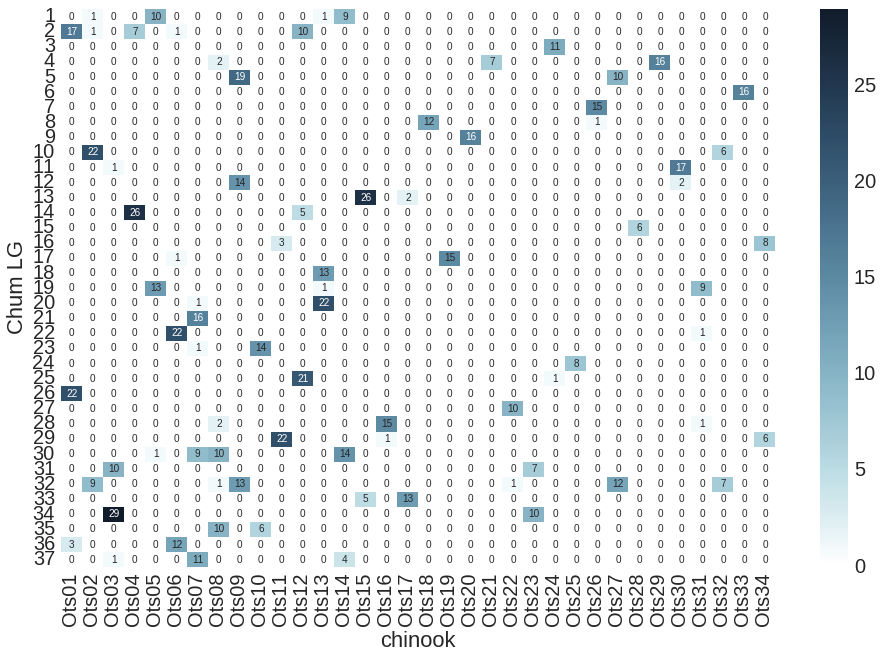

In [44]:
figsize(16,10)
my_colors = sns.cubehelix_palette(n_colors = 6, light=1, start = 2.8, rot = -.1, gamma = 1.2, as_cmap=True)
sns.heatmap(LG_vs_CHR, annot = True, linewidths = 0,square = False, cmap=my_colors, 
           cbar_kws={"orientation": "vertical"})
plt.xlabel('chinook')
plt.show()